# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder_debug import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mirna

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=True, filter_group_size=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
    
    return df

tcga_mirna = data_filtering(tcga_mirna_raw)

## Data Loader

In [7]:
# shuffle the data
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio= 0.7
batch_size = 128

train_mirna, val_mirna = train_test_split(tcga_mirna, train_size=train_ratio, stratify=tcga_mirna['cancer_type'], random_state=seed) 
val_mirna, test_mirna = train_test_split(val_mirna, test_size=0.50, stratify=val_mirna['cancer_type'], random_state=seed)

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDataset(val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDataset(test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [9]:
# make data split for train and validation sets
mirna_out_dim = tcga_mirna.shape[1]-4

In [10]:
print(train_mirna.shape)
print(val_mirna.shape)
print(test_mirna.shape)
print(mirna_out_dim)

(7473, 2028)
(1601, 2028)
(1602, 2028)
2024


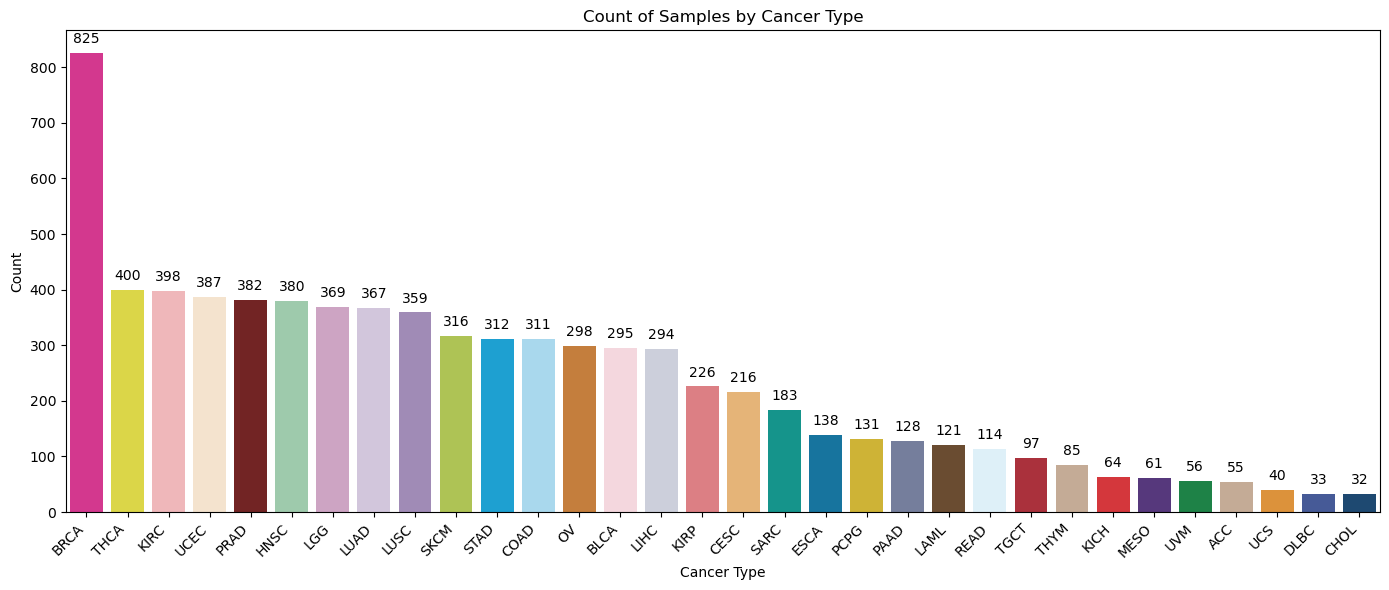

In [11]:
color_mapping = dict(zip(train_mirna['cancer_type'], train_mirna['color']))

primary_site_counts = train_mirna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [12]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [100, 100, 100] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [13]:
# Output Module Setup
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# Set up the decoder
decoder = Decoder(latent_dim, hidden_dims, output_module=output_mirna_layer).to(device)

# Setup GMM init
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [14]:
# Init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [15]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_module): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=100, out_features=2024, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

## Training loop

In [16]:
sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
sample_index

[1371, 1304, 34, 359]

In [17]:
# Training hyperparameters
learning_rates = {'dec':0.001,'rep':0.01,'gmm':0.01}
weight_decay = 0.
betas = (0.9, 0.999)

nepochs = 301
pr = 5 # how often to print epoch
plot = 50 # how often to print plot
subset = 1371
sample_index = [1382, 1310, 34, 360, 
                765, 999, 2000, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 1050, 56,
                1, 2, 3, 4]

  0%|                                                                                                                                                                                                                                                                                        | 0/301 [00:00<?, ?it/s]

0 train_recon: 11.66183698981022 train_gmm: 7.649521624201292 train_mse: 58779040.0 train_mae: 6226.96728515625 train_r2: -0.523757815361023 train_spearman: -0.010028833523392677 train_pearson: 0.0033029154874384403 train_expl_var: 2.2649765014648438e-06 train_msle: 67.0318374633789
0 test_recon: 4.337100291505062 test_gmm: 4.310506433967052 test_mse: 46316132.0 test_mae: 6000.30029296875 test_r2: -0.94272780418396 test_spearman: -0.04359286278486252 test_pearson: -0.0897059217095375 test_expl_var: -0.0002570152282714844 test_msle: 67.03575134277344


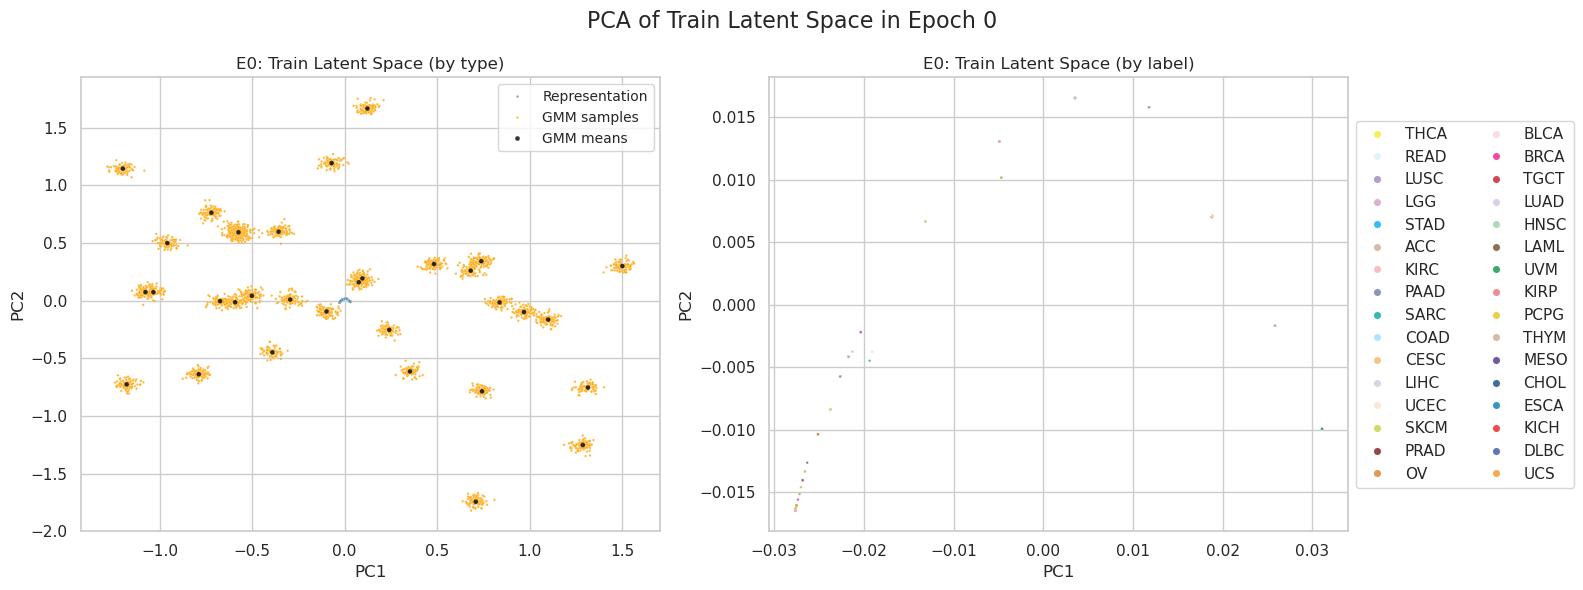

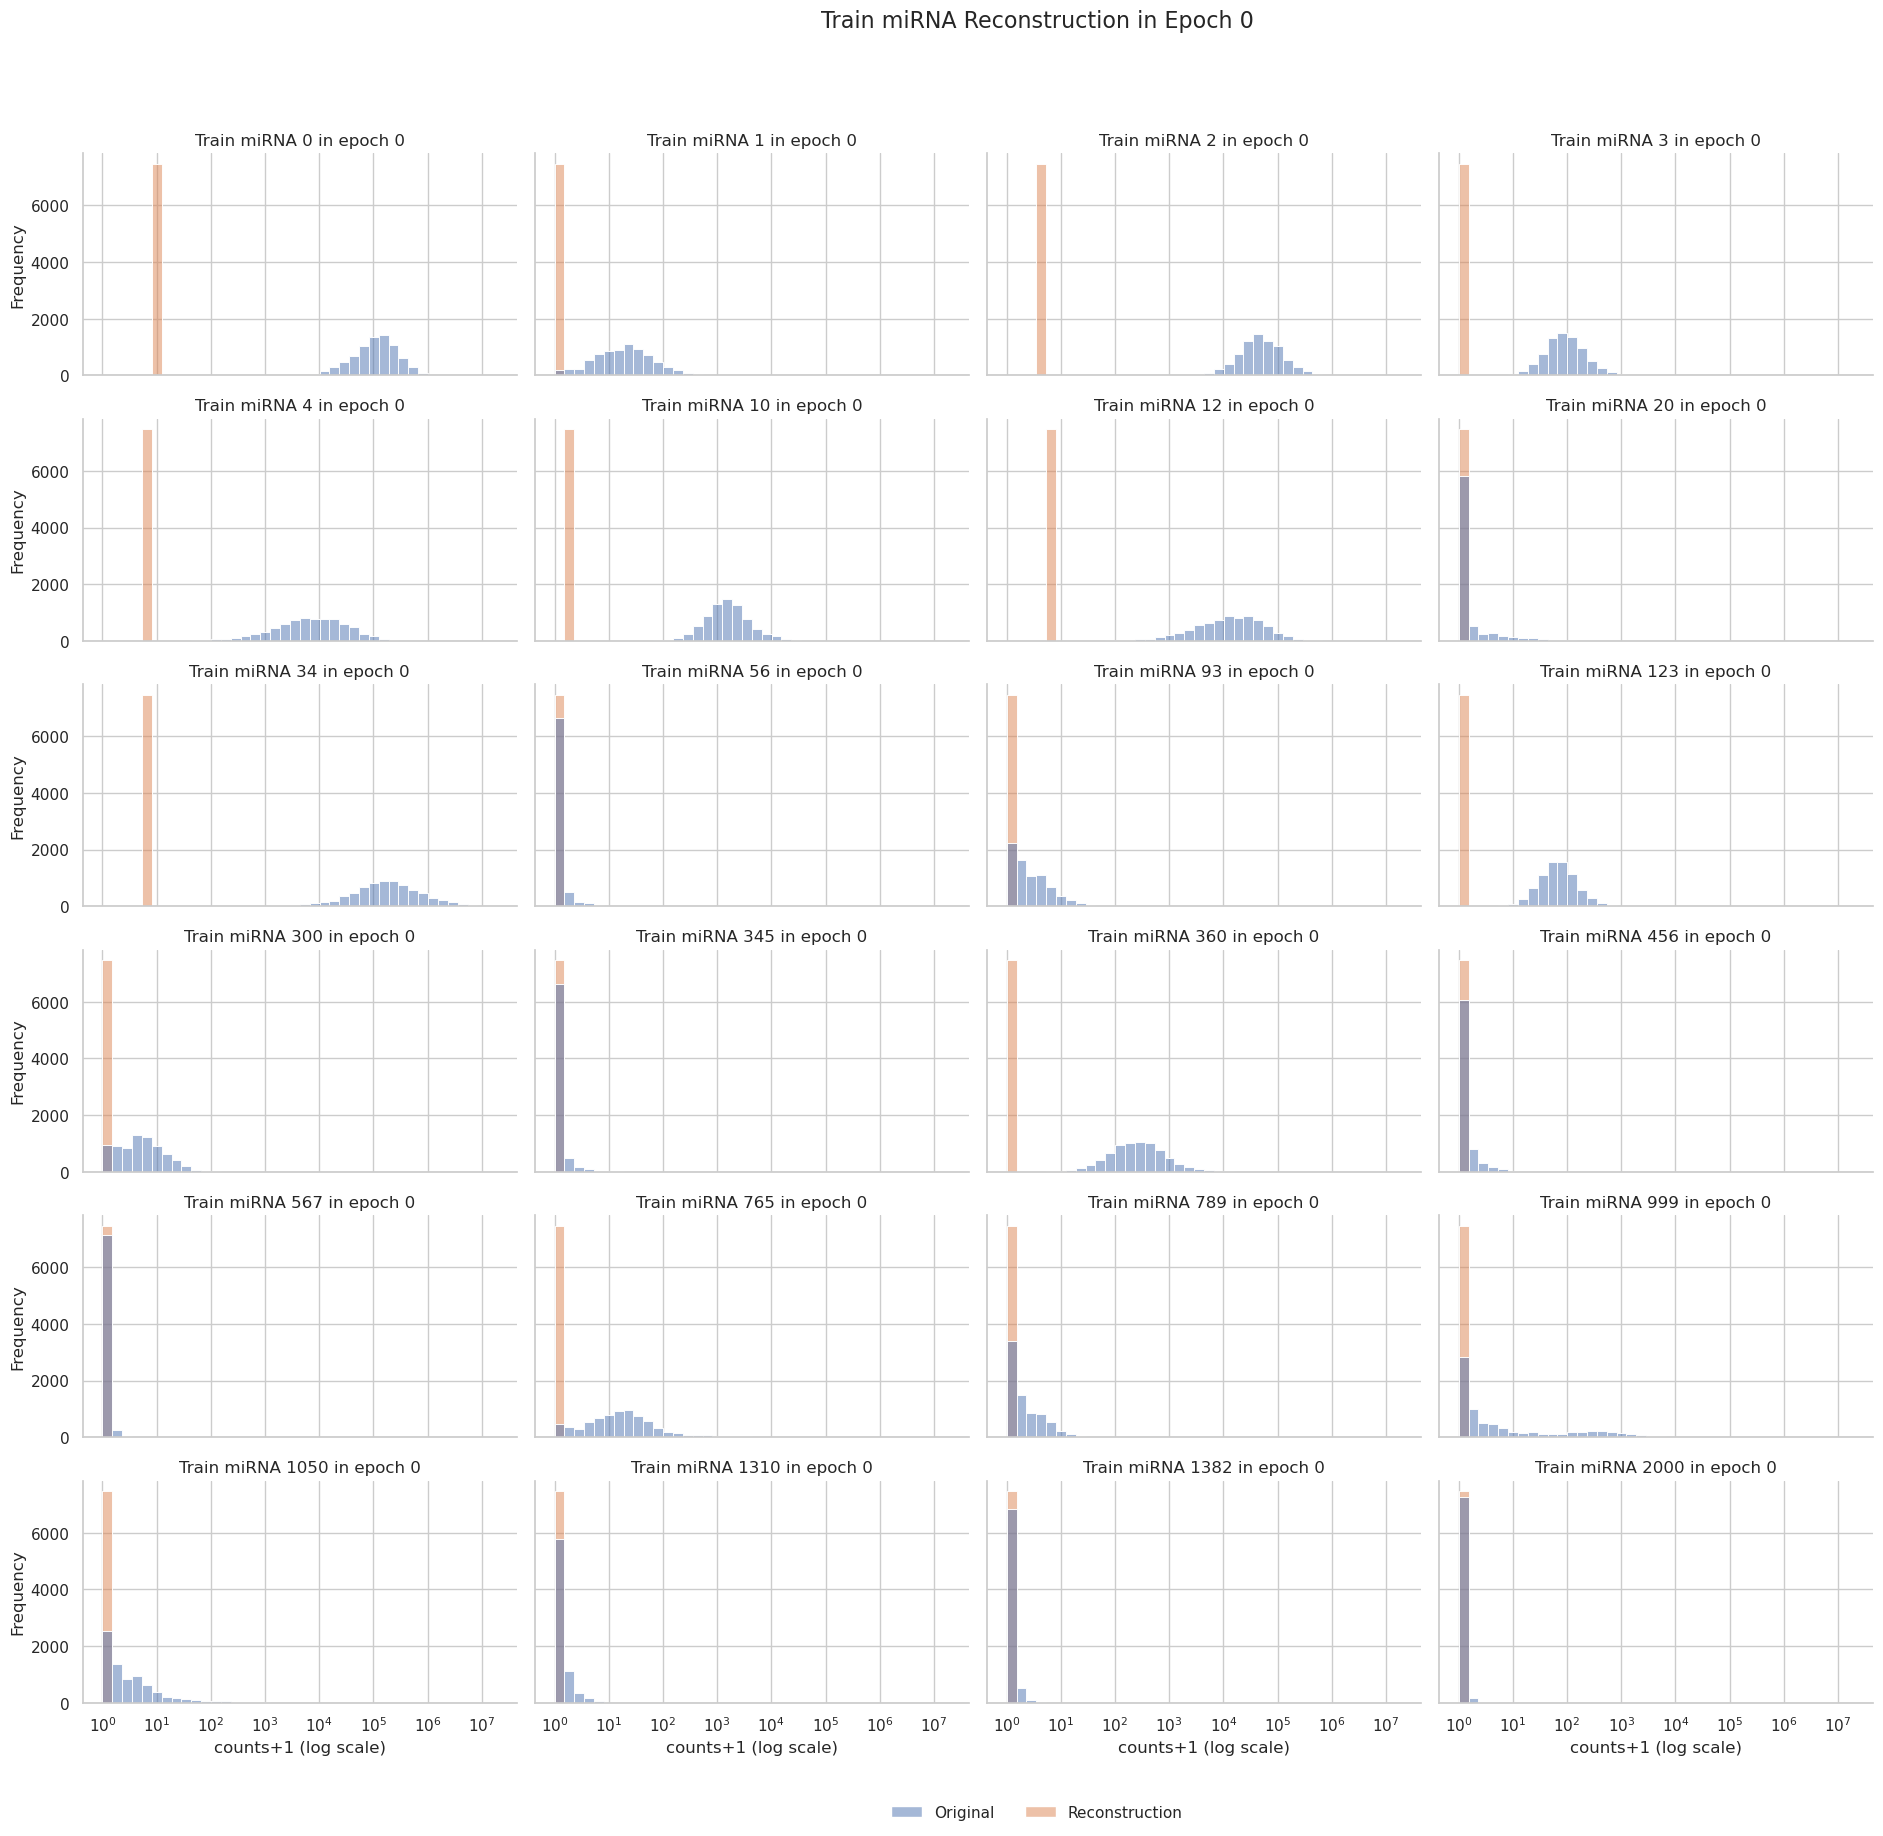

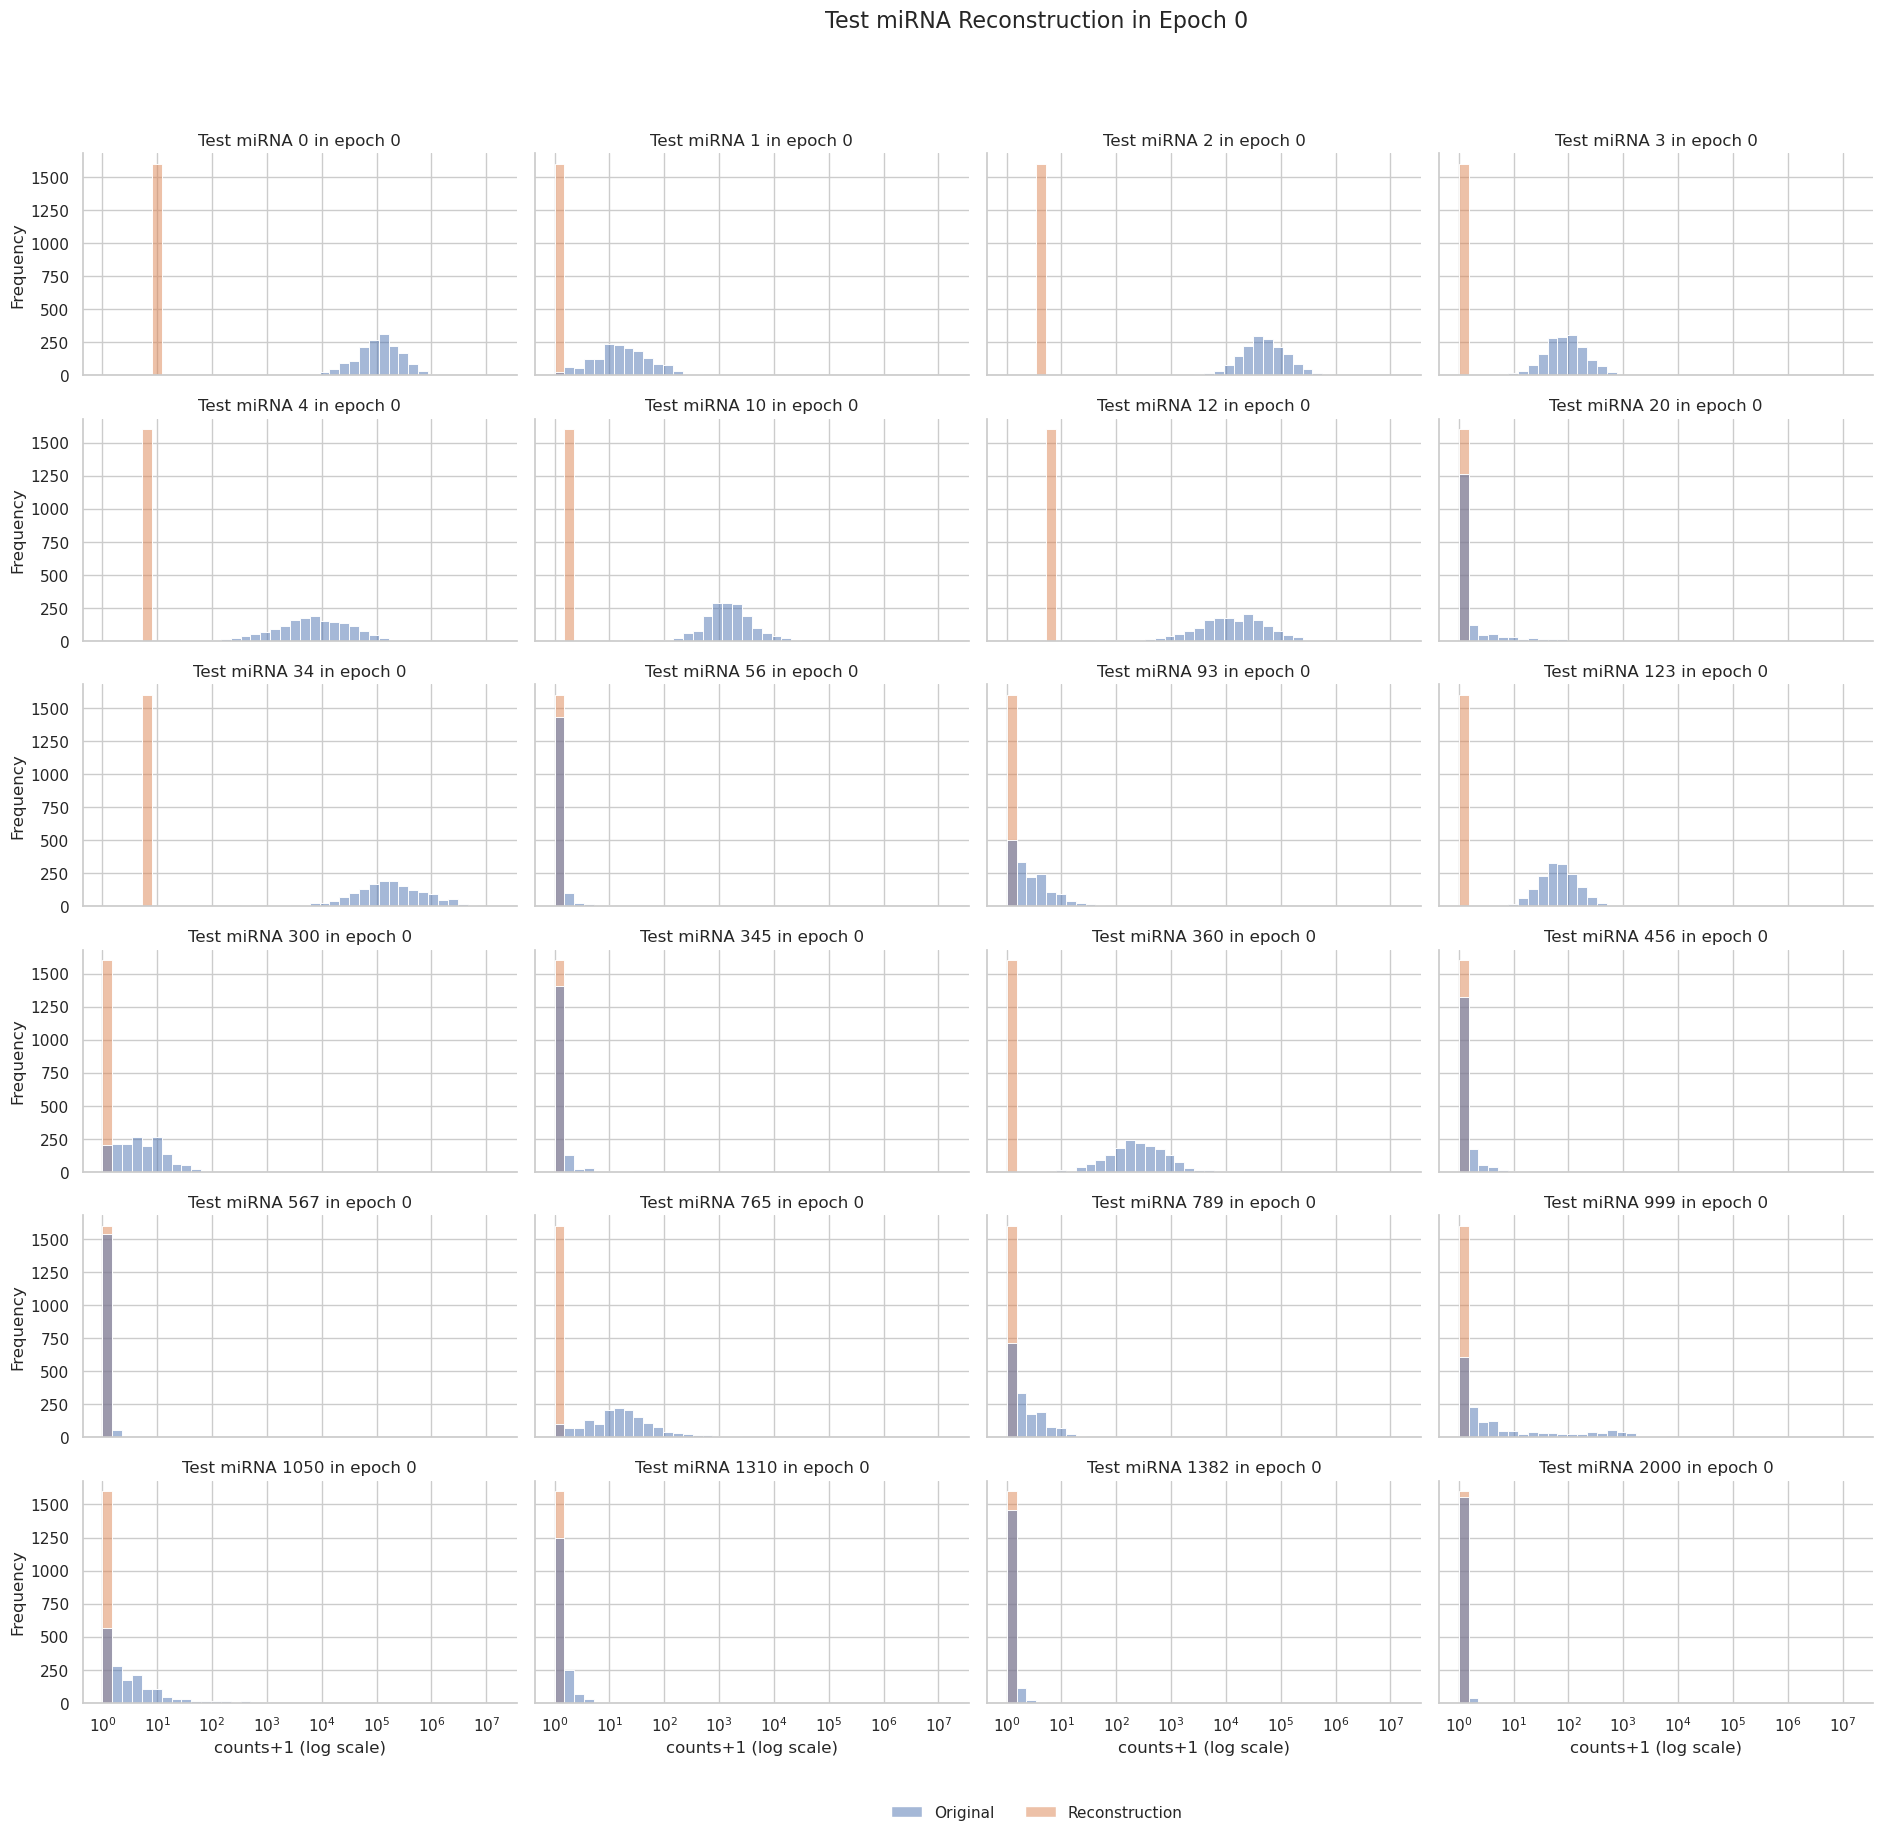

  2%|█████▍                                                                                                                                                                                                                                                                          | 6/301 [01:03<23:36,  4.80s/it]

5 train_recon: 2.428253397011851 train_gmm: 2.171298311290437 train_mse: 41966288.0 train_mae: 3779.644775390625 train_r2: -0.08791255950927734 train_spearman: 0.030124714598059654 train_pearson: 0.05585484579205513 train_expl_var: 0.00012546777725219727 train_msle: 57.255645751953125
5 test_recon: 2.4087324008370508 test_gmm: 2.1687678492568123 test_mse: 28210228.0 test_mae: 3542.36669921875 test_r2: -0.18327653408050537 test_spearman: 0.0016074477462098002 test_pearson: 0.05658572539687157 test_expl_var: 0.0001735687255859375 test_msle: 57.23585510253906


  4%|█████████▉                                                                                                                                                                                                                                                                     | 11/301 [01:12<11:00,  2.28s/it]

10 train_recon: 2.22968548310479 train_gmm: 2.1532610937787493 train_mse: 38666396.0 train_mae: 2360.729248046875 train_r2: -0.002367854118347168 train_spearman: 0.055840976536273956 train_pearson: 0.026425467804074287 train_expl_var: 4.374980926513672e-05 train_msle: 46.70637130737305
10 test_recon: 2.2216595922323745 test_gmm: 2.1555825247159976 test_mse: 23973768.0 test_mae: 2077.267822265625 test_r2: -0.005578517913818359 test_spearman: 0.029074225574731827 test_pearson: 0.07670209556818008 test_expl_var: 0.005549728870391846 test_msle: 46.31013107299805


  5%|██████████████▍                                                                                                                                                                                                                                                                | 16/301 [01:21<09:11,  1.94s/it]

15 train_recon: 2.173567465776995 train_gmm: 2.1540660195061596 train_mse: 38790648.0 train_mae: 2458.880859375 train_r2: -0.005589008331298828 train_spearman: 0.034023791551589966 train_pearson: 0.015137813054025173 train_expl_var: -0.0011868476867675781 train_msle: 47.72110366821289
15 test_recon: 2.1667458583352057 test_gmm: 2.1570892810523694 test_mse: 24181508.0 test_mae: 2244.056884765625 test_r2: -0.014292120933532715 test_spearman: 0.0065894098952412605 test_pearson: 0.07903774827718735 test_expl_var: 0.006134927272796631 test_msle: 47.96318054199219


  7%|██████████████████▉                                                                                                                                                                                                                                                            | 21/301 [01:31<08:38,  1.85s/it]

20 train_recon: 2.134776082401256 train_gmm: 2.1550399667971365 train_mse: 39079968.0 train_mae: 2752.309326171875 train_r2: -0.01308906078338623 train_spearman: 0.010529576800763607 train_pearson: 0.03210250288248062 train_expl_var: 0.0008224248886108398 train_msle: 50.43378448486328
20 test_recon: 2.129369663506998 test_gmm: 2.1576644906991724 test_mse: 24718606.0 test_mae: 2510.00390625 test_r2: -0.03682065010070801 test_spearman: 0.002216737251728773 test_pearson: 0.061105743050575256 test_expl_var: 0.0037339329719543457 test_msle: 50.38224411010742


  9%|███████████████████████▍                                                                                                                                                                                                                                                       | 26/301 [01:40<08:37,  1.88s/it]

25 train_recon: 2.102474187460232 train_gmm: 2.1551090321642286 train_mse: 38367472.0 train_mae: 2218.599365234375 train_r2: 0.005381286144256592 train_spearman: 0.00820460356771946 train_pearson: 0.08972782641649246 train_expl_var: 0.006024301052093506 train_msle: 45.26890182495117
25 test_recon: 2.0941555024897975 test_gmm: 2.1587819563456434 test_mse: 23859404.0 test_mae: 1958.6370849609375 test_r2: -0.0007814168930053711 test_spearman: -0.0025378523860126734 test_pearson: 0.07775922119617462 test_expl_var: 0.005510866641998291 test_msle: 45.03190612792969


 10%|███████████████████████████▉                                                                                                                                                                                                                                                   | 31/301 [01:49<08:20,  1.85s/it]

30 train_recon: 2.074335847481434 train_gmm: 2.155212426846021 train_mse: 38175528.0 train_mae: 2124.4130859375 train_r2: 0.010357081890106201 train_spearman: 0.00013183164992369711 train_pearson: 0.1047009751200676 train_expl_var: 0.010476112365722656 train_msle: 42.80556869506836
30 test_recon: 2.0696287931764483 test_gmm: 2.159497634535056 test_mse: 23682654.0 test_mae: 1837.348876953125 test_r2: 0.006632328033447266 test_spearman: -0.018091382458806038 test_pearson: 0.09779807925224304 test_expl_var: 0.009550333023071289 test_msle: 42.335487365722656


 12%|████████████████████████████████▍                                                                                                                                                                                                                                              | 36/301 [01:59<08:14,  1.87s/it]

35 train_recon: 2.0477150248718177 train_gmm: 2.156177589256218 train_mse: 38270272.0 train_mae: 1707.106689453125 train_r2: 0.007901012897491455 train_spearman: 0.036504846066236496 train_pearson: 0.10822095721960068 train_expl_var: 0.011674880981445312 train_msle: 32.81755447387695
35 test_recon: 2.043242084214905 test_gmm: 2.1607778478904787 test_mse: 23466898.0 test_mae: 1395.2303466796875 test_r2: 0.0156821608543396 test_spearman: 0.0572032704949379 test_pearson: 0.13372918963432312 test_expl_var: 0.01742076873779297 test_msle: 31.784286499023438


 14%|████████████████████████████████████▉                                                                                                                                                                                                                                          | 41/301 [02:08<08:10,  1.89s/it]

40 train_recon: 2.017861695879871 train_gmm: 2.157752327323678 train_mse: 37763104.0 train_mae: 1783.8450927734375 train_r2: 0.02104860544204712 train_spearman: 0.06447546184062958 train_pearson: 0.15117081999778748 train_expl_var: 0.022802531719207764 train_msle: 31.291589736938477
40 test_recon: 2.0101433099495623 test_gmm: 2.1614548234623867 test_mse: 22908676.0 test_mae: 1507.7398681640625 test_r2: 0.03909677267074585 test_spearman: 0.08676838129758835 test_pearson: 0.19801729917526245 test_expl_var: 0.03914922475814819 test_msle: 30.933324813842773


 15%|█████████████████████████████████████████▍                                                                                                                                                                                                                                     | 46/301 [02:17<07:48,  1.84s/it]

45 train_recon: 1.9834024968063553 train_gmm: 2.159009563334253 train_mse: 37371584.0 train_mae: 1574.13427734375 train_r2: 0.03119814395904541 train_spearman: 0.06727145612239838 train_pearson: 0.19101829826831818 train_expl_var: 0.03648418188095093 train_msle: 21.801300048828125
45 test_recon: 1.9751978059044124 test_gmm: 2.1624314164609033 test_mse: 22412970.0 test_mae: 1302.3492431640625 test_r2: 0.059889137744903564 test_spearman: 0.0871996134519577 test_pearson: 0.2487310916185379 test_expl_var: 0.06173187494277954 test_msle: 21.568681716918945


 17%|█████████████████████████████████████████████                                                                                                                                                                                                                                  | 50/301 [02:25<07:46,  1.86s/it]

50 train_recon: 1.9483579787101815 train_gmm: 2.1602011740965392 train_mse: 36021312.0 train_mae: 1408.437255859375 train_r2: 0.06620192527770996 train_spearman: 0.099642813205719 train_pearson: 0.302325576543808 train_expl_var: 0.07505035400390625 train_msle: 17.07874870300293
50 test_recon: 1.9415711107558764 test_gmm: 2.162710927740475 test_mse: 21481252.0 test_mae: 1143.230712890625 test_r2: 0.09896999597549438 test_spearman: 0.09987888485193253 test_pearson: 0.34608030319213867 test_expl_var: 0.10395938158035278 test_msle: 16.749095916748047


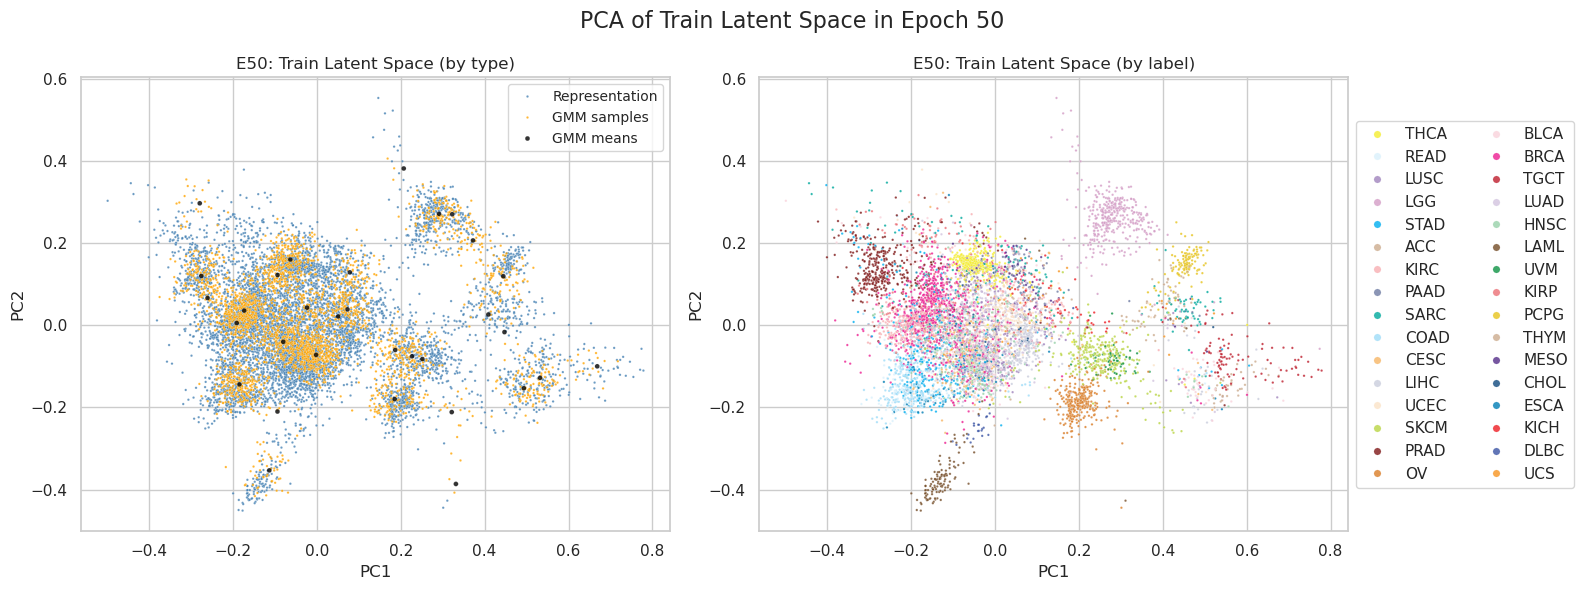

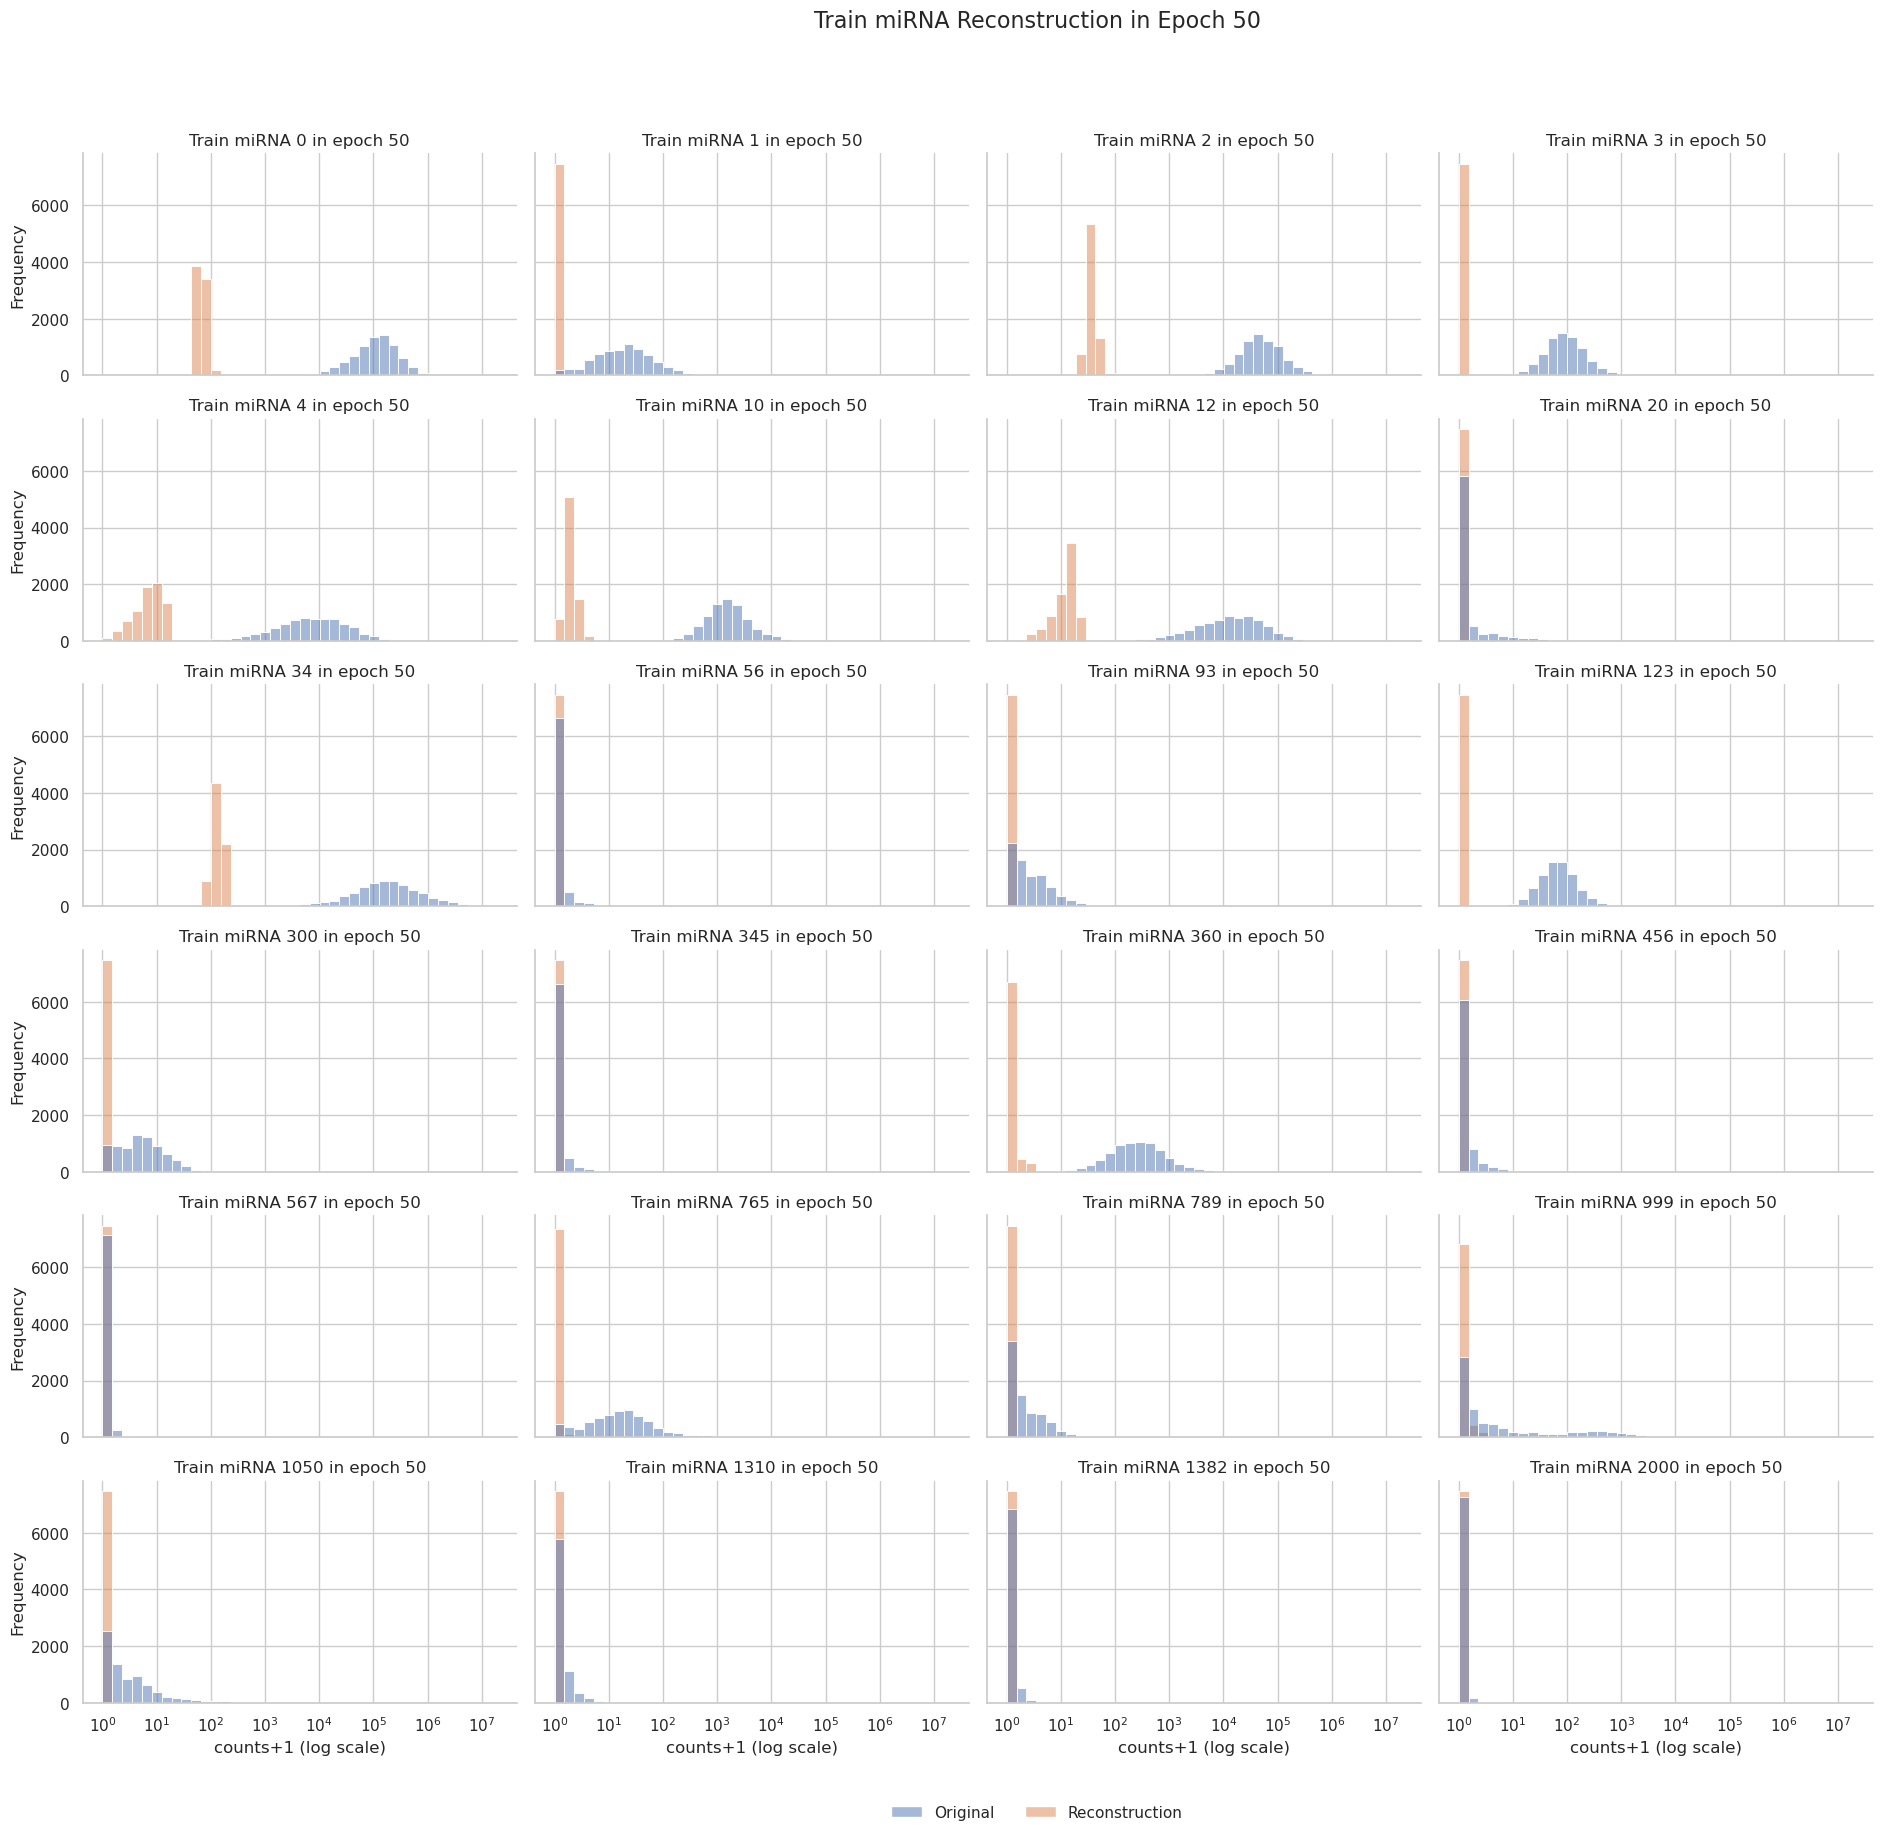

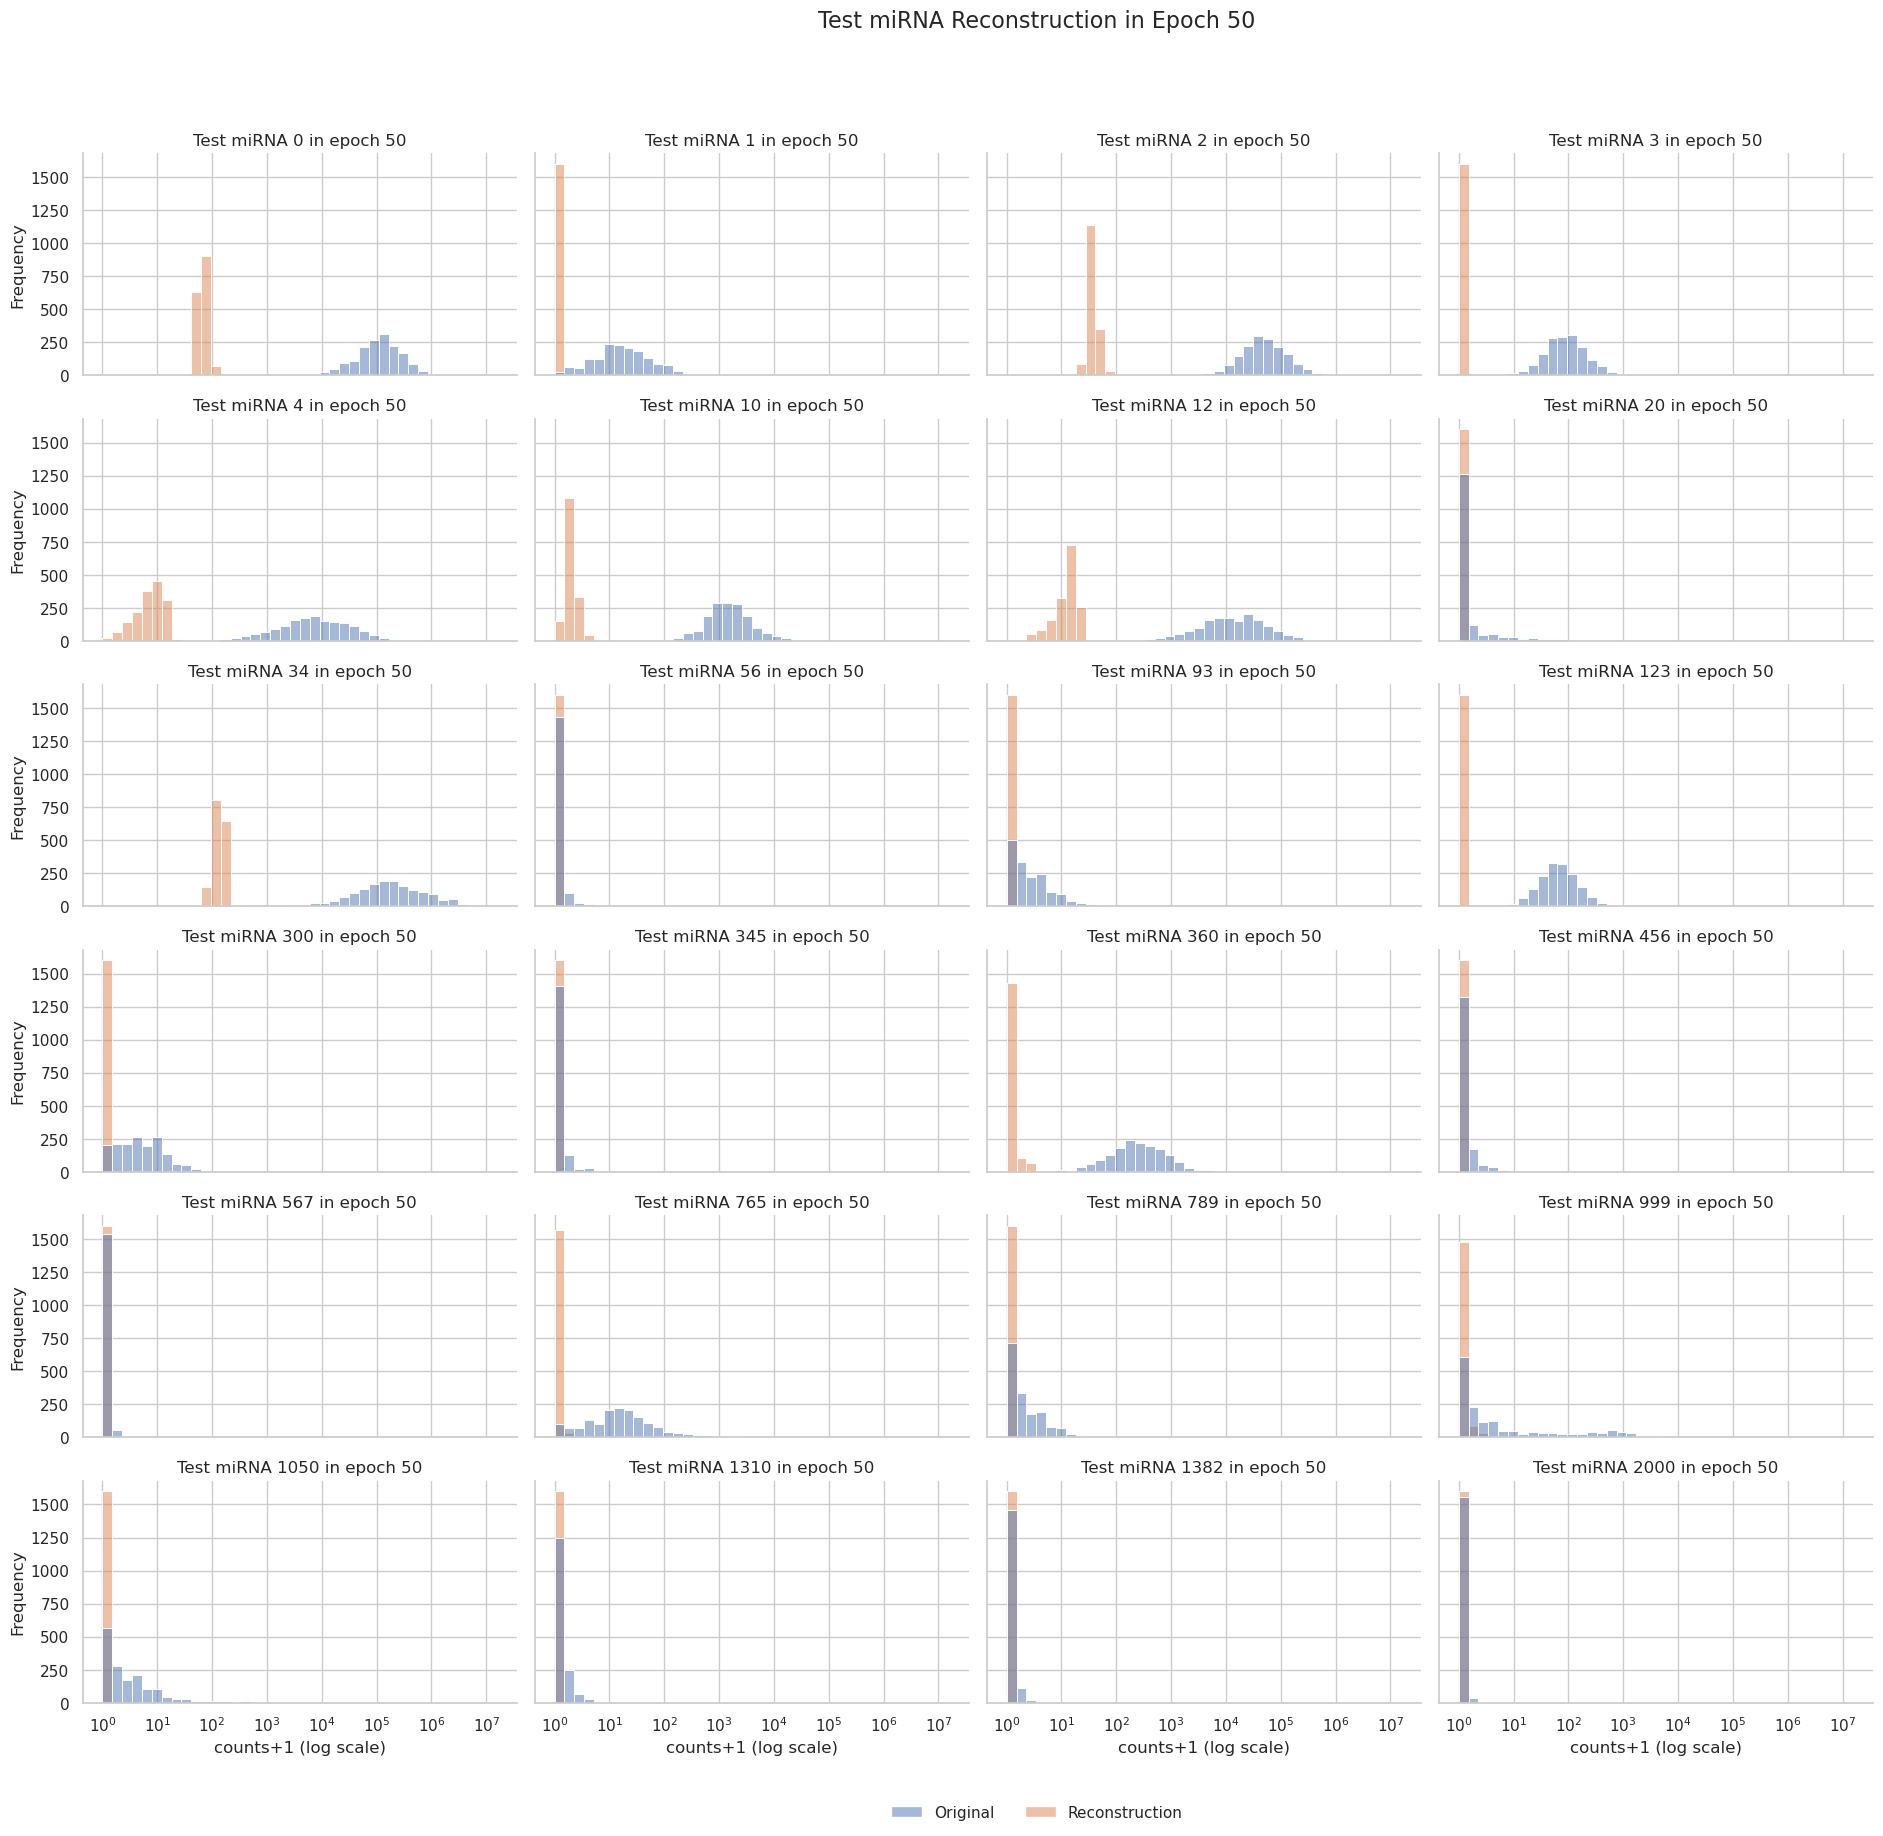

 19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                            | 56/301 [03:30<19:11,  4.70s/it]

55 train_recon: 1.928434010577076 train_gmm: 2.160669392887311 train_mse: 34884660.0 train_mae: 1310.294677734375 train_r2: 0.09566789865493774 train_spearman: 0.13726411759853363 train_pearson: 0.40174734592437744 train_expl_var: 0.10650581121444702 train_msle: 14.576566696166992
55 test_recon: 1.9226947904811222 test_gmm: 2.1635340979514757 test_mse: 20414210.0 test_mae: 1033.271728515625 test_r2: 0.14372700452804565 test_spearman: 0.1439741998910904 test_pearson: 0.46190357208251953 test_expl_var: 0.1510412096977234 test_msle: 14.167842864990234


 20%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                                        | 61/301 [03:40<10:02,  2.51s/it]

60 train_recon: 1.9152888836487905 train_gmm: 2.1614577354779287 train_mse: 34688484.0 train_mae: 1209.1343994140625 train_r2: 0.10075348615646362 train_spearman: 0.17347835004329681 train_pearson: 0.4708642363548279 train_expl_var: 0.1155429482460022 train_msle: 10.793110847473145
60 test_recon: 1.9088513763939534 test_gmm: 2.1641507703315312 test_mse: 20291446.0 test_mae: 929.69384765625 test_r2: 0.1488763689994812 test_spearman: 0.17182543873786926 test_pearson: 0.5330519676208496 test_expl_var: 0.16082119941711426 test_msle: 10.13049030303955


 22%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                   | 66/301 [03:50<08:22,  2.14s/it]

65 train_recon: 1.905237240511824 train_gmm: 2.162160996383857 train_mse: 33850952.0 train_mae: 1170.1749267578125 train_r2: 0.12246525287628174 train_spearman: 0.20204751193523407 train_pearson: 0.5491099953651428 train_expl_var: 0.13768374919891357 train_msle: 9.961235046386719
65 test_recon: 1.8990678958988083 test_gmm: 2.164175794364362 test_mse: 19711302.0 test_mae: 901.592041015625 test_r2: 0.1732105016708374 test_spearman: 0.20572078227996826 test_pearson: 0.6038922071456909 test_expl_var: 0.18533694744110107 test_msle: 9.524182319641113


 24%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 71/301 [04:01<07:53,  2.06s/it]

70 train_recon: 1.8969516523483223 train_gmm: 2.1623011559060537 train_mse: 32864252.0 train_mae: 1131.140625 train_r2: 0.1480439305305481 train_spearman: 0.21392816305160522 train_pearson: 0.6339944005012512 train_expl_var: 0.16347122192382812 train_msle: 9.810179710388184
70 test_recon: 1.89051463635623 test_gmm: 2.1639802226269715 test_mse: 19163982.0 test_mae: 874.5870361328125 test_r2: 0.19616776704788208 test_spearman: 0.21991753578186035 test_pearson: 0.6571401953697205 test_expl_var: 0.208299458026886 test_msle: 9.502972602844238


 25%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                          | 76/301 [04:11<07:45,  2.07s/it]

75 train_recon: 1.8897364194400237 train_gmm: 2.1622061459012865 train_mse: 33098582.0 train_mae: 1064.6566162109375 train_r2: 0.14196932315826416 train_spearman: 0.22679857909679413 train_pearson: 0.6965145468711853 train_expl_var: 0.16104573011398315 train_msle: 6.667610168457031
75 test_recon: 1.882964954007562 test_gmm: 2.1639297475820776 test_mse: 19303028.0 test_mae: 814.6844482421875 test_r2: 0.1903354525566101 test_spearman: 0.22709952294826508 test_pearson: 0.7227179408073425 test_expl_var: 0.20631098747253418 test_msle: 6.48590087890625


 27%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 81/301 [04:21<07:25,  2.03s/it]

80 train_recon: 1.8819456028196897 train_gmm: 2.1620623290068206 train_mse: 32392484.0 train_mae: 1018.3564453125 train_r2: 0.16027379035949707 train_spearman: 0.2585379183292389 train_pearson: 0.7640146017074585 train_expl_var: 0.18048536777496338 train_msle: 4.998544216156006
80 test_recon: 1.8759648091191152 test_gmm: 2.163418882180571 test_mse: 18819108.0 test_mae: 775.9199829101562 test_r2: 0.2106335163116455 test_spearman: 0.2583121061325073 test_pearson: 0.7817522287368774 test_expl_var: 0.22769933938980103 test_msle: 5.011745929718018


 29%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 86/301 [04:31<07:20,  2.05s/it]

85 train_recon: 1.8742365756182071 train_gmm: 2.1618822716205424 train_mse: 31513360.0 train_mae: 986.9121704101562 train_r2: 0.18306374549865723 train_spearman: 0.30671757459640503 train_pearson: 0.7908068895339966 train_expl_var: 0.20314371585845947 train_msle: 3.59891939163208
85 test_recon: 1.8686613426205954 test_gmm: 2.1628407294269207 test_mse: 18271528.0 test_mae: 745.8312377929688 test_r2: 0.23360168933868408 test_spearman: 0.30411162972450256 test_pearson: 0.8105320334434509 test_expl_var: 0.2508092522621155 test_msle: 3.5304980278015137


 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 91/301 [04:41<07:05,  2.02s/it]

90 train_recon: 1.8676918023130966 train_gmm: 2.161729516297734 train_mse: 30048700.0 train_mae: 955.9974365234375 train_r2: 0.22103285789489746 train_spearman: 0.3623368442058563 train_pearson: 0.8198813796043396 train_expl_var: 0.23985236883163452 train_msle: 3.1116137504577637
90 test_recon: 1.8623287029722035 test_gmm: 2.162270338545733 test_mse: 17159454.0 test_mae: 710.60205078125 test_r2: 0.28024762868881226 test_spearman: 0.35661494731903076 test_pearson: 0.8449665307998657 test_expl_var: 0.29629385471343994 test_msle: 2.9468564987182617


 32%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 96/301 [04:52<07:02,  2.06s/it]

95 train_recon: 1.8621352622074514 train_gmm: 2.161635011039743 train_mse: 29476250.0 train_mae: 940.1860961914062 train_r2: 0.23587274551391602 train_spearman: 0.40161389112472534 train_pearson: 0.8319552540779114 train_expl_var: 0.2545074224472046 train_msle: 2.3221001625061035
95 test_recon: 1.8565649317805324 test_gmm: 2.1622235919444877 test_mse: 16764967.0 test_mae: 692.0387573242188 test_r2: 0.2967942953109741 test_spearman: 0.38772574067115784 test_pearson: 0.8601220846176147 test_expl_var: 0.31300419569015503 test_msle: 2.0286009311676025


 33%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 100/301 [05:00<07:01,  2.10s/it]

100 train_recon: 1.8569280879380525 train_gmm: 2.1615602366435835 train_mse: 28274074.0 train_mae: 919.2251586914062 train_r2: 0.26703739166259766 train_spearman: 0.4265262186527252 train_pearson: 0.8404003977775574 train_expl_var: 0.28428542613983154 train_msle: 2.4256436824798584
100 test_recon: 1.8512909064909406 test_gmm: 2.162342071056664 test_mse: 15822419.0 test_mae: 669.629150390625 test_r2: 0.33632946014404297 test_spearman: 0.40365034341812134 test_pearson: 0.8647358417510986 test_expl_var: 0.3509063720703125 test_msle: 2.104605197906494


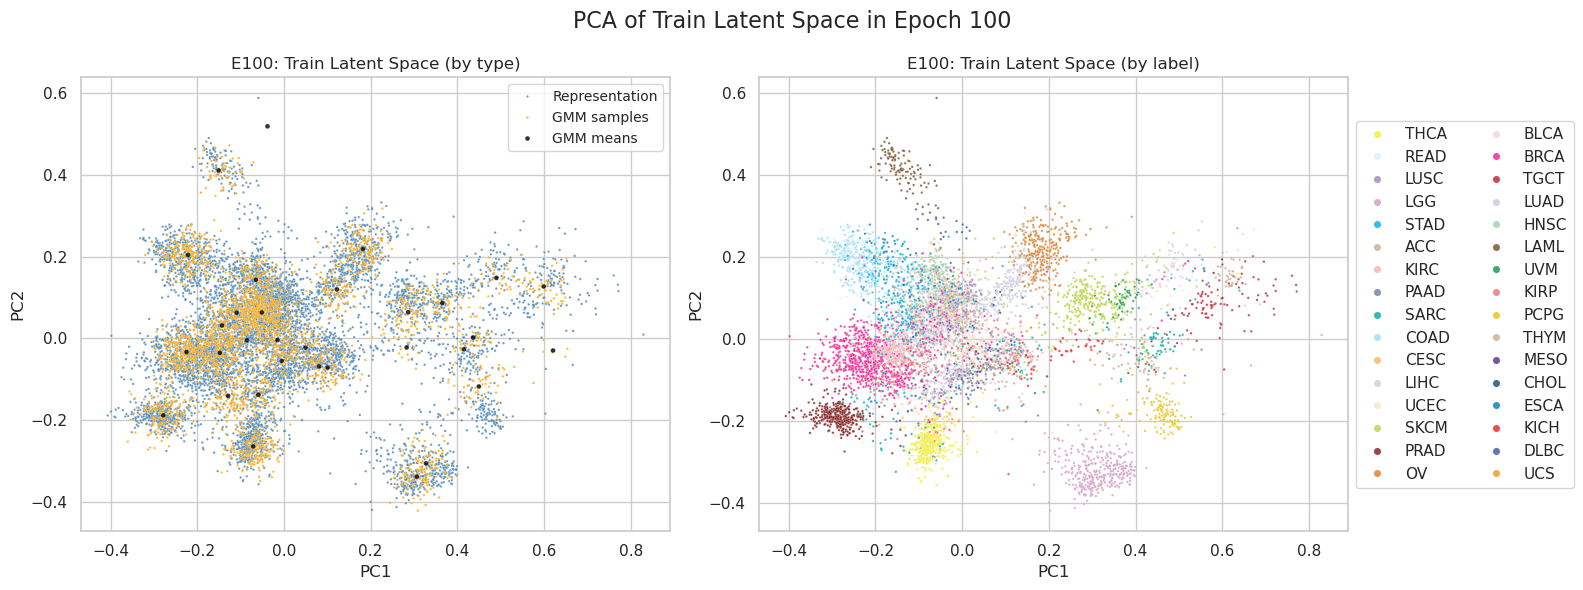

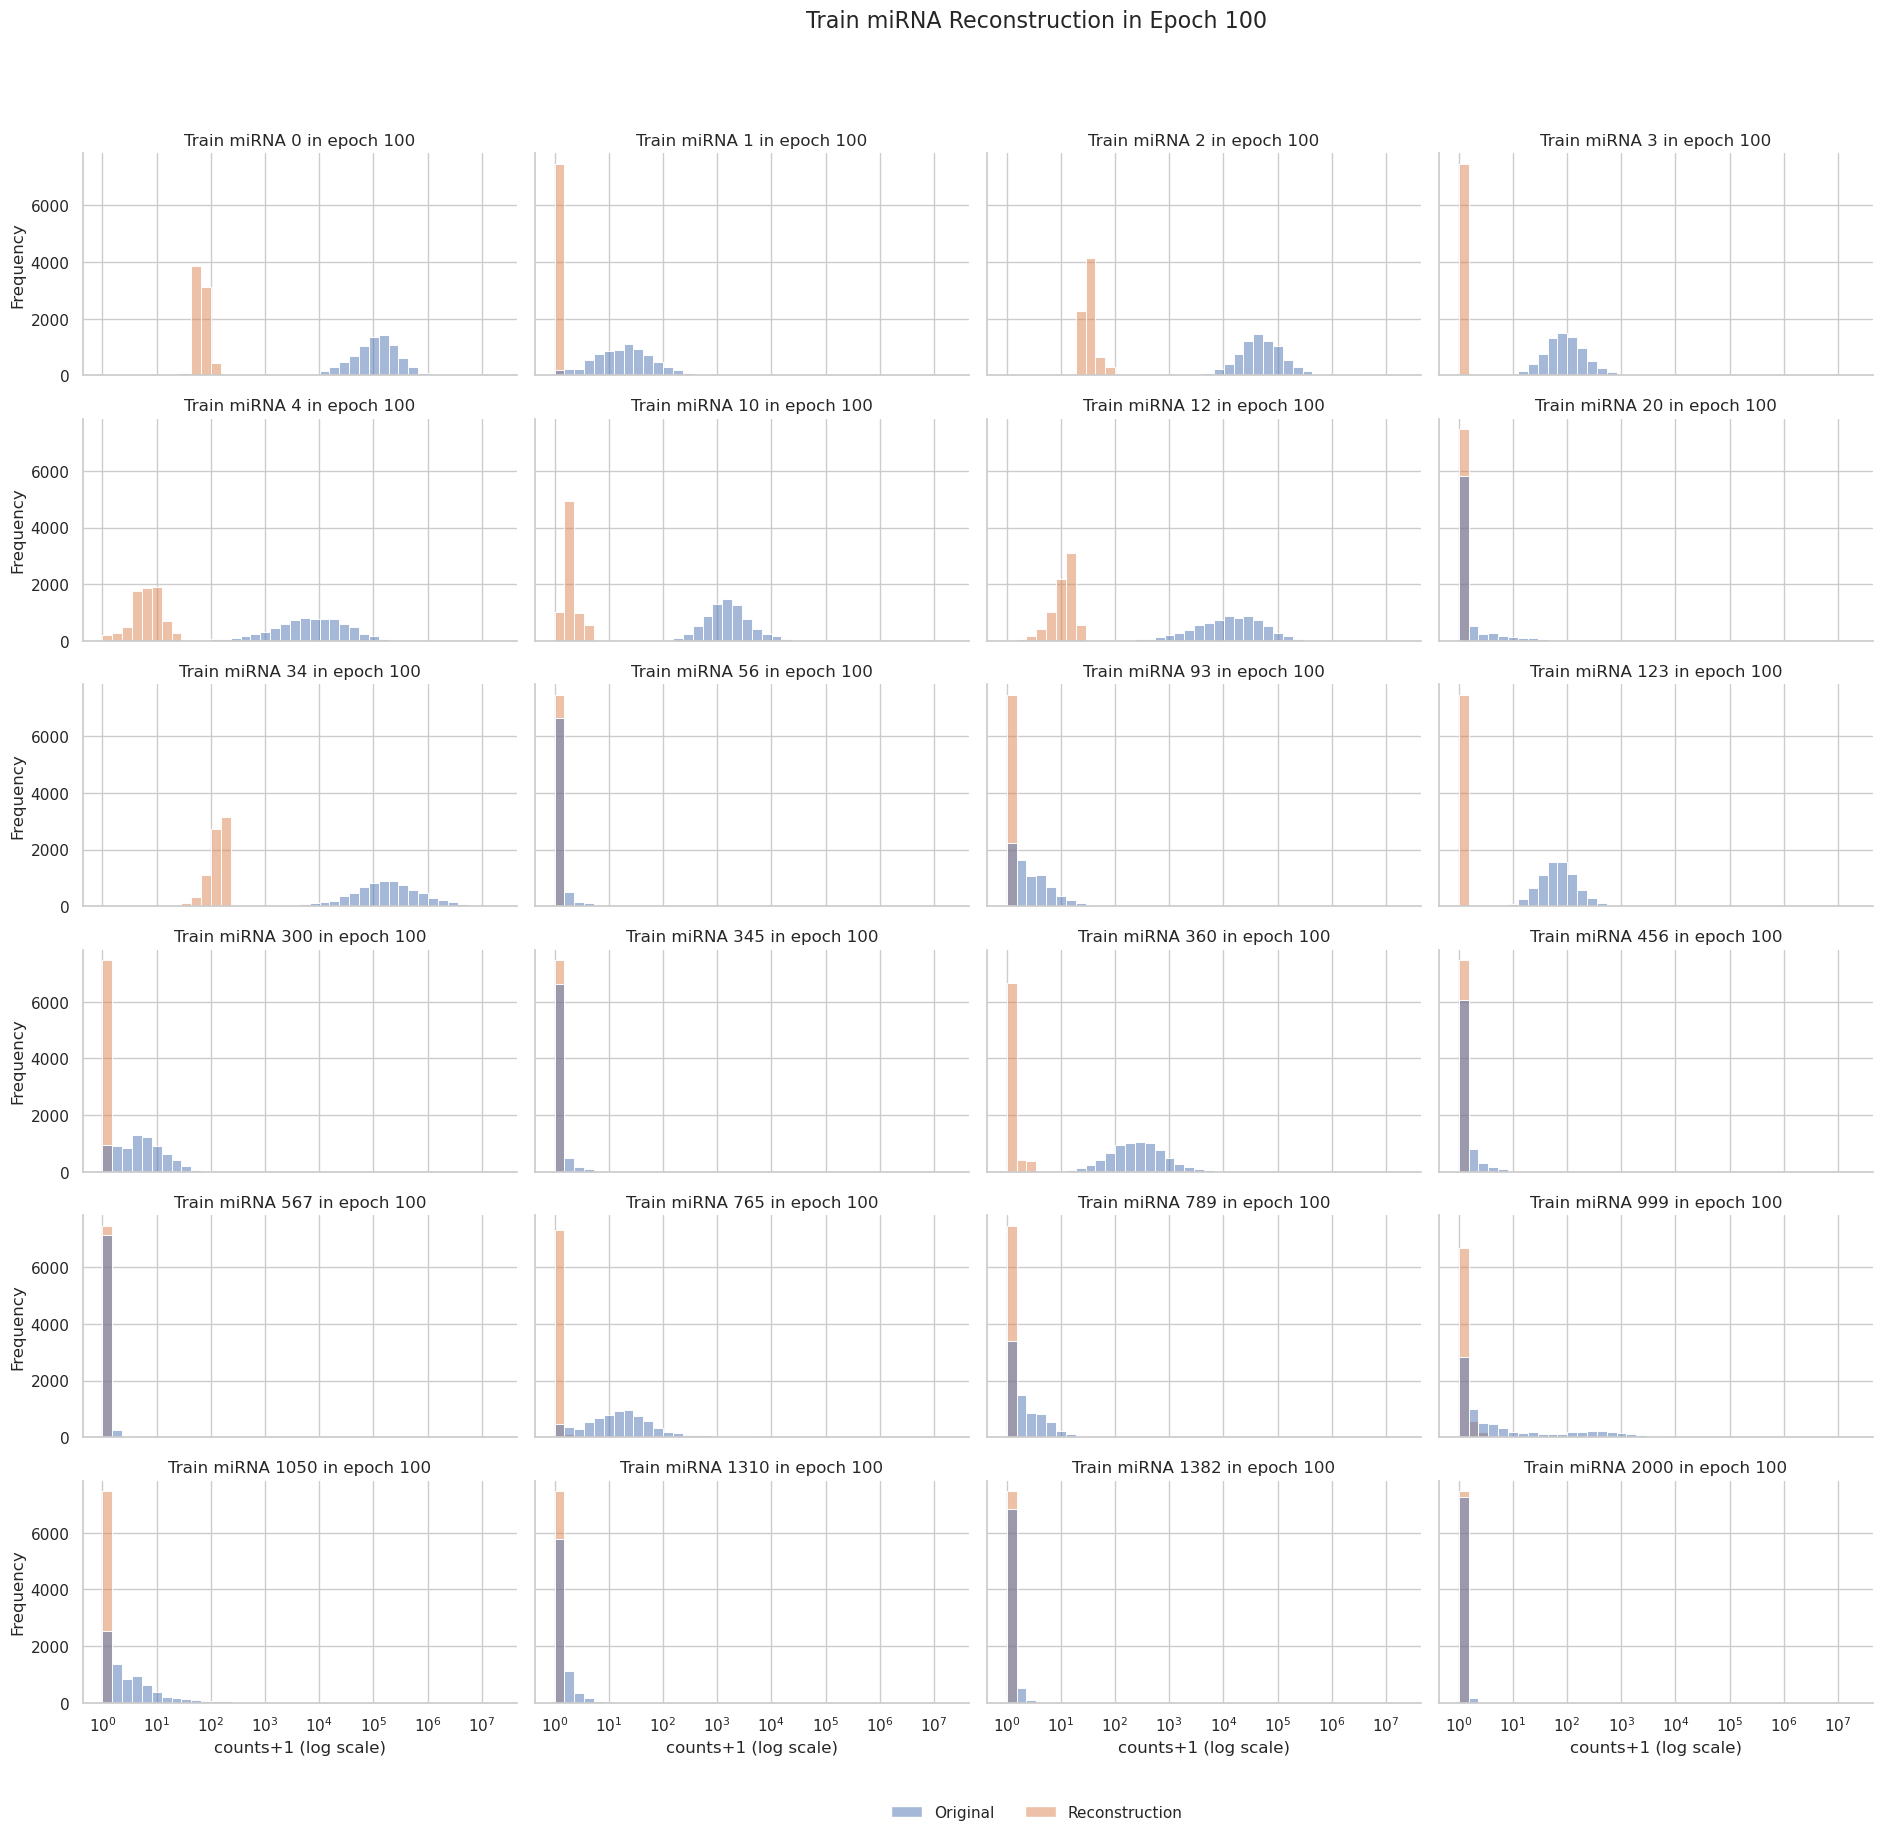

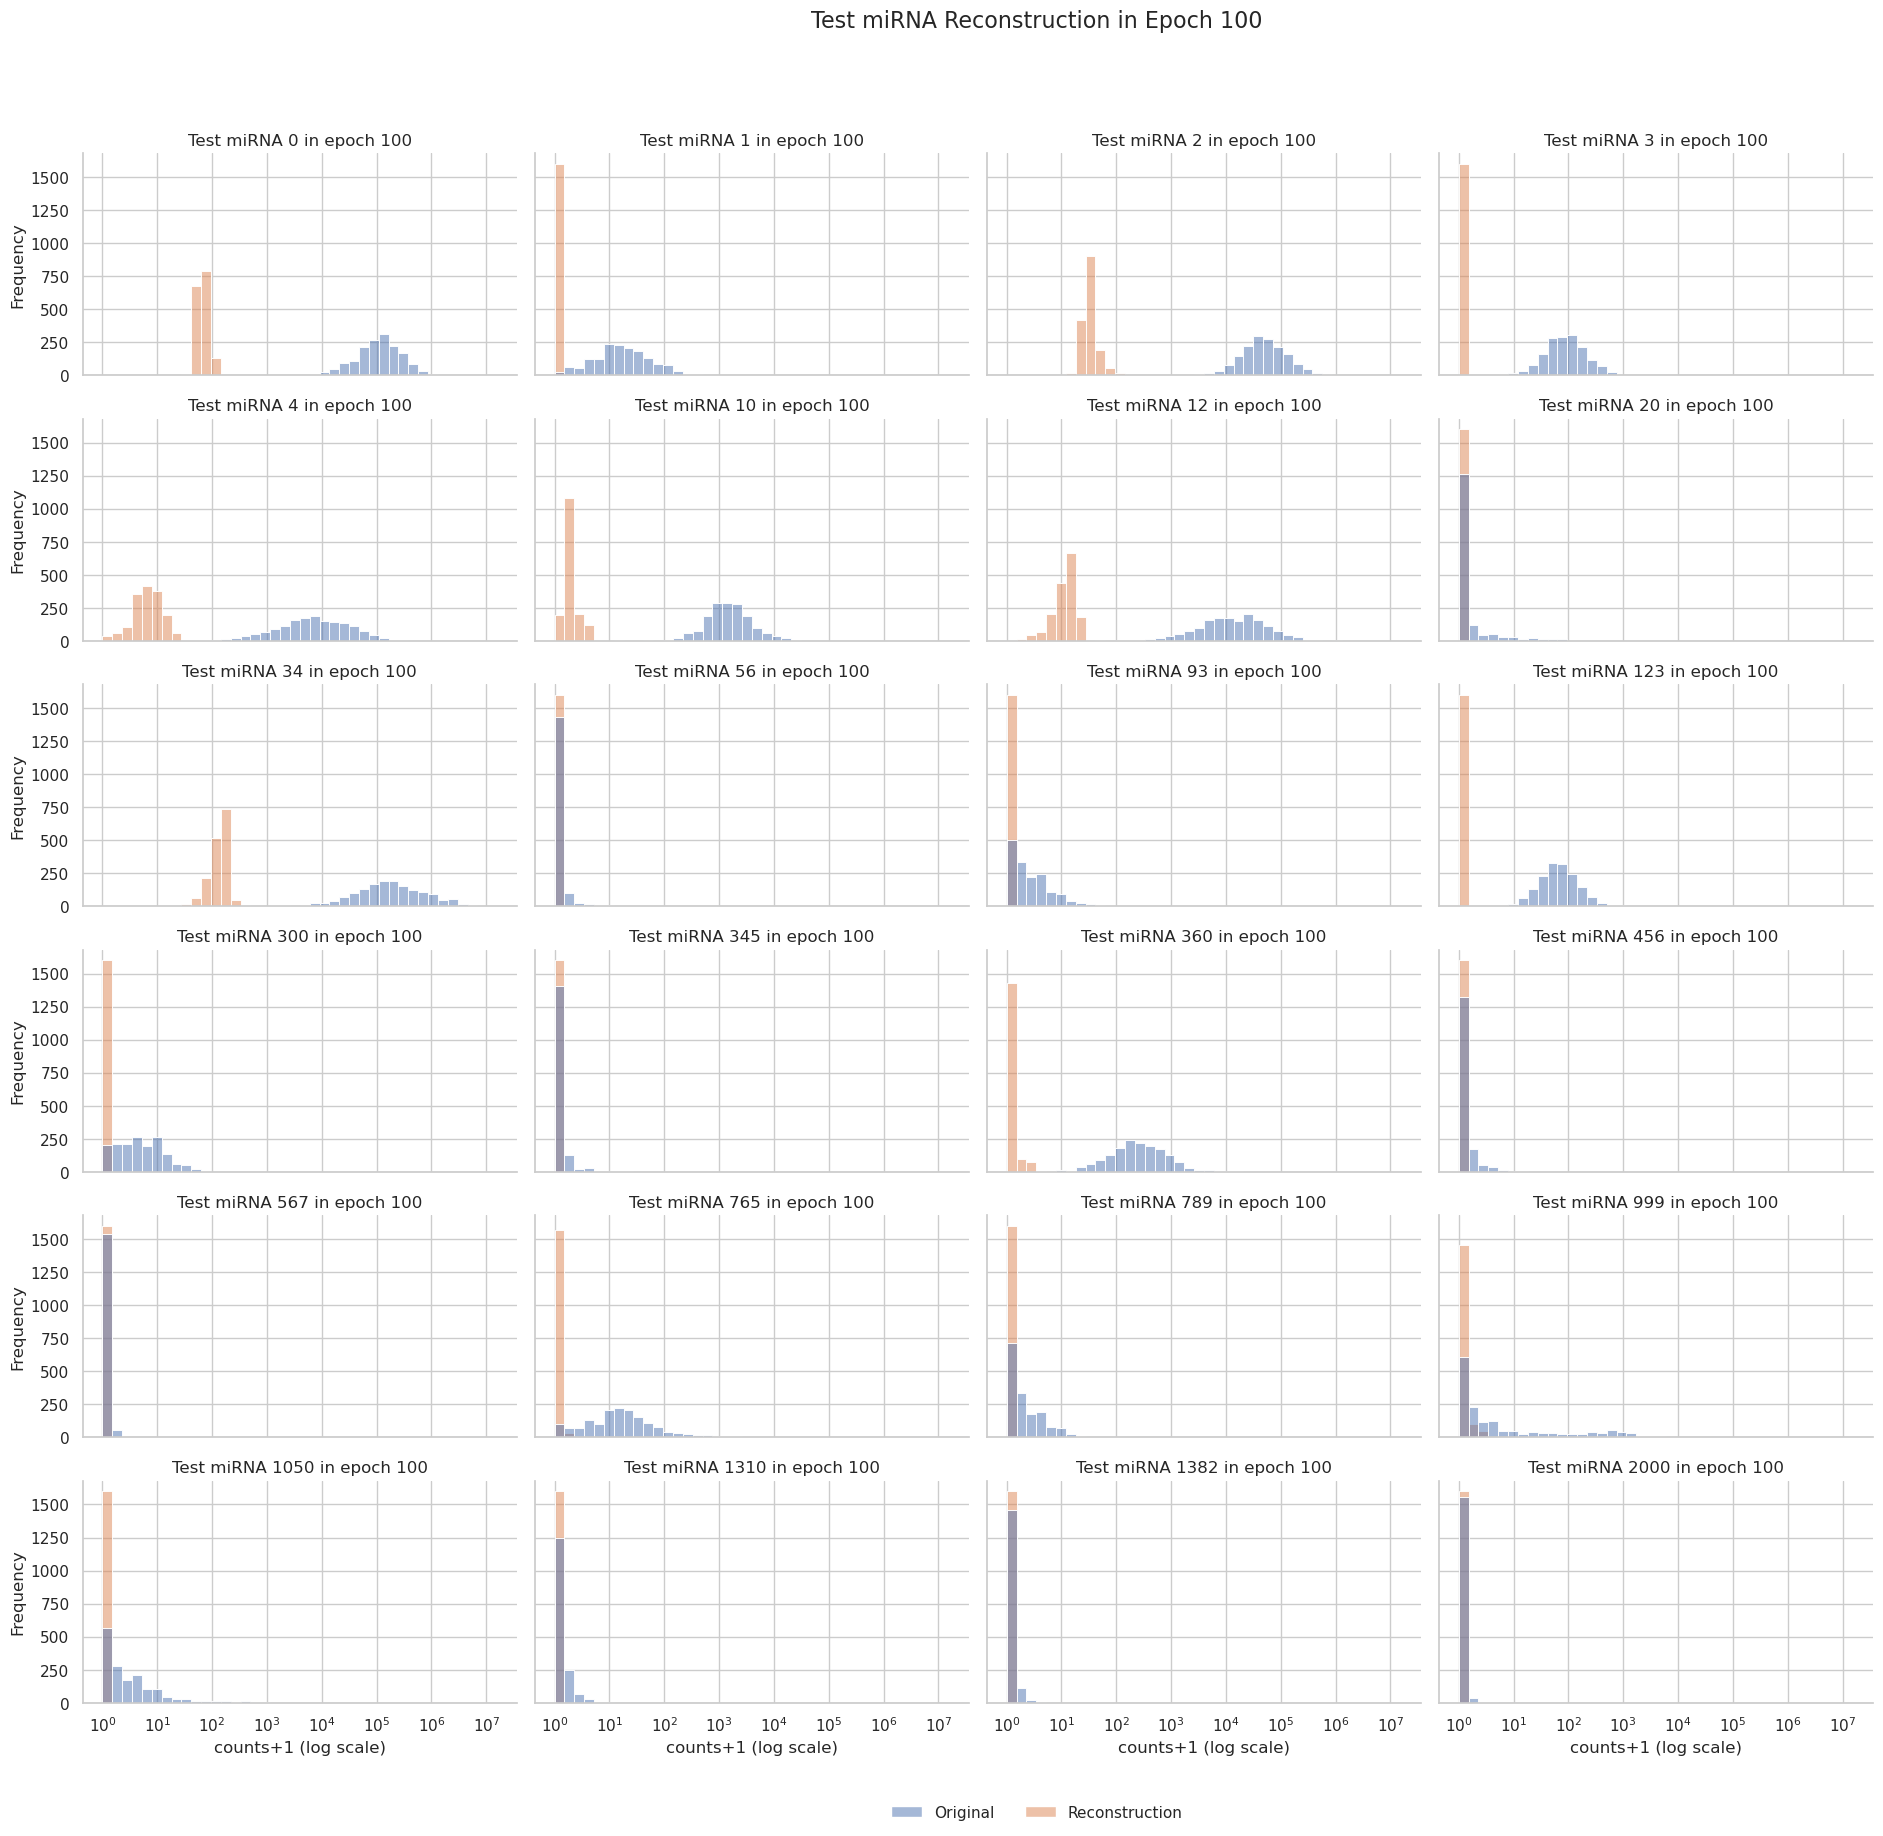

 35%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 106/301 [06:06<15:52,  4.88s/it]

105 train_recon: 1.851835310799709 train_gmm: 2.161673989251932 train_mse: 28042452.0 train_mae: 908.3330078125 train_r2: 0.2730417847633362 train_spearman: 0.4421677589416504 train_pearson: 0.8534967303276062 train_expl_var: 0.29057538509368896 train_msle: 1.9819316864013672
105 test_recon: 1.8467944559492833 test_gmm: 2.161973214372853 test_mse: 15714789.0 test_mae: 657.4940795898438 test_r2: 0.34084397554397583 test_spearman: 0.41670504212379456 test_pearson: 0.8674986362457275 test_expl_var: 0.3557444214820862 test_msle: 1.575941562652588


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 111/301 [06:17<08:28,  2.68s/it]

110 train_recon: 1.8471134795738968 train_gmm: 2.161868893380754 train_mse: 27171042.0 train_mae: 891.0795288085938 train_r2: 0.2956318259239197 train_spearman: 0.448103129863739 train_pearson: 0.8566234707832336 train_expl_var: 0.31221503019332886 train_msle: 2.1874473094940186
110 test_recon: 1.8417651854741848 test_gmm: 2.162294737358975 test_mse: 15130666.0 test_mae: 647.3648681640625 test_r2: 0.3653450012207031 test_spearman: 0.42238855361938477 test_pearson: 0.8728974461555481 test_expl_var: 0.37930309772491455 test_msle: 1.8350476026535034


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 116/301 [06:28<06:59,  2.27s/it]

115 train_recon: 1.8422063995601556 train_gmm: 2.1620882965132813 train_mse: 26907806.0 train_mae: 883.0280151367188 train_r2: 0.3024557828903198 train_spearman: 0.45503872632980347 train_pearson: 0.8588151335716248 train_expl_var: 0.31884753704071045 train_msle: 2.2279789447784424
115 test_recon: 1.8371485780101617 test_gmm: 2.1625390076026703 test_mse: 14961586.0 test_mae: 644.172607421875 test_r2: 0.372437059879303 test_spearman: 0.4306894838809967 test_pearson: 0.877217710018158 test_expl_var: 0.386165976524353 test_msle: 1.8701788187026978


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 121/301 [06:40<06:44,  2.25s/it]

120 train_recon: 1.8374985339184173 train_gmm: 2.162261455693622 train_mse: 27104474.0 train_mae: 880.416259765625 train_r2: 0.2973574995994568 train_spearman: 0.4605883061885834 train_pearson: 0.8646929264068604 train_expl_var: 0.31430959701538086 train_msle: 2.0556130409240723
120 test_recon: 1.8326691343092756 test_gmm: 2.162894757548993 test_mse: 14981281.0 test_mae: 641.8739624023438 test_r2: 0.37161093950271606 test_spearman: 0.4367271661758423 test_pearson: 0.8784615993499756 test_expl_var: 0.38557302951812744 test_msle: 1.733514666557312


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 126/301 [06:51<06:30,  2.23s/it]

125 train_recon: 1.8326770015005271 train_gmm: 2.1623161088251037 train_mse: 26947866.0 train_mae: 872.323486328125 train_r2: 0.3014172911643982 train_spearman: 0.4687170088291168 train_pearson: 0.8679240942001343 train_expl_var: 0.31838828325271606 train_msle: 1.962323784828186
125 test_recon: 1.8281736674351874 test_gmm: 2.1627725042453934 test_mse: 14664969.0 test_mae: 629.2001953125 test_r2: 0.38487863540649414 test_spearman: 0.4492488205432892 test_pearson: 0.8785281777381897 test_expl_var: 0.39848053455352783 test_msle: 1.68411386013031


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 131/301 [07:02<06:15,  2.21s/it]

130 train_recon: 1.8280887291499068 train_gmm: 2.1624072017335325 train_mse: 26326658.0 train_mae: 858.134765625 train_r2: 0.31752121448516846 train_spearman: 0.47103145718574524 train_pearson: 0.8700621724128723 train_expl_var: 0.33381855487823486 train_msle: 2.16267728805542
130 test_recon: 1.8237962888884294 test_gmm: 2.1630943169674226 test_mse: 14240362.0 test_mae: 622.605712890625 test_r2: 0.40268874168395996 test_spearman: 0.45304930210113525 test_pearson: 0.8766466975212097 test_expl_var: 0.4153570532798767 test_msle: 1.957825779914856


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 136/301 [07:13<06:12,  2.26s/it]

135 train_recon: 1.823710520092359 train_gmm: 2.16255273542043 train_mse: 26480762.0 train_mae: 850.4220581054688 train_r2: 0.3135262727737427 train_spearman: 0.47328096628189087 train_pearson: 0.8708480596542358 train_expl_var: 0.3304755687713623 train_msle: 1.6117122173309326
135 test_recon: 1.8193347440797871 test_gmm: 2.1632160899193864 test_mse: 14543121.0 test_mae: 619.0309448242188 test_r2: 0.38998955488204956 test_spearman: 0.4531704783439636 test_pearson: 0.8723180890083313 test_expl_var: 0.40359628200531006 test_msle: 1.3392484188079834


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 141/301 [07:24<05:58,  2.24s/it]

140 train_recon: 1.819577269176942 train_gmm: 2.162544251100838 train_mse: 25789512.0 train_mae: 834.23291015625 train_r2: 0.33144593238830566 train_spearman: 0.4724820852279663 train_pearson: 0.871863603591919 train_expl_var: 0.3476308584213257 train_msle: 1.747496247291565
140 test_recon: 1.8159140979698953 test_gmm: 2.162925355185724 test_mse: 14117702.0 test_mae: 604.5037841796875 test_r2: 0.40783369541168213 test_spearman: 0.45724207162857056 test_pearson: 0.8736212253570557 test_expl_var: 0.4207146167755127 test_msle: 1.498060941696167


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 146/301 [07:36<05:47,  2.24s/it]

145 train_recon: 1.8157185965820828 train_gmm: 2.162654481916148 train_mse: 25489920.0 train_mae: 824.7572631835938 train_r2: 0.3392123579978943 train_spearman: 0.4763975143432617 train_pearson: 0.8765669465065002 train_expl_var: 0.35533905029296875 train_msle: 1.523665428161621
145 test_recon: 1.8119528590240042 test_gmm: 2.162895100657304 test_mse: 13832583.0 test_mae: 592.7785034179688 test_r2: 0.4197930097579956 test_spearman: 0.45067185163497925 test_pearson: 0.8768262267112732 test_expl_var: 0.4324039816856384 test_msle: 1.3657829761505127


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 150/301 [07:44<05:36,  2.23s/it]

150 train_recon: 1.8116964670475106 train_gmm: 2.1626361885208625 train_mse: 25308852.0 train_mae: 817.91015625 train_r2: 0.3439062833786011 train_spearman: 0.4751315414905548 train_pearson: 0.8775898218154907 train_expl_var: 0.36000198125839233 train_msle: 1.3456534147262573
150 test_recon: 1.8080337683047034 test_gmm: 2.163047318753416 test_mse: 13710602.0 test_mae: 588.288330078125 test_r2: 0.42490947246551514 test_spearman: 0.4519799053668976 test_pearson: 0.8812968730926514 test_expl_var: 0.4375606179237366 test_msle: 1.2425265312194824


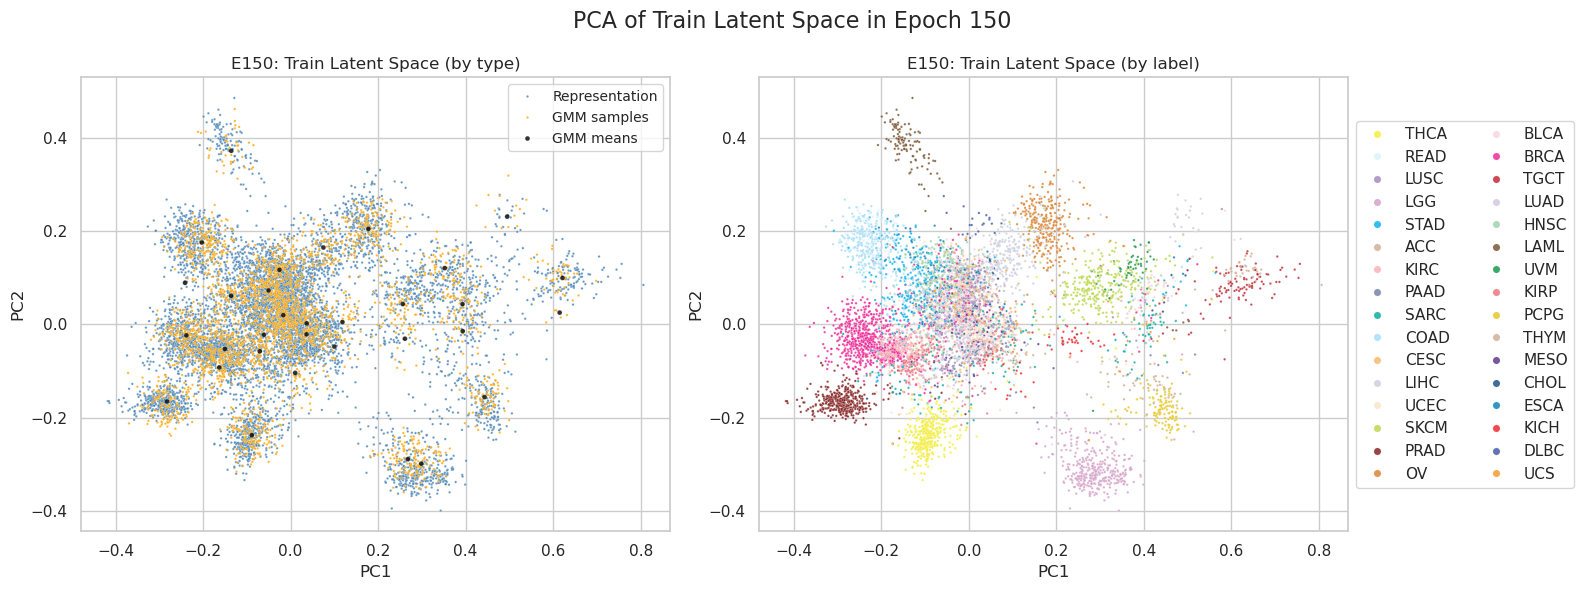

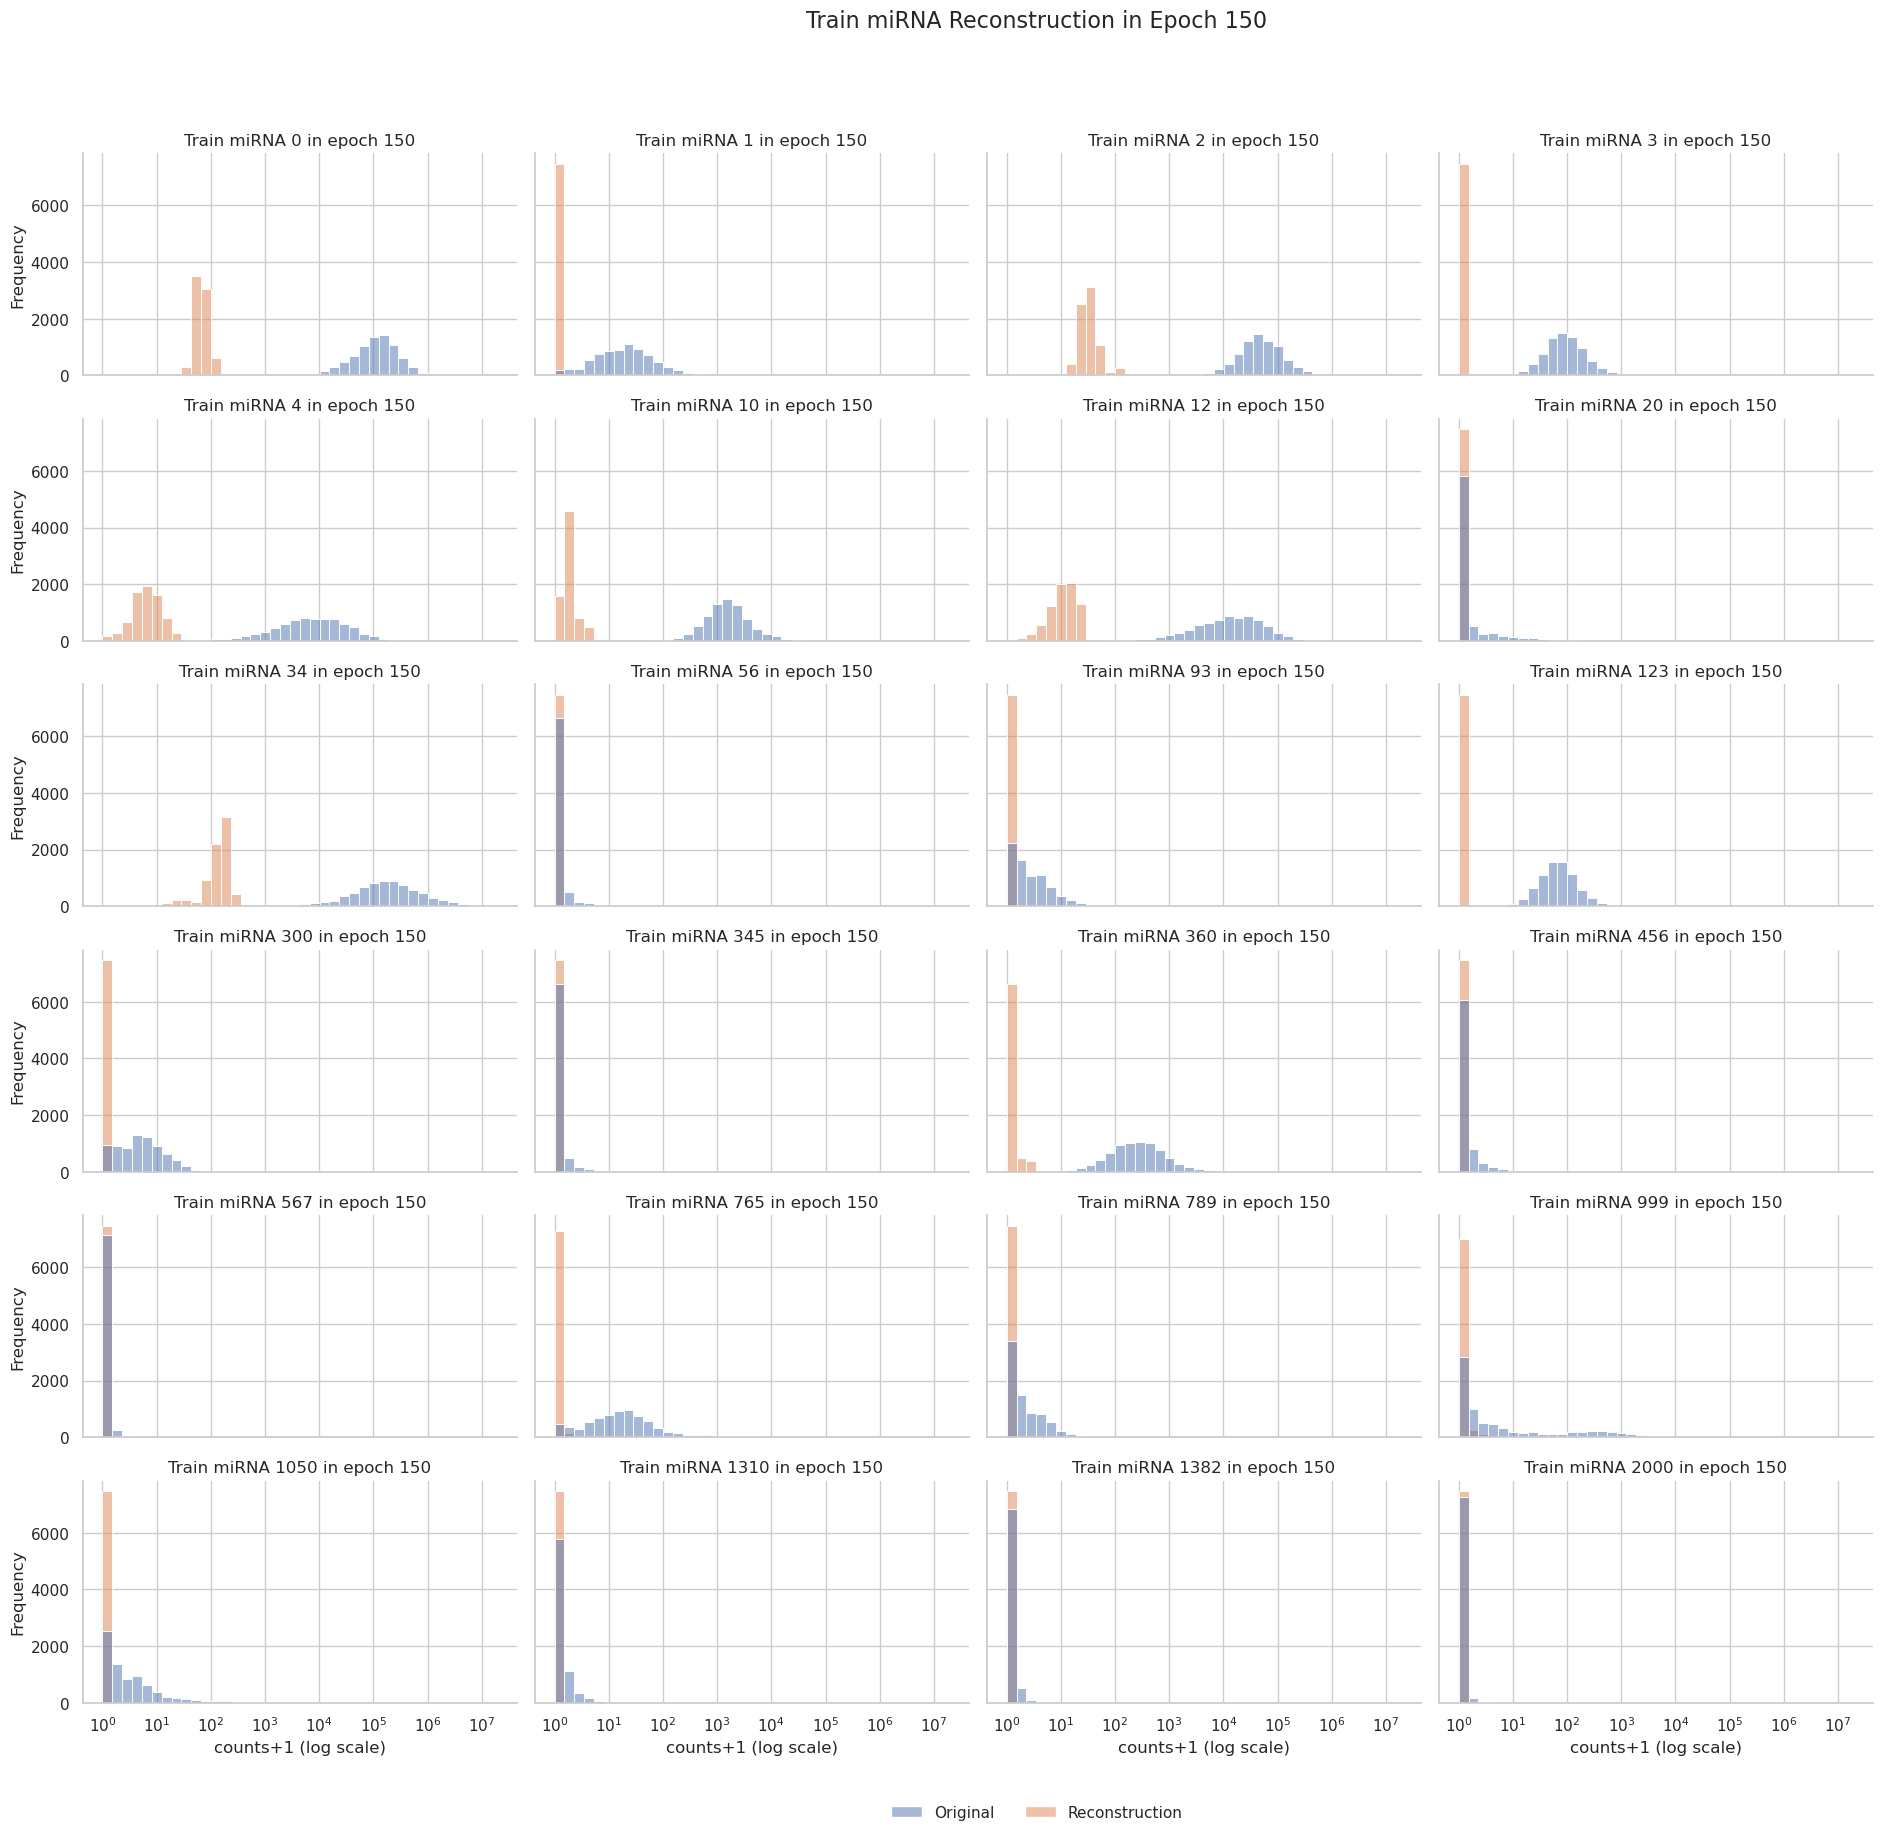

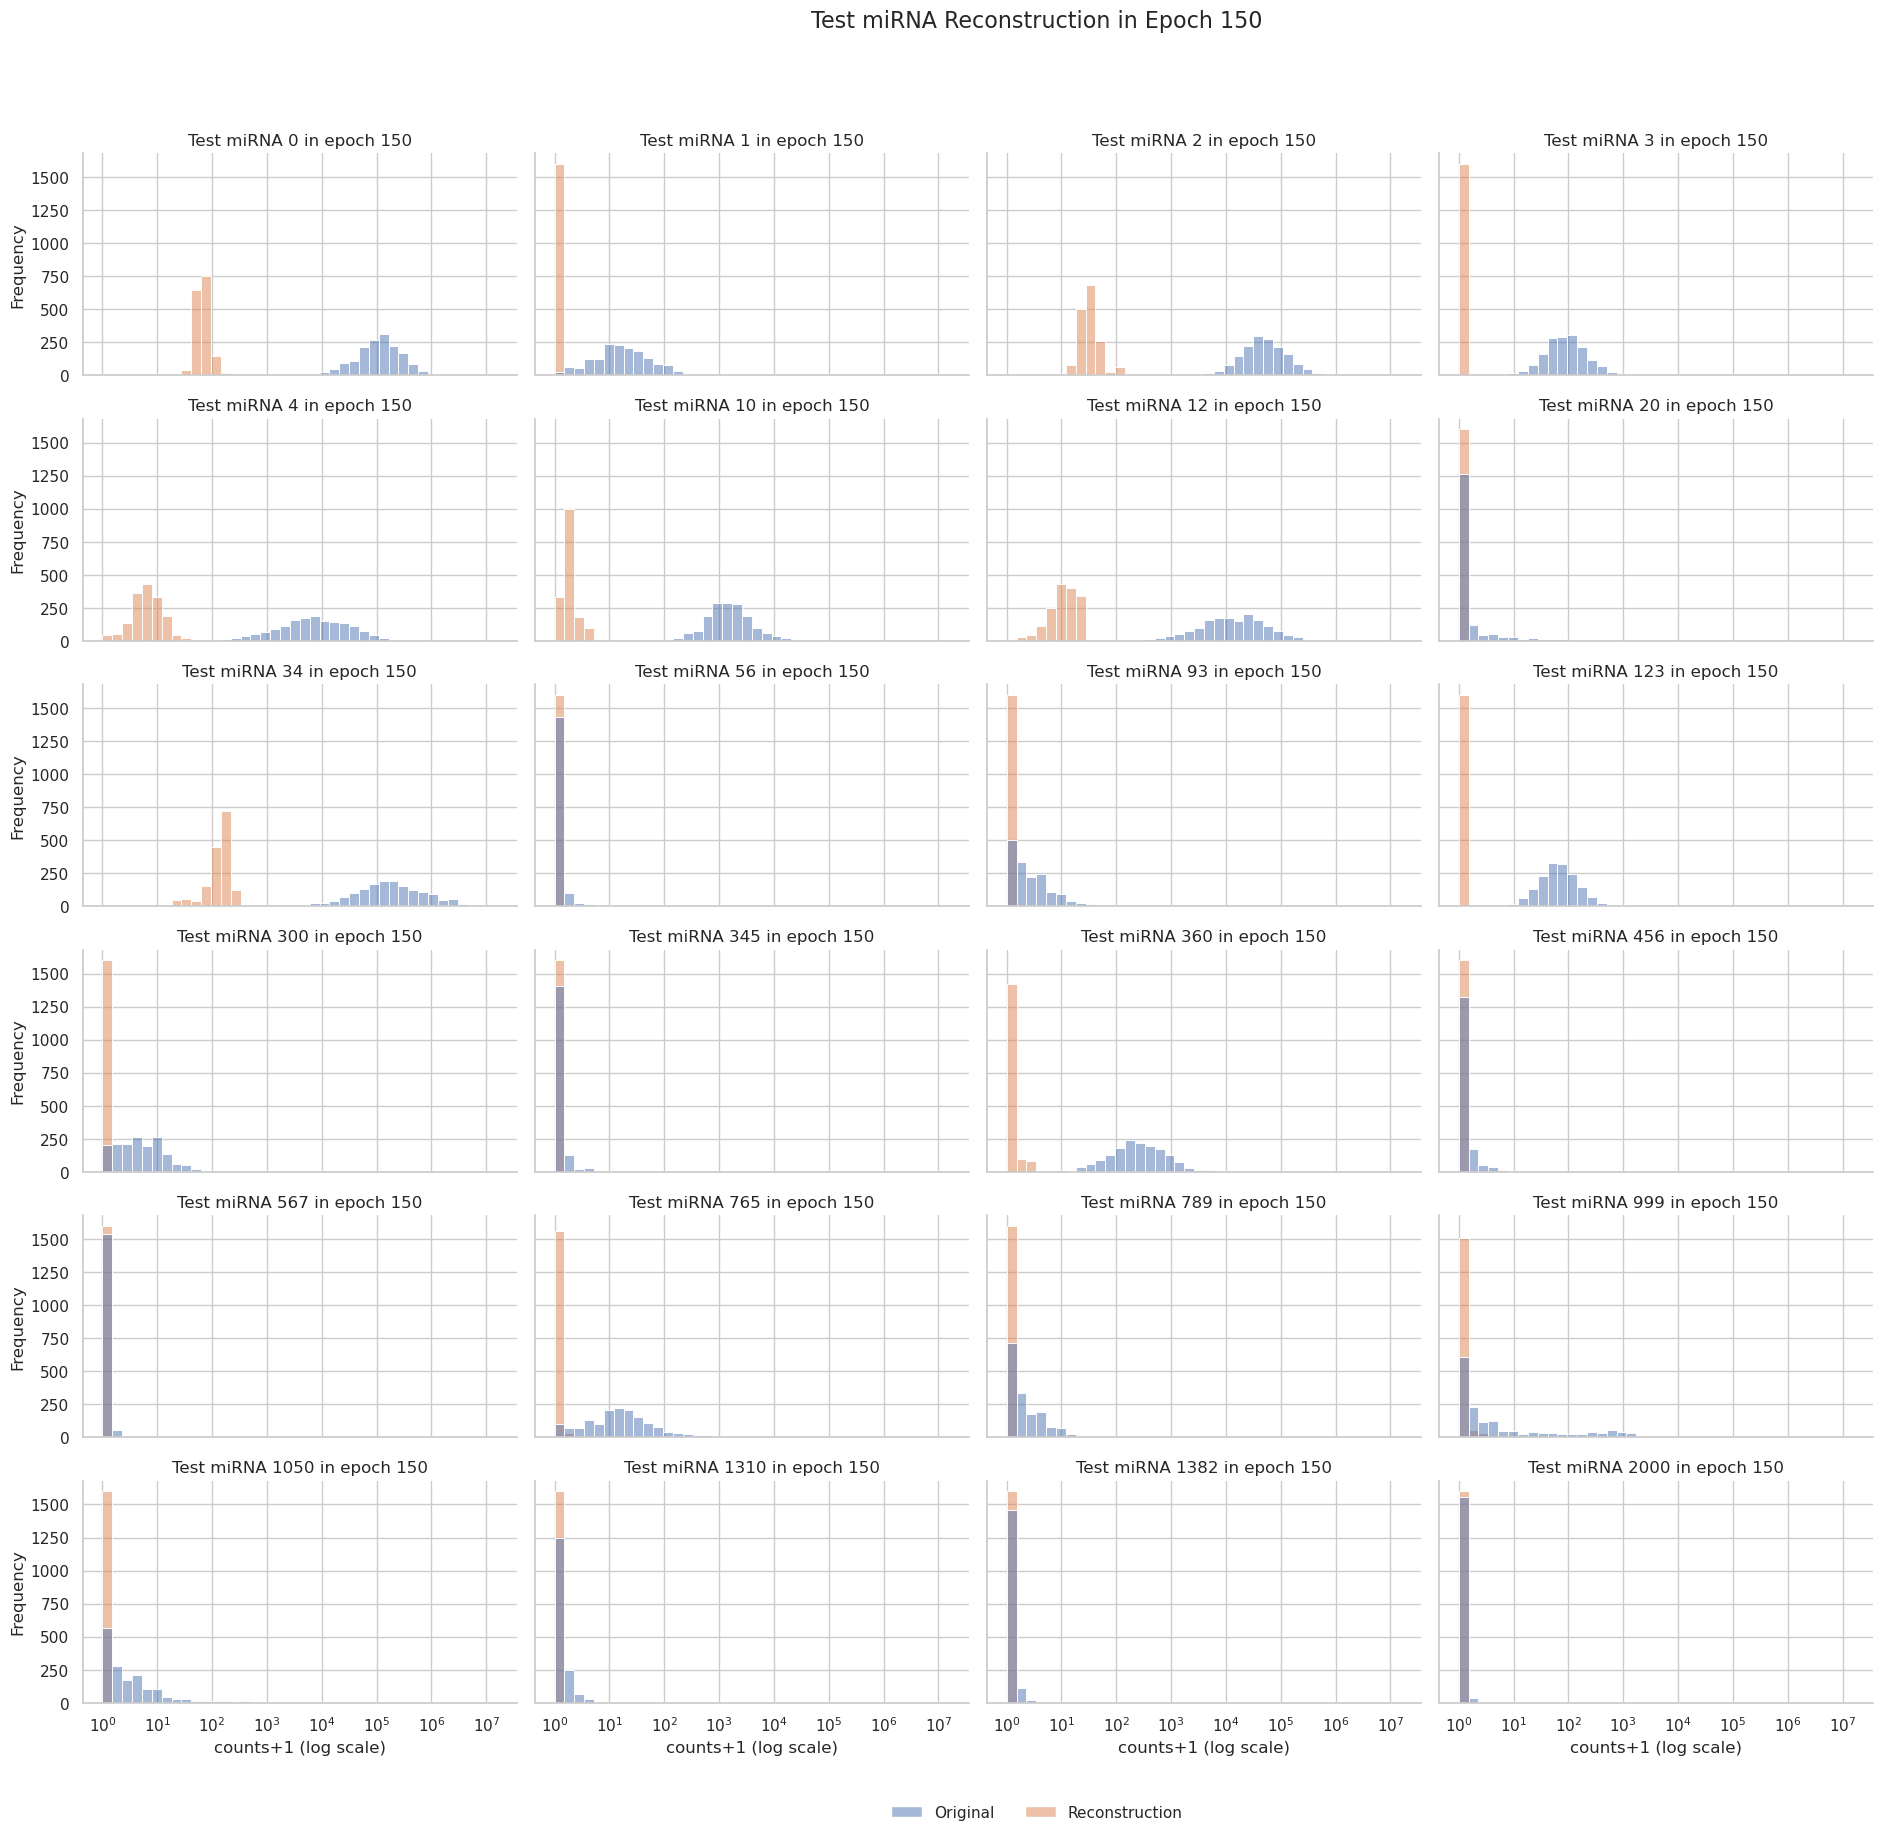

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 156/301 [08:51<12:06,  5.01s/it]

155 train_recon: 1.808012133370516 train_gmm: 2.1626140303007495 train_mse: 25007452.0 train_mae: 809.6604614257812 train_r2: 0.35171955823898315 train_spearman: 0.4761725664138794 train_pearson: 0.8789509534835815 train_expl_var: 0.3675990700721741 train_msle: 1.271685242652893
155 test_recon: 1.8038658386217359 test_gmm: 2.162858555809845 test_mse: 13457987.0 test_mae: 579.2152709960938 test_r2: 0.4355054497718811 test_spearman: 0.451240599155426 test_pearson: 0.884286105632782 test_expl_var: 0.44791895151138306 test_msle: 1.1250375509262085


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 161/301 [09:03<06:34,  2.82s/it]

160 train_recon: 1.8048422236718855 train_gmm: 2.1626287071608834 train_mse: 24876466.0 train_mae: 805.2053833007812 train_r2: 0.35511523485183716 train_spearman: 0.4789603054523468 train_pearson: 0.8794012069702148 train_expl_var: 0.3709038496017456 train_msle: 1.1716282367706299
160 test_recon: 1.8033005383709046 test_gmm: 2.1627045535505154 test_mse: 13392403.0 test_mae: 575.8551025390625 test_r2: 0.43825632333755493 test_spearman: 0.4495137631893158 test_pearson: 0.882526159286499 test_expl_var: 0.4506024718284607 test_msle: 1.0651203393936157


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 166/301 [09:15<05:28,  2.44s/it]

165 train_recon: 1.801767259077673 train_gmm: 2.1624928388030242 train_mse: 24506160.0 train_mae: 797.0188598632812 train_r2: 0.3647148609161377 train_spearman: 0.48079225420951843 train_pearson: 0.8794245719909668 train_expl_var: 0.3801068663597107 train_msle: 1.223455548286438
165 test_recon: 1.7990187829200746 test_gmm: 2.1626551764522173 test_mse: 13097049.0 test_mae: 570.0540771484375 test_r2: 0.45064496994018555 test_spearman: 0.45250532031059265 test_pearson: 0.8868407607078552 test_expl_var: 0.4625331163406372 test_msle: 1.088390827178955


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 171/301 [09:27<05:11,  2.39s/it]

170 train_recon: 1.7989796503992106 train_gmm: 2.1624812704642964 train_mse: 24549182.0 train_mae: 796.864013671875 train_r2: 0.36359959840774536 train_spearman: 0.4821534752845764 train_pearson: 0.8807652592658997 train_expl_var: 0.3791208863258362 train_msle: 1.0648517608642578
170 test_recon: 1.7950198704706544 test_gmm: 2.1624223355275998 test_mse: 13041905.0 test_mae: 567.797119140625 test_r2: 0.45295798778533936 test_spearman: 0.4568586051464081 test_pearson: 0.8855242133140564 test_expl_var: 0.4647441506385803 test_msle: 1.0359952449798584


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 176/301 [09:39<05:00,  2.41s/it]

175 train_recon: 1.7964378056292507 train_gmm: 2.1622281293385353 train_mse: 24266656.0 train_mae: 791.1787109375 train_r2: 0.37092363834381104 train_spearman: 0.4816782772541046 train_pearson: 0.8797779083251953 train_expl_var: 0.3861114978790283 train_msle: 1.1122980117797852
175 test_recon: 1.7932839431275043 test_gmm: 2.1624654451807466 test_mse: 12910442.0 test_mae: 563.9771118164062 test_r2: 0.45847219228744507 test_spearman: 0.4532015025615692 test_pearson: 0.8866657018661499 test_expl_var: 0.4701099991798401 test_msle: 1.0018302202224731


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 181/301 [09:51<04:45,  2.38s/it]

180 train_recon: 1.7942301958493263 train_gmm: 2.1622171686561202 train_mse: 24157728.0 train_mae: 788.4198608398438 train_r2: 0.37374740839004517 train_spearman: 0.48078346252441406 train_pearson: 0.878206193447113 train_expl_var: 0.3888026475906372 train_msle: 1.1076864004135132
180 test_recon: 1.7915871213921388 test_gmm: 2.1624471460708152 test_mse: 12829313.0 test_mae: 561.779541015625 test_r2: 0.4618750810623169 test_spearman: 0.45159095525741577 test_pearson: 0.8837404251098633 test_expl_var: 0.47331351041793823 test_msle: 1.03786301612854


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 186/301 [10:02<04:29,  2.35s/it]

185 train_recon: 1.7920615190476228 train_gmm: 2.1619149837853775 train_mse: 23994610.0 train_mae: 785.2996215820312 train_r2: 0.3779760003089905 train_spearman: 0.48844480514526367 train_pearson: 0.8794431090354919 train_expl_var: 0.39291441440582275 train_msle: 1.0866423845291138
185 test_recon: 1.7893326421172044 test_gmm: 2.1619471915136046 test_mse: 12711252.0 test_mae: 559.1199340820312 test_r2: 0.4668271541595459 test_spearman: 0.4547208845615387 test_pearson: 0.883912980556488 test_expl_var: 0.4780190587043762 test_msle: 1.0468599796295166


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 191/301 [10:14<04:19,  2.36s/it]

190 train_recon: 1.7900571669340324 train_gmm: 2.1617074397518565 train_mse: 23709798.0 train_mae: 780.499755859375 train_r2: 0.38535934686660767 train_spearman: 0.4841676354408264 train_pearson: 0.8795965909957886 train_expl_var: 0.39994728565216064 train_msle: 1.169681191444397
190 test_recon: 1.7866413517567454 test_gmm: 2.1618805598795676 test_mse: 12531422.0 test_mae: 555.7686767578125 test_r2: 0.4743701219558716 test_spearman: 0.4548180401325226 test_pearson: 0.8811964988708496 test_expl_var: 0.4851565361022949 test_msle: 1.1458650827407837


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 196/301 [10:26<04:09,  2.38s/it]

195 train_recon: 1.7884640387212145 train_gmm: 2.161468570382021 train_mse: 23711660.0 train_mae: 779.548095703125 train_r2: 0.3853110671043396 train_spearman: 0.48576393723487854 train_pearson: 0.8799939155578613 train_expl_var: 0.39996302127838135 train_msle: 1.0981656312942505
195 test_recon: 1.7853171857293983 test_gmm: 2.161771847917317 test_mse: 12472331.0 test_mae: 553.4735107421875 test_r2: 0.4768487215042114 test_spearman: 0.4543391764163971 test_pearson: 0.8827840089797974 test_expl_var: 0.4876013994216919 test_msle: 1.1244382858276367


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 200/301 [10:36<03:59,  2.37s/it]

200 train_recon: 1.7866005676264591 train_gmm: 2.161407812918172 train_mse: 23804650.0 train_mae: 781.309326171875 train_r2: 0.3829004168510437 train_spearman: 0.4821878671646118 train_pearson: 0.8801196217536926 train_expl_var: 0.3976879119873047 train_msle: 1.0077699422836304
200 test_recon: 1.7843339183776568 test_gmm: 2.161505816982062 test_mse: 12639863.0 test_mae: 558.06787109375 test_r2: 0.46982163190841675 test_spearman: 0.45753705501556396 test_pearson: 0.8803405165672302 test_expl_var: 0.480859637260437 test_msle: 0.990265965461731


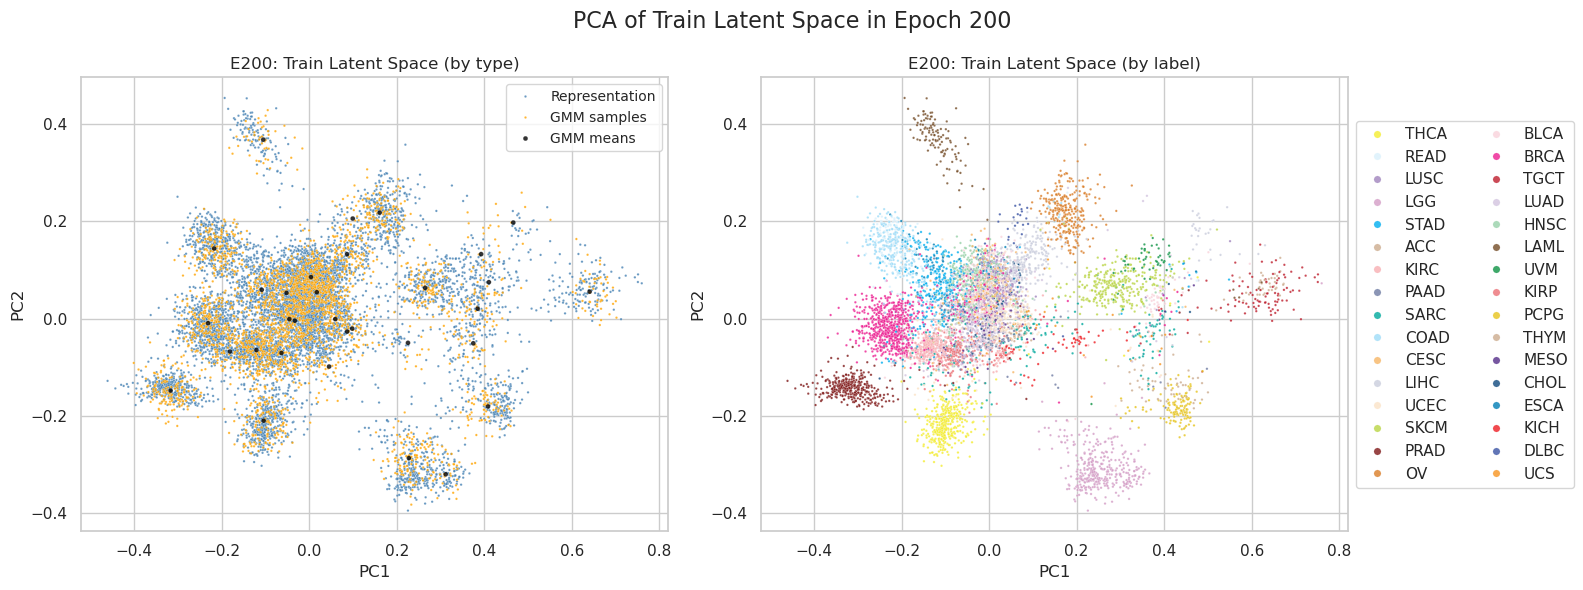

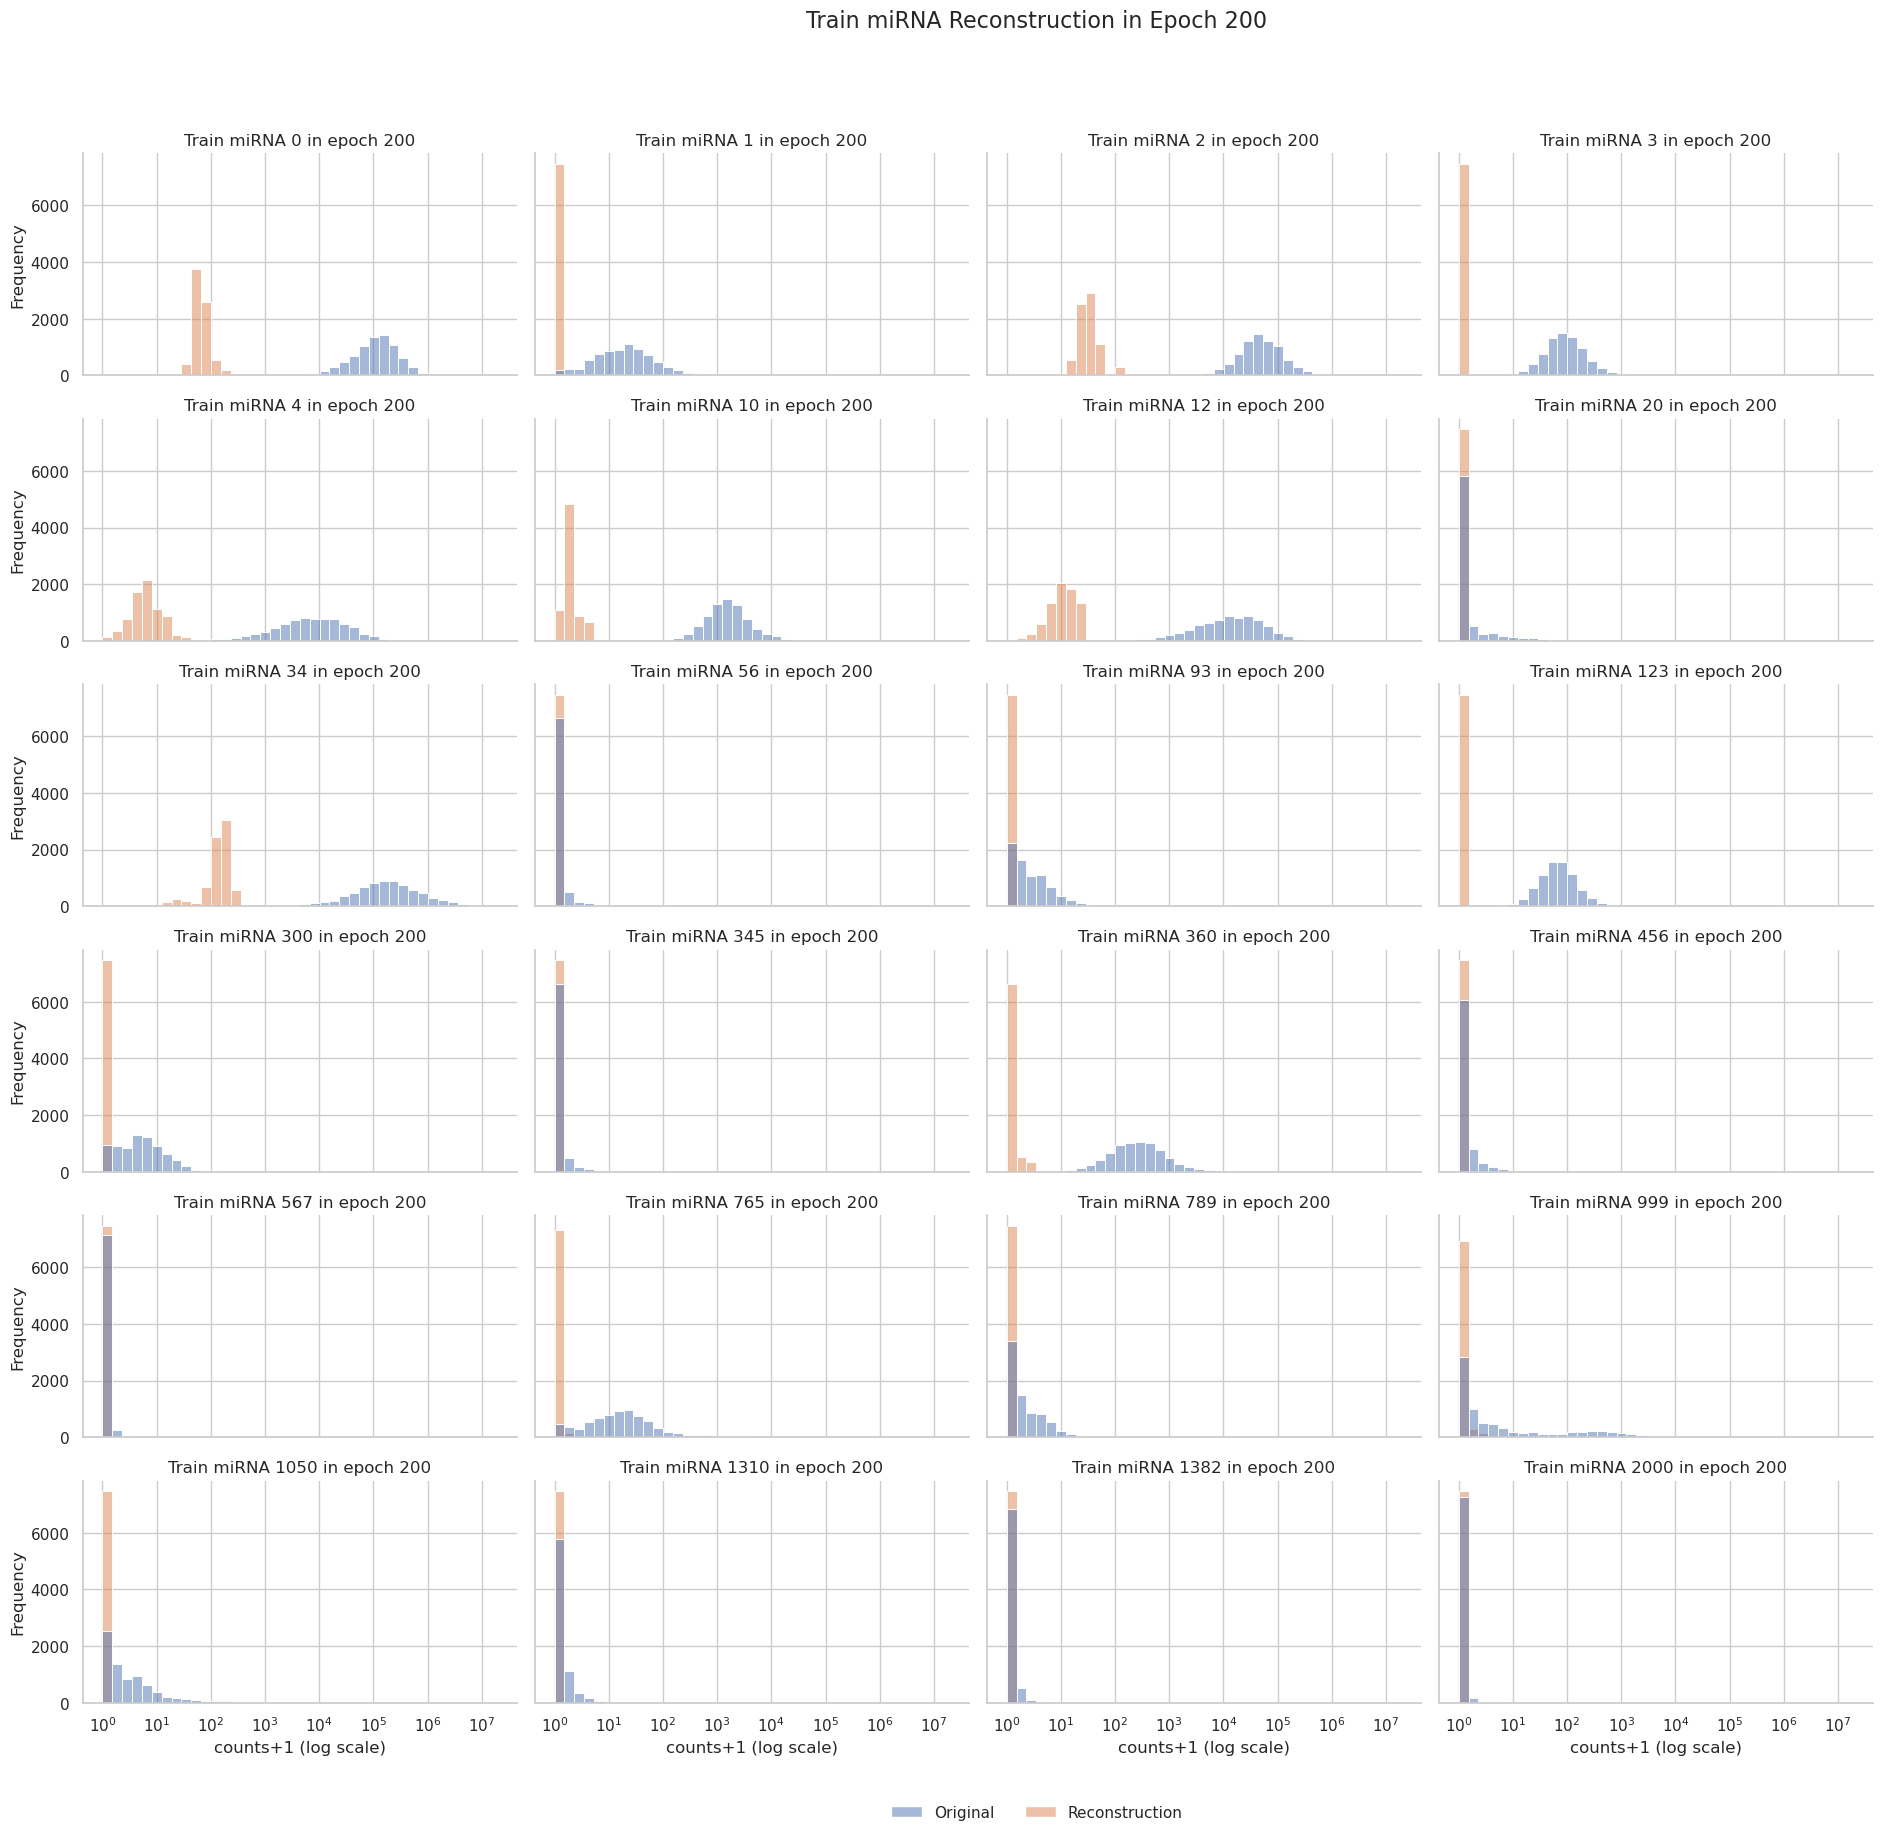

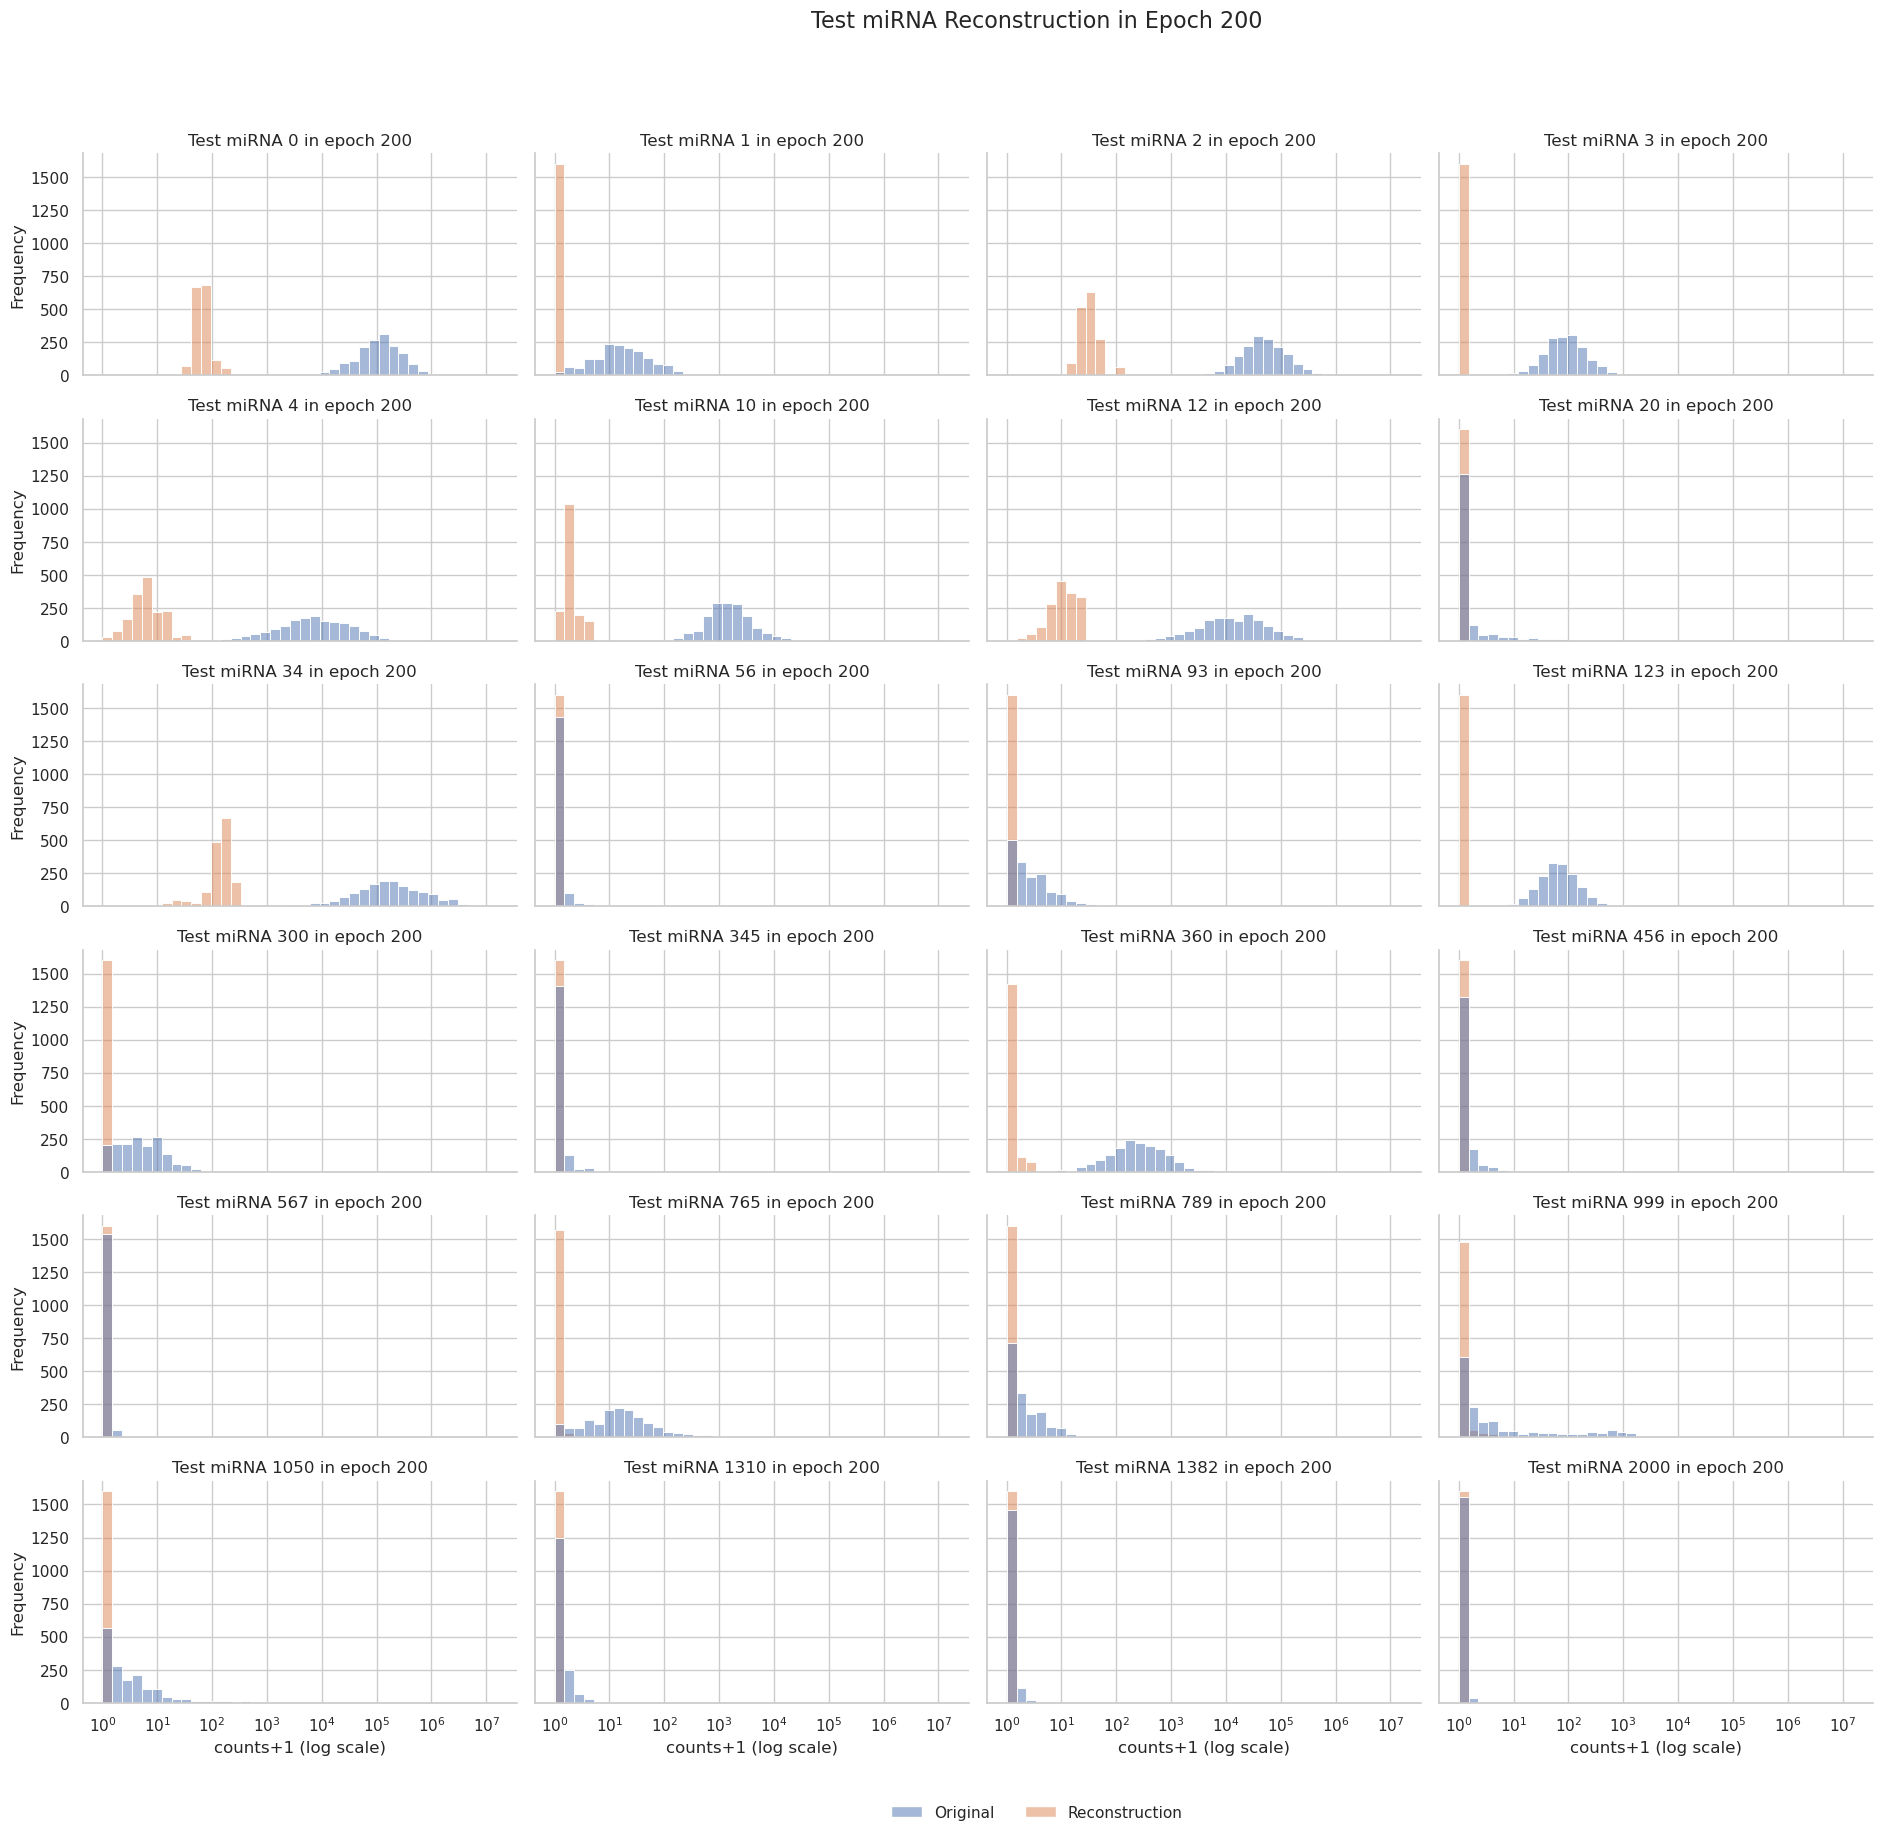

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 206/301 [11:42<08:00,  5.06s/it]

205 train_recon: 1.7848556970773308 train_gmm: 2.16139918648541 train_mse: 23467058.0 train_mae: 775.609619140625 train_r2: 0.39165198802948 train_spearman: 0.4808003008365631 train_pearson: 0.881064772605896 train_expl_var: 0.40602409839630127 train_msle: 1.1374311447143555
205 test_recon: 1.782869811172859 test_gmm: 2.1616094280674187 test_mse: 12324322.0 test_mae: 551.1200561523438 test_r2: 0.4830569624900818 test_spearman: 0.454813152551651 test_pearson: 0.8802581429481506 test_expl_var: 0.4934549927711487 test_msle: 1.1479989290237427


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 211/301 [11:54<04:14,  2.83s/it]

210 train_recon: 1.7829596761202648 train_gmm: 2.16140589847409 train_mse: 23194182.0 train_mae: 771.5942993164062 train_r2: 0.39872586727142334 train_spearman: 0.481440007686615 train_pearson: 0.8805414438247681 train_expl_var: 0.4127052426338196 train_msle: 1.3254673480987549
210 test_recon: 1.7819087486699272 test_gmm: 2.161661580530723 test_mse: 12202755.0 test_mae: 549.1233520507812 test_r2: 0.4881560802459717 test_spearman: 0.4533543288707733 test_pearson: 0.8773771524429321 test_expl_var: 0.49817872047424316 test_msle: 1.3047659397125244


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 216/301 [12:06<03:32,  2.50s/it]

215 train_recon: 1.7809945100781788 train_gmm: 2.1615937034783554 train_mse: 23551124.0 train_mae: 776.8892822265625 train_r2: 0.38947272300720215 train_spearman: 0.480250746011734 train_pearson: 0.8824062347412109 train_expl_var: 0.40402644872665405 train_msle: 1.0250434875488281
215 test_recon: 1.7796742609917715 test_gmm: 2.1616401629474744 test_mse: 12445867.0 test_mae: 554.6531982421875 test_r2: 0.4779587388038635 test_spearman: 0.4535300135612488 test_pearson: 0.8784436583518982 test_expl_var: 0.48856568336486816 test_msle: 1.0265119075775146


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 221/301 [12:19<03:16,  2.45s/it]

220 train_recon: 1.7791020975082101 train_gmm: 2.1615932036320338 train_mse: 23324368.0 train_mae: 771.7266845703125 train_r2: 0.3953510522842407 train_spearman: 0.47716277837753296 train_pearson: 0.8827267289161682 train_expl_var: 0.4096255898475647 train_msle: 1.1180232763290405
220 test_recon: 1.7772823865025071 test_gmm: 2.161729119495628 test_mse: 12278783.0 test_mae: 548.4529418945312 test_r2: 0.48496711254119873 test_spearman: 0.4538519084453583 test_pearson: 0.8802300691604614 test_expl_var: 0.49534547328948975 test_msle: 1.0355286598205566


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 226/301 [12:31<03:02,  2.44s/it]

225 train_recon: 1.777252431877288 train_gmm: 2.1616748468314055 train_mse: 23228130.0 train_mae: 769.9114990234375 train_r2: 0.3978458046913147 train_spearman: 0.47870293259620667 train_pearson: 0.8822410106658936 train_expl_var: 0.41196125745773315 train_msle: 1.206709623336792
225 test_recon: 1.7768869521395965 test_gmm: 2.1616555570737037 test_mse: 12288171.0 test_mae: 550.5513305664062 test_r2: 0.4845733046531677 test_spearman: 0.45616039633750916 test_pearson: 0.8782317638397217 test_expl_var: 0.49477845430374146 test_msle: 1.227143406867981


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 231/301 [12:43<02:53,  2.48s/it]

230 train_recon: 1.7755632211898276 train_gmm: 2.1616882397725563 train_mse: 23548528.0 train_mae: 775.32861328125 train_r2: 0.38954001665115356 train_spearman: 0.4791490137577057 train_pearson: 0.8829007744789124 train_expl_var: 0.4041129946708679 train_msle: 0.9939966797828674
230 test_recon: 1.7750363551961101 test_gmm: 2.161660215722107 test_mse: 12443267.0 test_mae: 551.9681396484375 test_r2: 0.4780678153038025 test_spearman: 0.4576893746852875 test_pearson: 0.8834418058395386 test_expl_var: 0.48886579275131226 test_msle: 0.9166877865791321


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 236/301 [12:55<02:39,  2.45s/it]

235 train_recon: 1.773780704822605 train_gmm: 2.1616305434590566 train_mse: 23515812.0 train_mae: 774.280029296875 train_r2: 0.3903881311416626 train_spearman: 0.483439177274704 train_pearson: 0.8819287419319153 train_expl_var: 0.4049035310745239 train_msle: 1.0304166078567505
235 test_recon: 1.7724189025880563 test_gmm: 2.161678819817204 test_mse: 12462815.0 test_mae: 551.5745849609375 test_r2: 0.4772478938102722 test_spearman: 0.46521422266960144 test_pearson: 0.8828946352005005 test_expl_var: 0.48808372020721436 test_msle: 0.9777573347091675


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 241/301 [13:08<02:28,  2.48s/it]

240 train_recon: 1.771983657801815 train_gmm: 2.1616951951504584 train_mse: 23386388.0 train_mae: 772.1678466796875 train_r2: 0.39374321699142456 train_spearman: 0.4839298129081726 train_pearson: 0.8834410905838013 train_expl_var: 0.408105731010437 train_msle: 1.1042330265045166
240 test_recon: 1.77121859188026 test_gmm: 2.161745855556586 test_mse: 12436969.0 test_mae: 551.3486938476562 test_r2: 0.478331983089447 test_spearman: 0.4582558870315552 test_pearson: 0.8837034106254578 test_expl_var: 0.48907697200775146 test_msle: 1.0023807287216187


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/301 [13:20<02:15,  2.47s/it]

245 train_recon: 1.7702174964258683 train_gmm: 2.16181708577964 train_mse: 23500026.0 train_mae: 773.8736572265625 train_r2: 0.39079731702804565 train_spearman: 0.4847615361213684 train_pearson: 0.8844643831253052 train_expl_var: 0.40533608198165894 train_msle: 1.0170389413833618
245 test_recon: 1.7718459692697621 test_gmm: 2.161884234950812 test_mse: 12456300.0 test_mae: 551.0855712890625 test_r2: 0.4775211215019226 test_spearman: 0.46085312962532043 test_pearson: 0.8813822865486145 test_expl_var: 0.488209068775177 test_msle: 1.0192914009094238


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 250/301 [13:30<02:05,  2.45s/it]

250 train_recon: 1.7684648037447326 train_gmm: 2.1620766366994095 train_mse: 23636000.0 train_mae: 776.3124389648438 train_r2: 0.3872724175453186 train_spearman: 0.48527005314826965 train_pearson: 0.8842819333076477 train_expl_var: 0.40198856592178345 train_msle: 0.9611532688140869
250 test_recon: 1.7682250648371942 test_gmm: 2.1620999509583854 test_mse: 12569070.0 test_mae: 551.0426635742188 test_r2: 0.47279101610183716 test_spearman: 0.46055370569229126 test_pearson: 0.8782953023910522 test_expl_var: 0.48363494873046875 test_msle: 0.9190612435340881


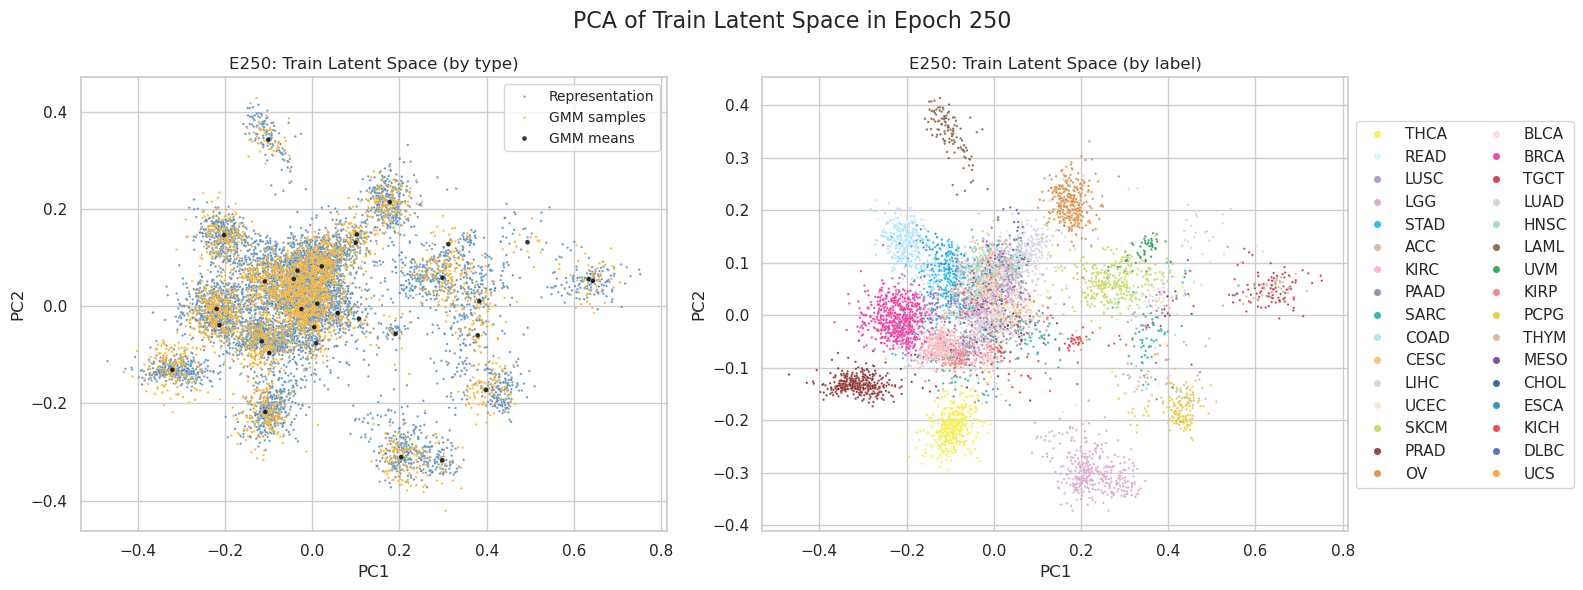

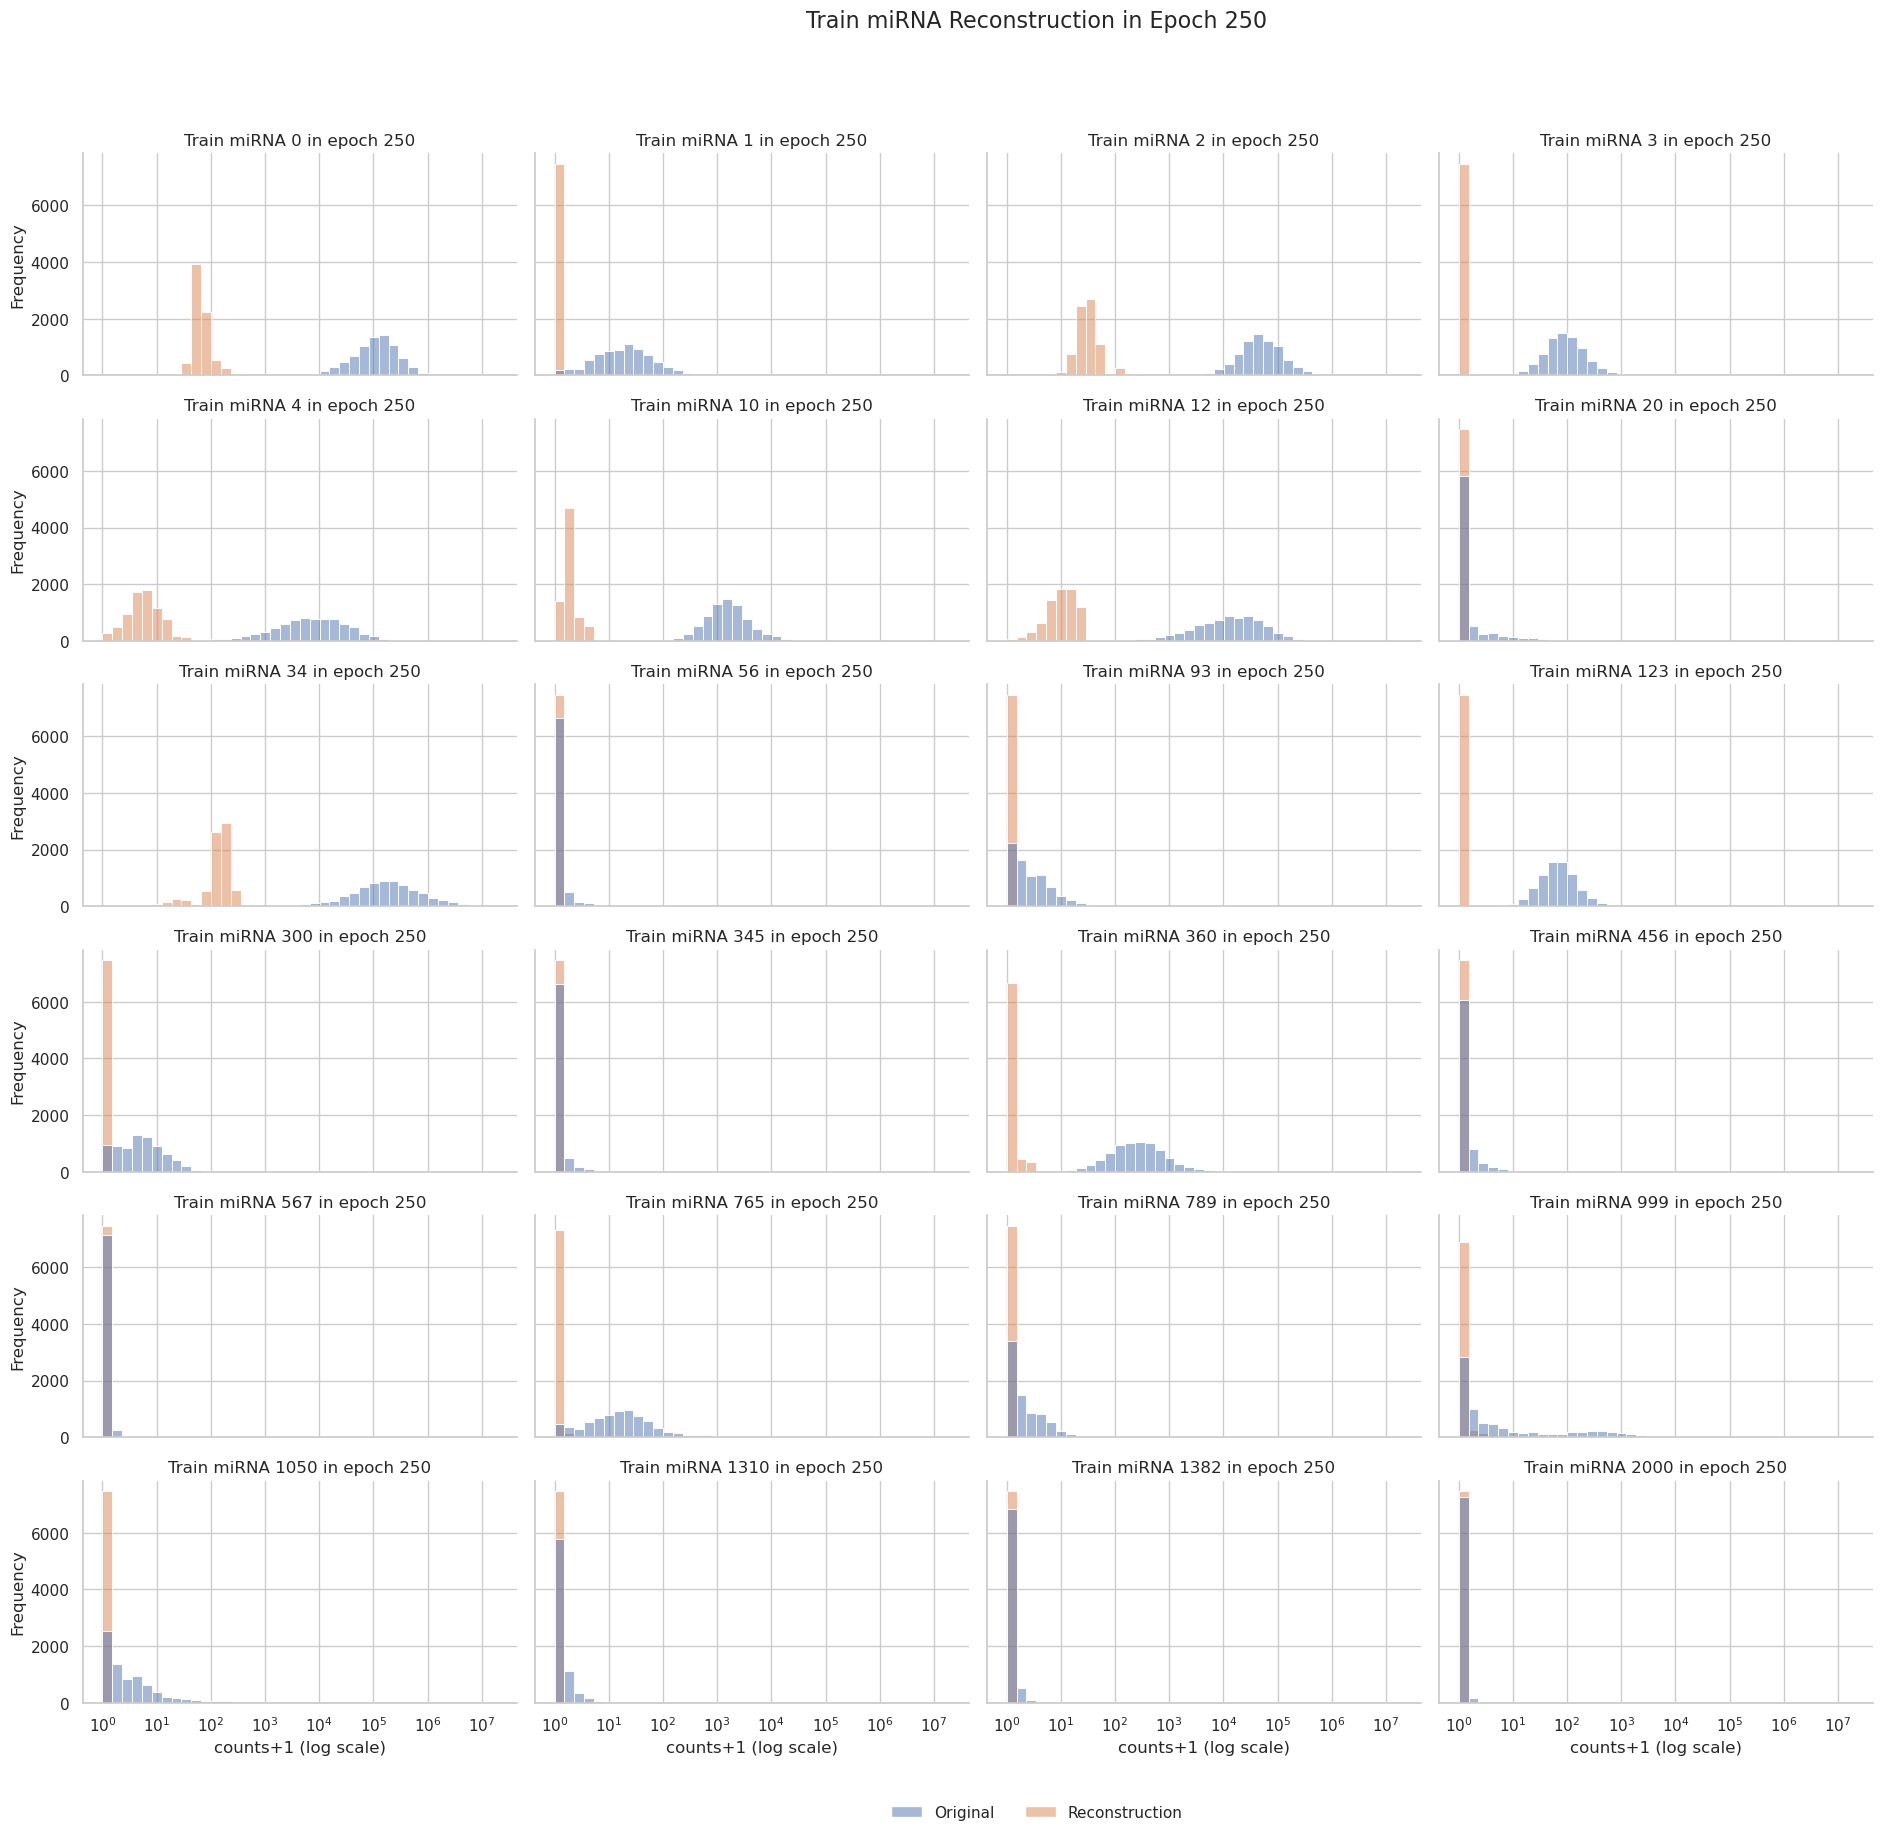

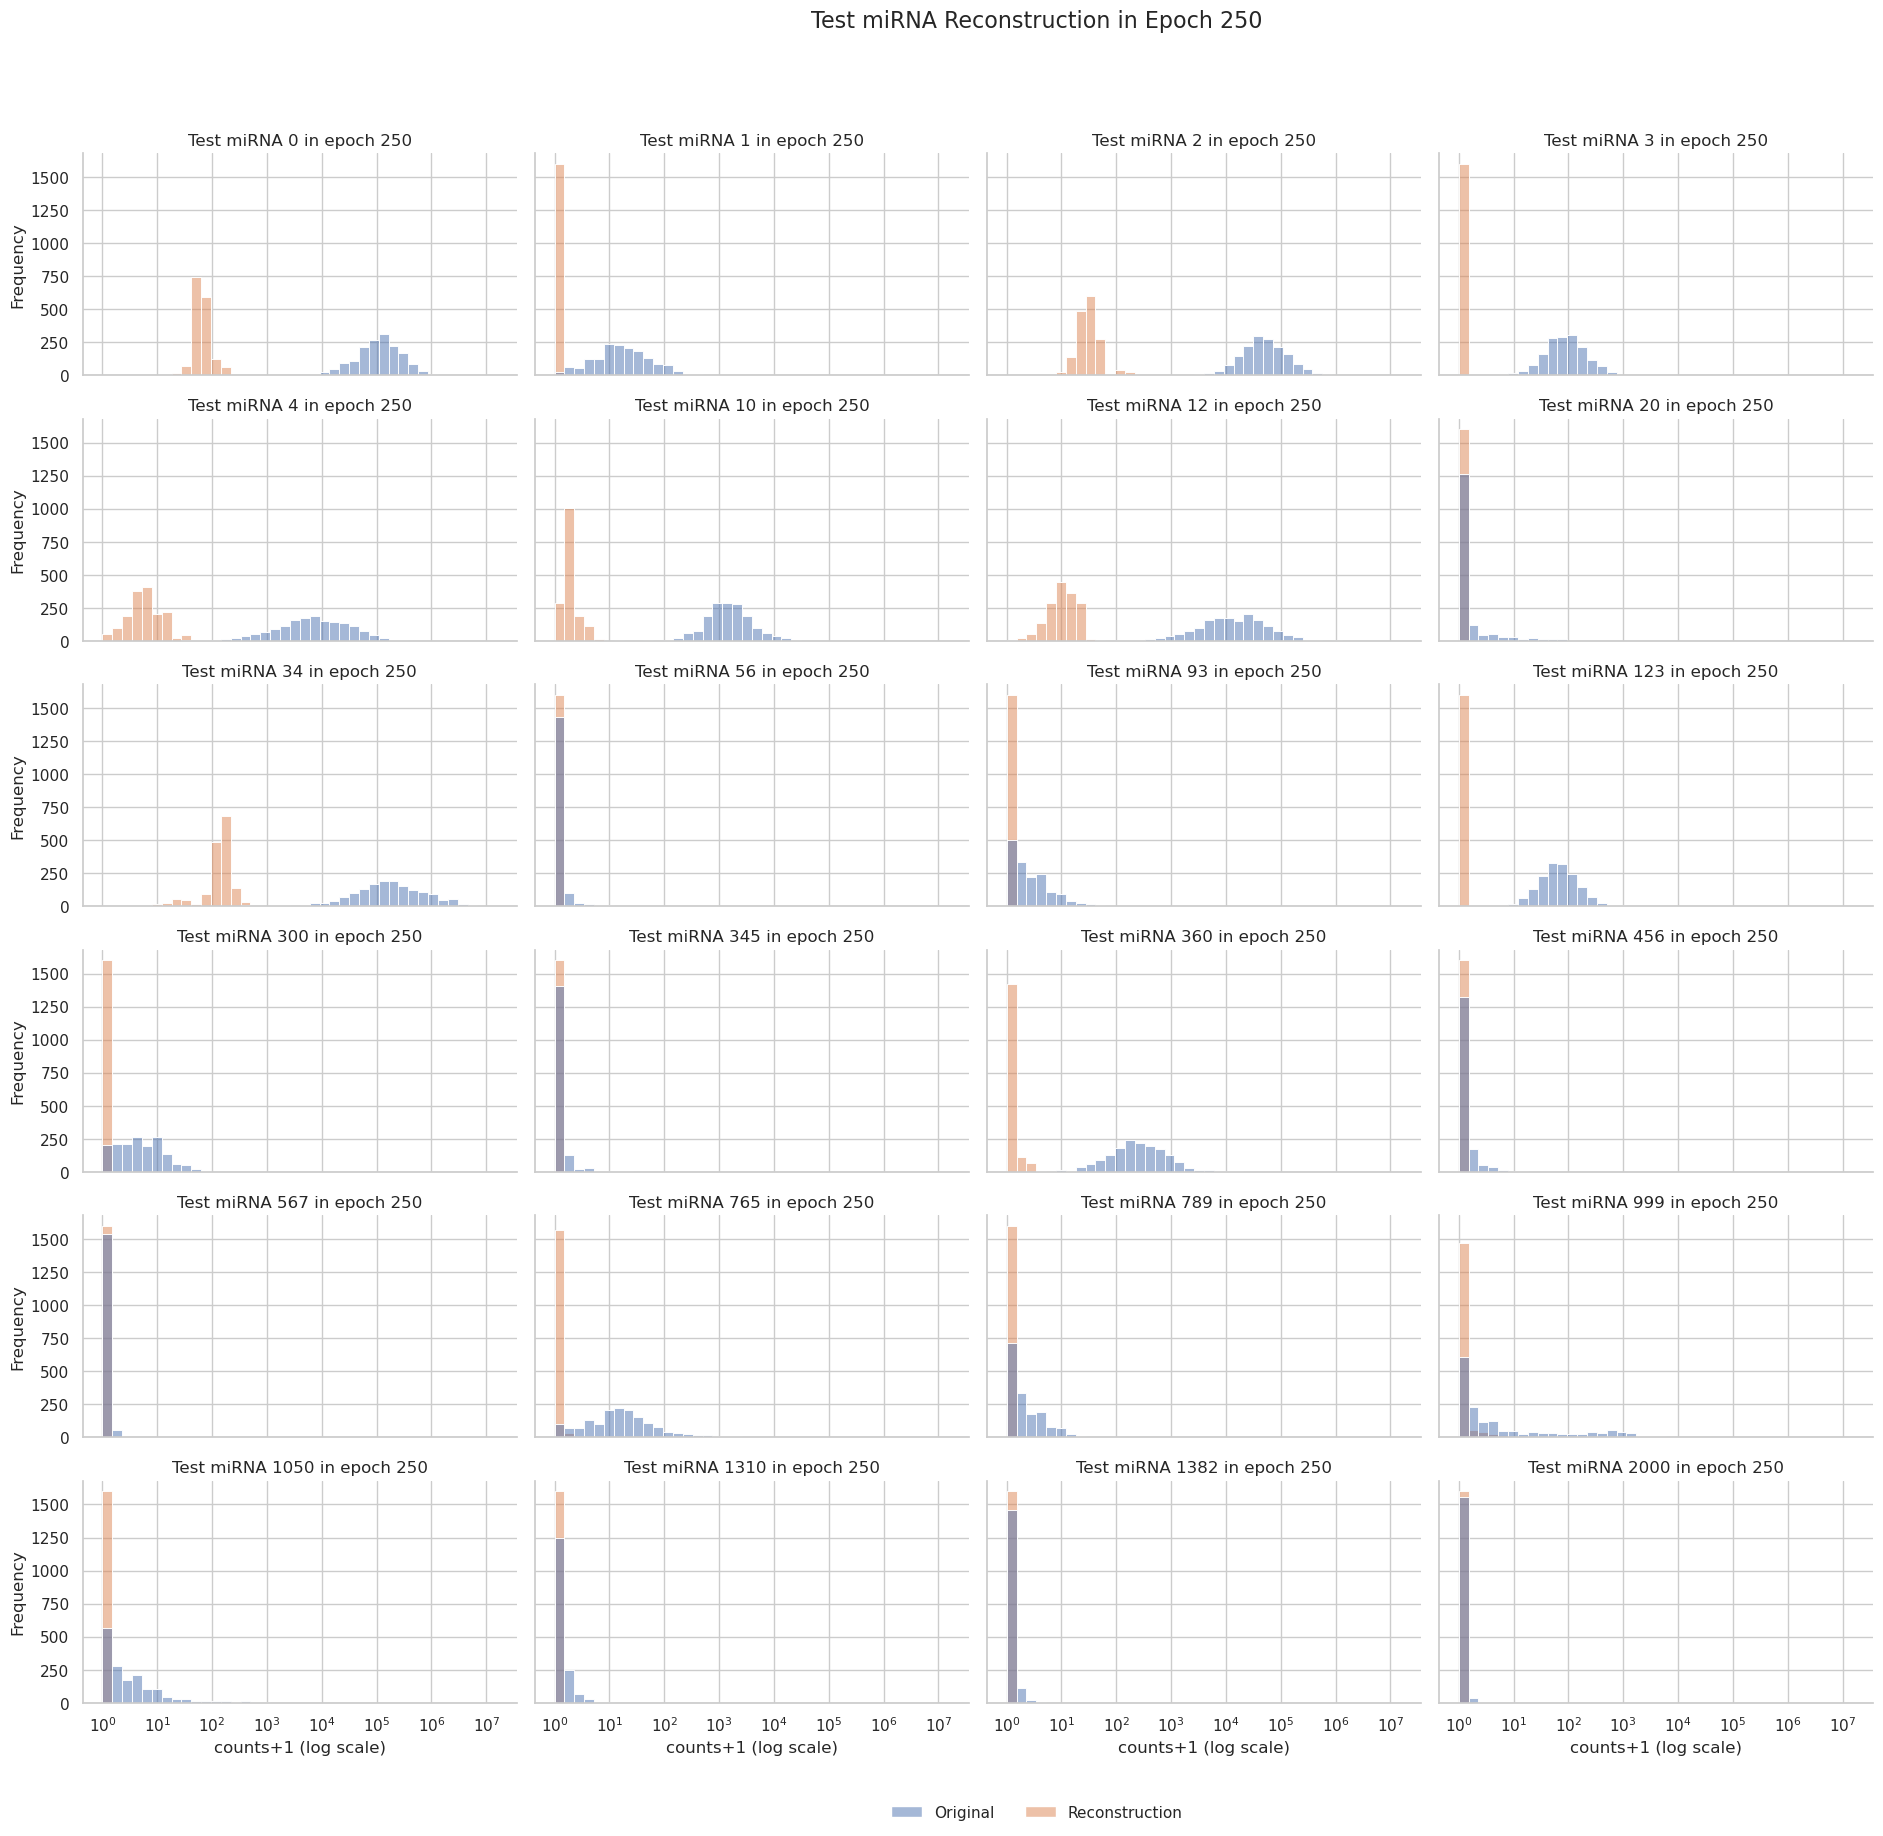

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 256/301 [14:38<03:51,  5.13s/it]

255 train_recon: 1.7668721073400473 train_gmm: 2.162260725525956 train_mse: 23628298.0 train_mae: 776.4564208984375 train_r2: 0.38747209310531616 train_spearman: 0.4841517508029938 train_pearson: 0.8848706483840942 train_expl_var: 0.40215837955474854 train_msle: 1.0034505128860474
255 test_recon: 1.7671079511894123 test_gmm: 2.16198774691599 test_mse: 12528607.0 test_mae: 551.100341796875 test_r2: 0.4744882583618164 test_spearman: 0.4626096189022064 test_pearson: 0.8803356289863586 test_expl_var: 0.48535799980163574 test_msle: 0.9084514379501343


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 261/301 [14:50<01:54,  2.86s/it]

260 train_recon: 1.7650879443169323 train_gmm: 2.162367200959914 train_mse: 23784520.0 train_mae: 780.064453125 train_r2: 0.38342225551605225 train_spearman: 0.4862496554851532 train_pearson: 0.8867804408073425 train_expl_var: 0.39836180210113525 train_msle: 0.9162197113037109
260 test_recon: 1.7650665179155567 test_gmm: 2.1622395350440153 test_mse: 12748783.0 test_mae: 556.9951171875 test_r2: 0.46525293588638306 test_spearman: 0.4646691679954529 test_pearson: 0.8803098201751709 test_expl_var: 0.47654885053634644 test_msle: 0.8201727271080017


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 266/301 [15:02<01:26,  2.48s/it]

265 train_recon: 1.763727236314897 train_gmm: 2.162298904964121 train_mse: 23639140.0 train_mae: 777.1018676757812 train_r2: 0.3871909976005554 train_spearman: 0.4854497015476227 train_pearson: 0.8867576122283936 train_expl_var: 0.40196484327316284 train_msle: 0.9598861932754517
265 test_recon: 1.7638745008755028 test_gmm: 2.1624440657206434 test_mse: 12553432.0 test_mae: 552.5899047851562 test_r2: 0.47344690561294556 test_spearman: 0.4663650393486023 test_pearson: 0.8799030184745789 test_expl_var: 0.4843364357948303 test_msle: 0.8656763434410095


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 271/301 [15:15<01:13,  2.45s/it]

270 train_recon: 1.7622181929220557 train_gmm: 2.1622367067667563 train_mse: 23879820.0 train_mae: 782.0759887695312 train_r2: 0.38095176219940186 train_spearman: 0.4880315959453583 train_pearson: 0.8865049481391907 train_expl_var: 0.3959764838218689 train_msle: 0.9189930558204651
270 test_recon: 1.7616353504201918 test_gmm: 2.1621526066472128 test_mse: 12669149.0 test_mae: 556.9102172851562 test_r2: 0.4685932397842407 test_spearman: 0.46607863903045654 test_pearson: 0.8812794089317322 test_expl_var: 0.4796379804611206 test_msle: 0.8964934349060059


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 276/301 [15:27<01:00,  2.41s/it]

275 train_recon: 1.7614476839943956 train_gmm: 2.1620878064678677 train_mse: 23485782.0 train_mae: 774.9668579101562 train_r2: 0.3911665678024292 train_spearman: 0.4878341555595398 train_pearson: 0.8882297277450562 train_expl_var: 0.40571534633636475 train_msle: 1.1024327278137207
275 test_recon: 1.7615652882153694 test_gmm: 2.1620968706082135 test_mse: 12504982.0 test_mae: 553.3541259765625 test_r2: 0.4754791259765625 test_spearman: 0.4707757830619812 test_pearson: 0.8813906311988831 test_expl_var: 0.4862409234046936 test_msle: 0.9833757281303406


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 281/301 [15:39<00:48,  2.41s/it]

280 train_recon: 1.7600928591199068 train_gmm: 2.1619907448063027 train_mse: 23409786.0 train_mae: 775.0216674804688 train_r2: 0.3931366801261902 train_spearman: 0.48379620909690857 train_pearson: 0.8895421624183655 train_expl_var: 0.4075832962989807 train_msle: 1.208492398262024
280 test_recon: 1.7605716682446495 test_gmm: 2.1623294751693276 test_mse: 12505843.0 test_mae: 554.5877685546875 test_r2: 0.4754430651664734 test_spearman: 0.47143685817718506 test_pearson: 0.8798059225082397 test_expl_var: 0.4860256314277649 test_msle: 1.1541829109191895


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 286/301 [15:51<00:36,  2.41s/it]

285 train_recon: 1.7588200240728282 train_gmm: 2.1618588931873495 train_mse: 23679854.0 train_mae: 779.7738037109375 train_r2: 0.3861355781555176 train_spearman: 0.4878692030906677 train_pearson: 0.8895108103752136 train_expl_var: 0.40092241764068604 train_msle: 1.0507488250732422
285 test_recon: 1.759312800385073 test_gmm: 2.161762439124961 test_mse: 12611920.0 test_mae: 555.7695922851562 test_r2: 0.47099369764328003 test_spearman: 0.47051048278808594 test_pearson: 0.8828973770141602 test_expl_var: 0.48192715644836426 test_msle: 0.9540599584579468


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 291/301 [16:03<00:24,  2.41s/it]

290 train_recon: 1.7578367990212724 train_gmm: 2.1617376592190216 train_mse: 23702750.0 train_mae: 780.1218872070312 train_r2: 0.38554203510284424 train_spearman: 0.489304780960083 train_pearson: 0.8895806670188904 train_expl_var: 0.4003453254699707 train_msle: 1.0388317108154297
290 test_recon: 1.7581417393217678 test_gmm: 2.1618129141698548 test_mse: 12737746.0 test_mae: 560.6848754882812 test_r2: 0.4657158851623535 test_spearman: 0.471725732088089 test_pearson: 0.8809391856193542 test_expl_var: 0.4768293499946594 test_msle: 0.9873918294906616


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 296/301 [16:15<00:12,  2.42s/it]

295 train_recon: 1.7569148390728362 train_gmm: 2.1616239098776426 train_mse: 24019826.0 train_mae: 785.6625366210938 train_r2: 0.37732231616973877 train_spearman: 0.4865610897541046 train_pearson: 0.8912092447280884 train_expl_var: 0.39257943630218506 train_msle: 0.8672173023223877
295 test_recon: 1.7571077455836026 test_gmm: 2.1615786398149592 test_mse: 12900501.0 test_mae: 563.5283813476562 test_r2: 0.4588891267776489 test_spearman: 0.47760558128356934 test_pearson: 0.8820475935935974 test_expl_var: 0.4703611731529236 test_msle: 0.8376820683479309


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 300/301 [16:24<00:02,  2.42s/it]

300 train_recon: 1.7561074105498504 train_gmm: 2.1615654245910276 train_mse: 23975436.0 train_mae: 785.0233154296875 train_r2: 0.37847304344177246 train_spearman: 0.4923021197319031 train_pearson: 0.890938401222229 train_expl_var: 0.3936637043952942 train_msle: 0.9068556427955627
300 test_recon: 1.7560106138887996 test_gmm: 2.1615653348371136 test_mse: 12770190.0 test_mae: 558.6796875 test_r2: 0.4643550515174866 test_spearman: 0.4778382480144501 test_pearson: 0.8814331293106079 test_expl_var: 0.4755713939666748 test_msle: 0.8503190279006958


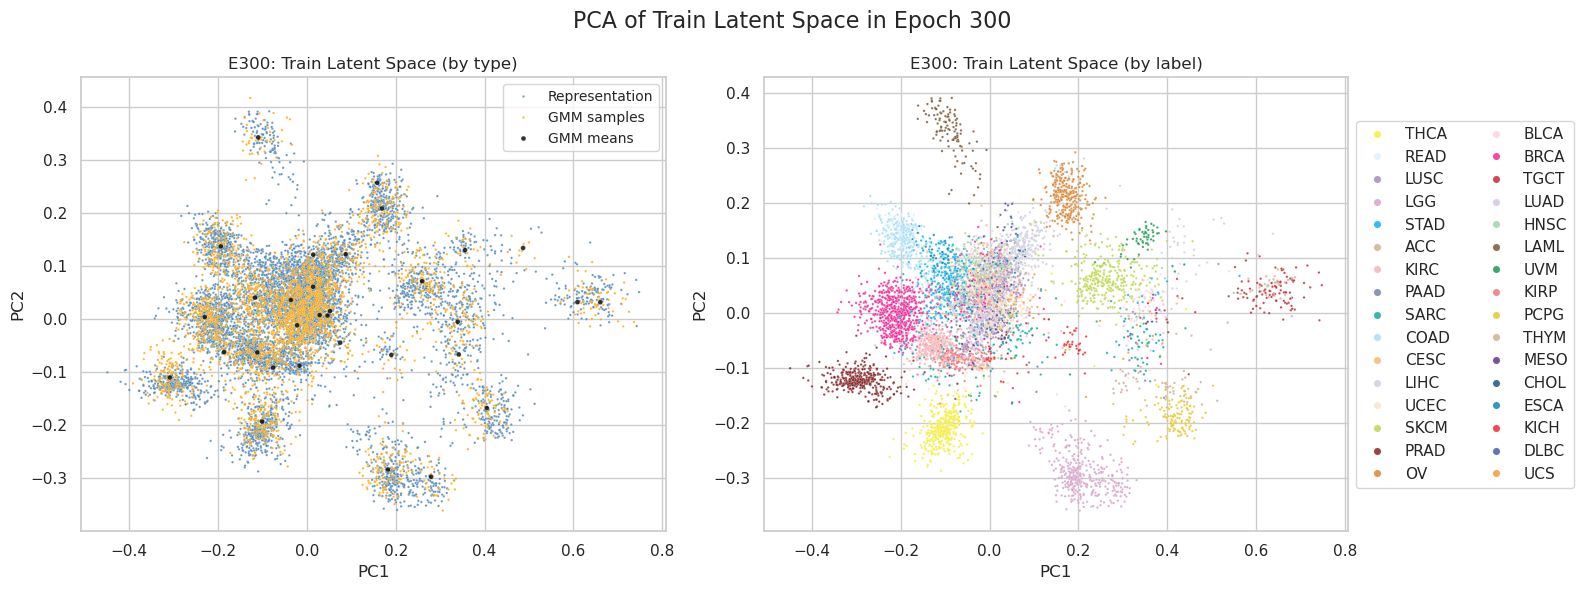

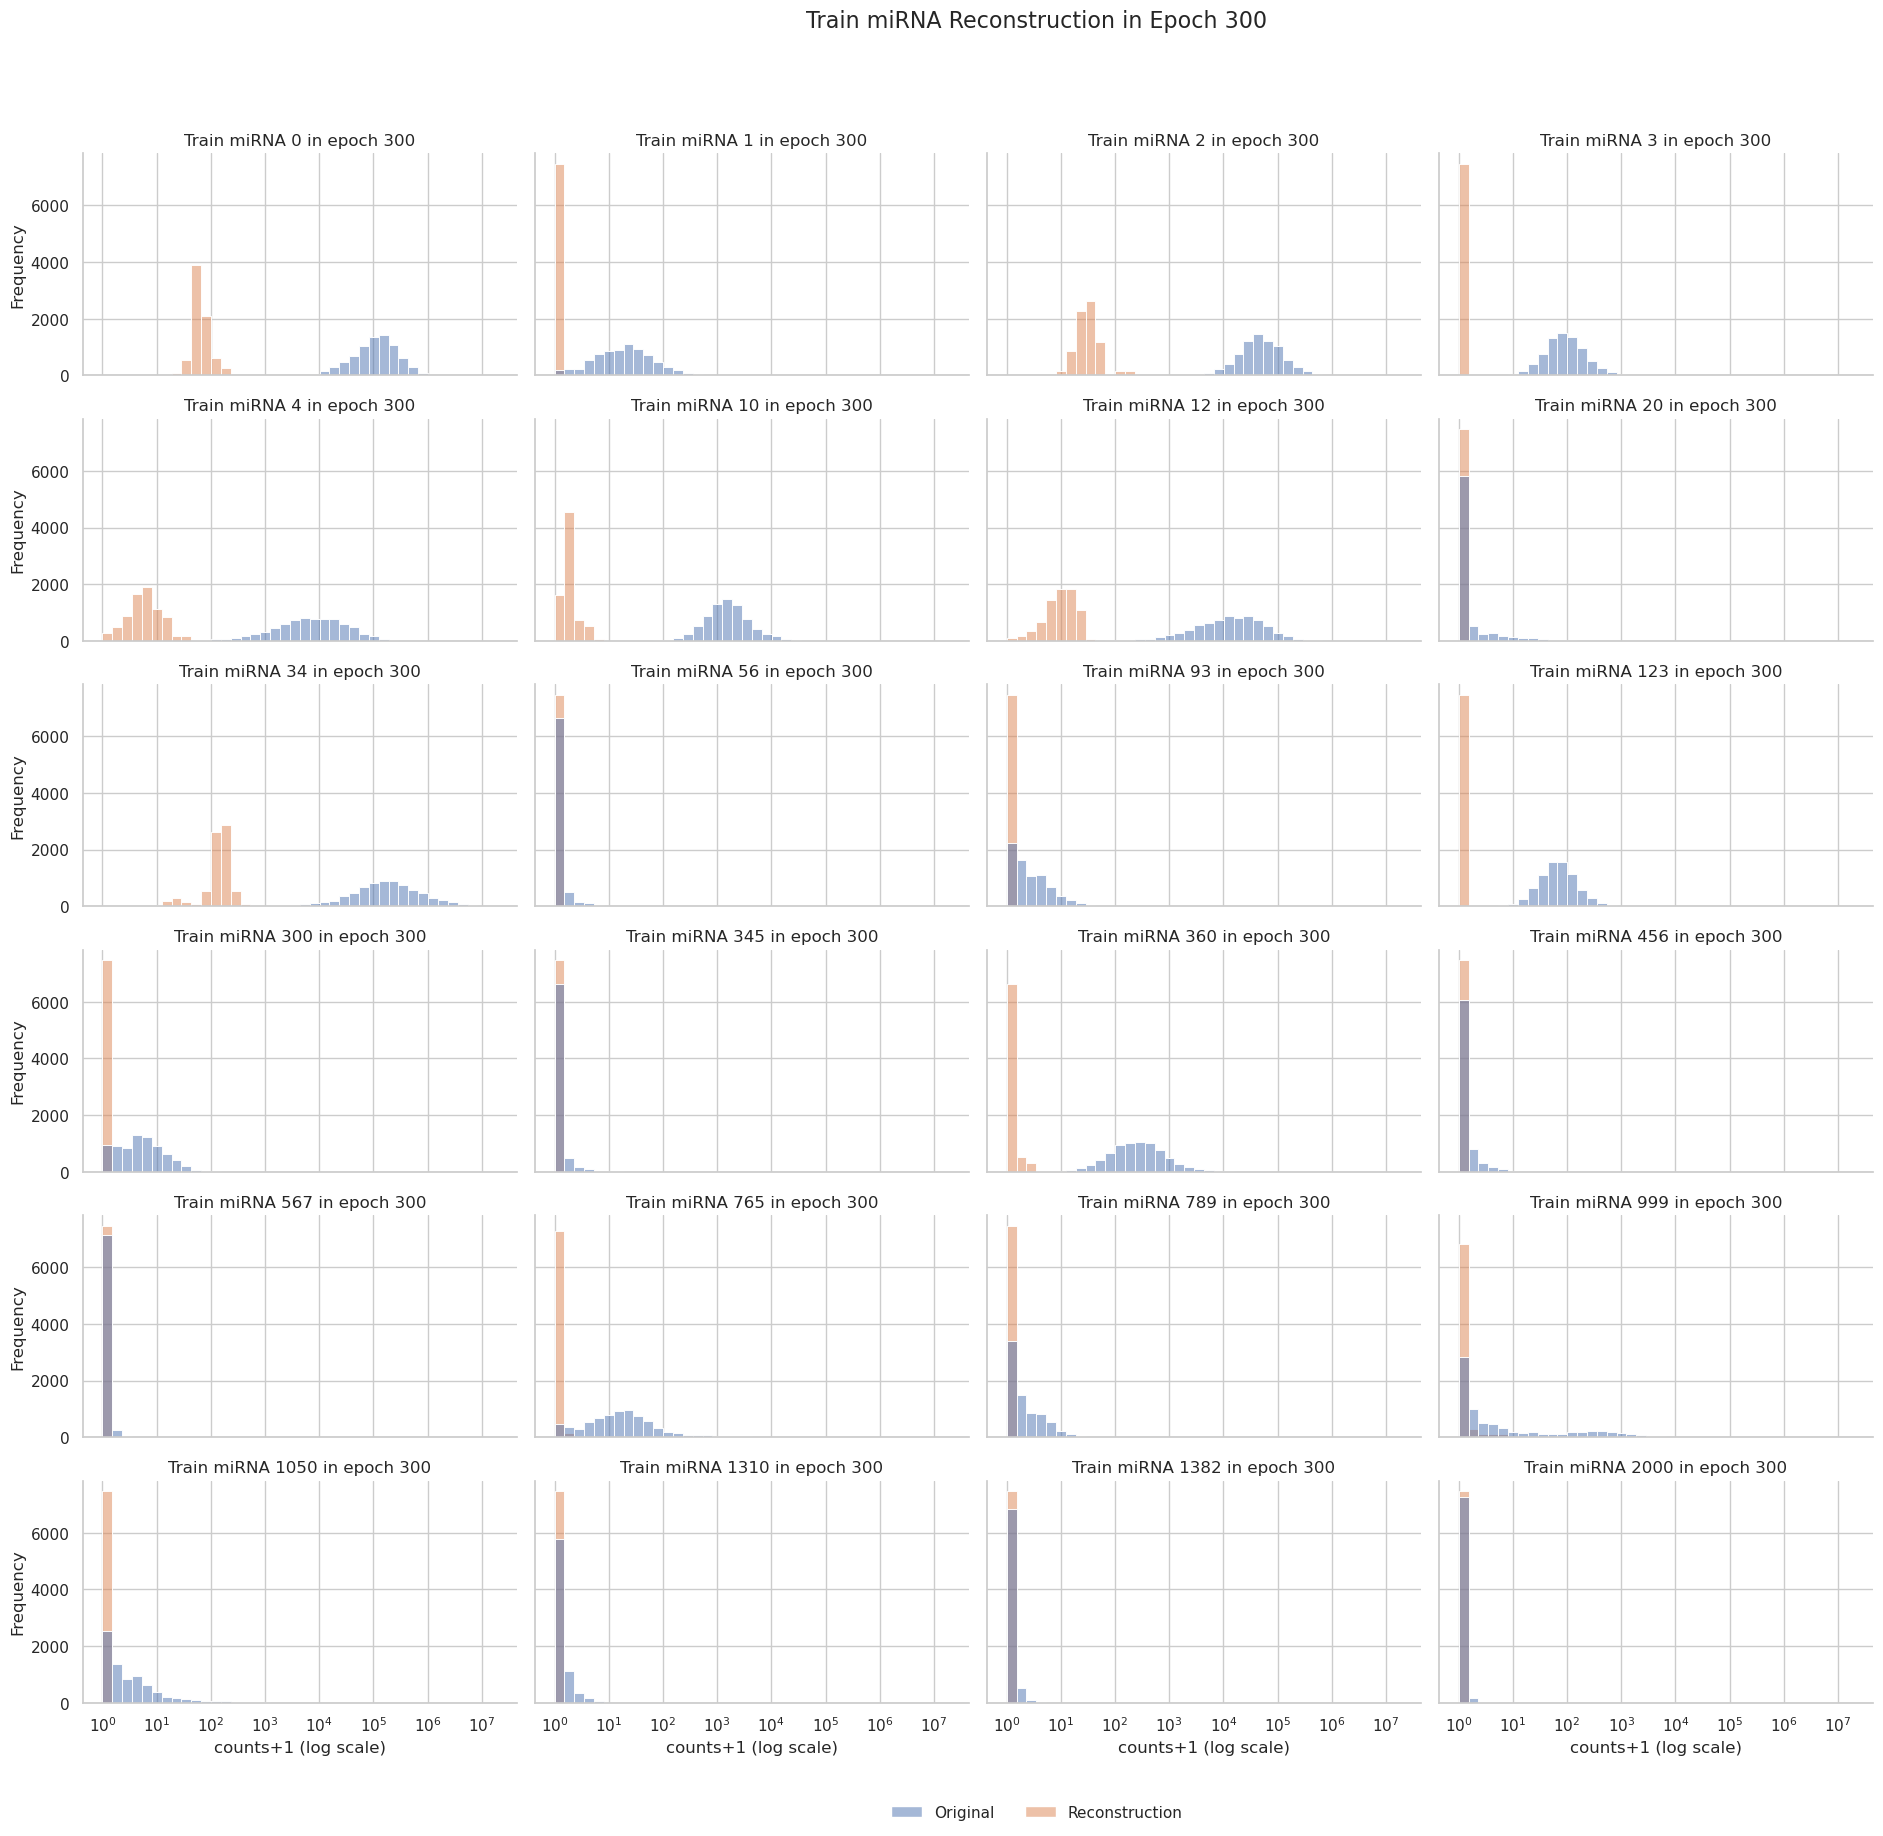

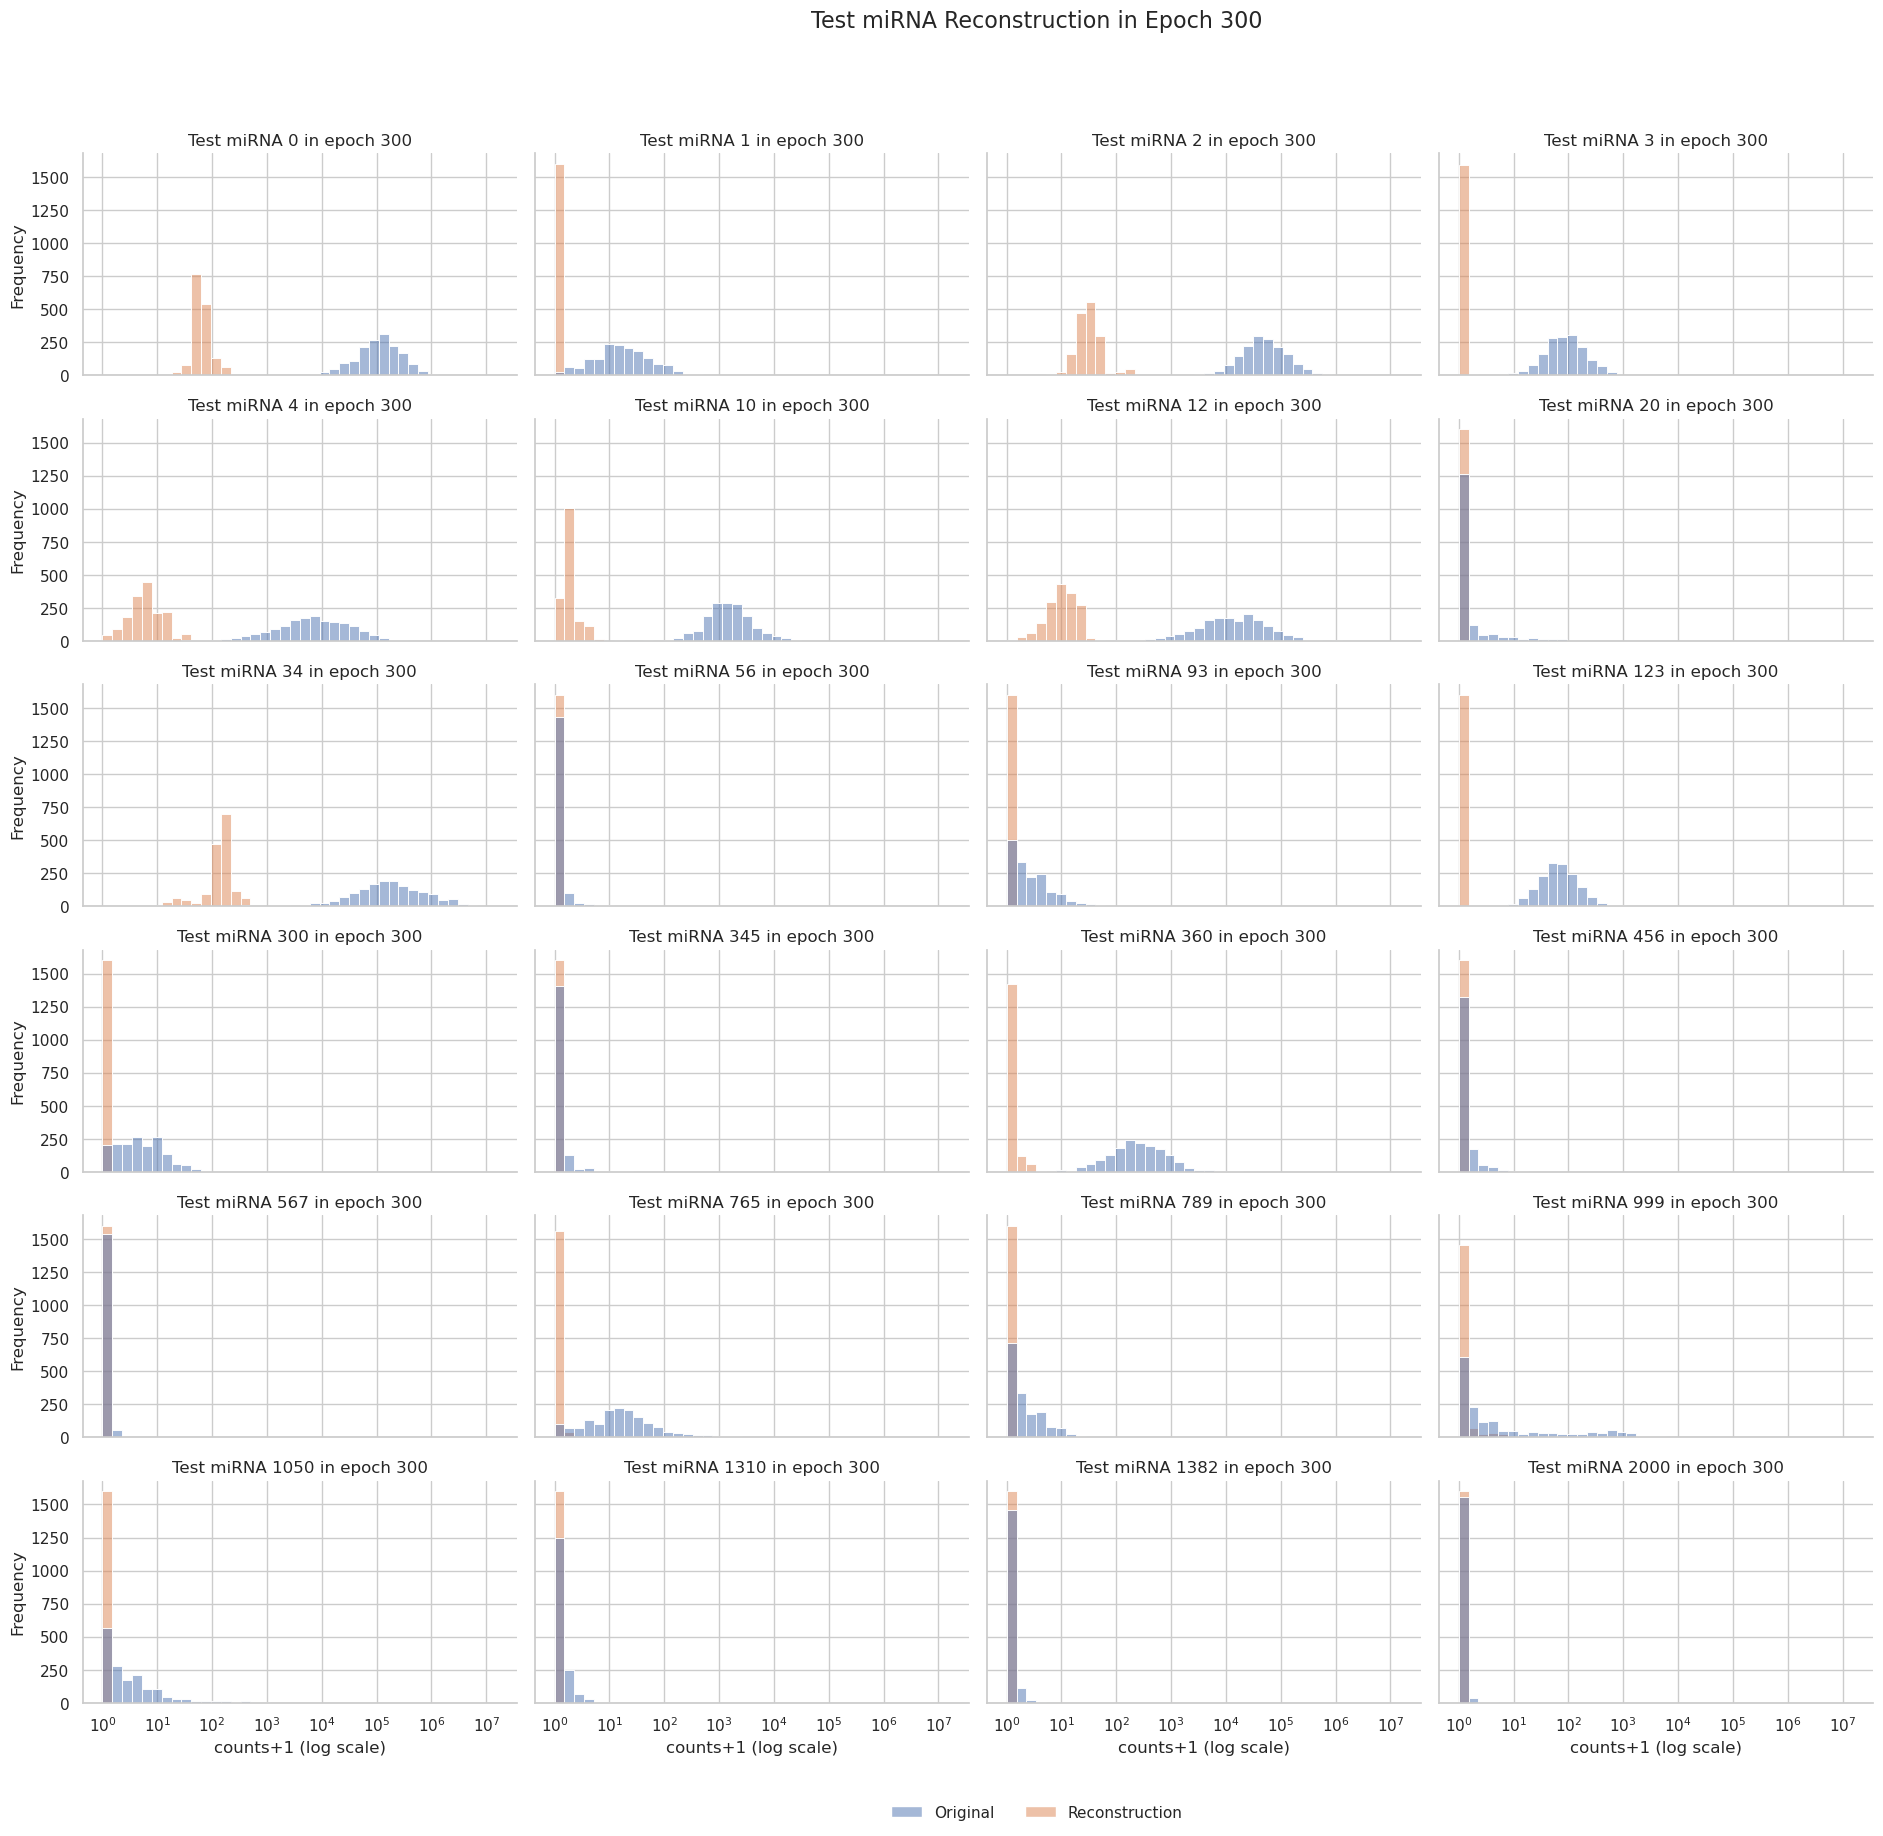

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [17:21<00:00,  3.46s/it]


In [18]:
loss_tab = train_dgd_mirna(
        dgd, train_loader, validation_loader, device, train_dataset, validation_dataset,
        learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
        nepochs=nepochs, pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, subset = subset, wandb_log=False
    )

# Plotting

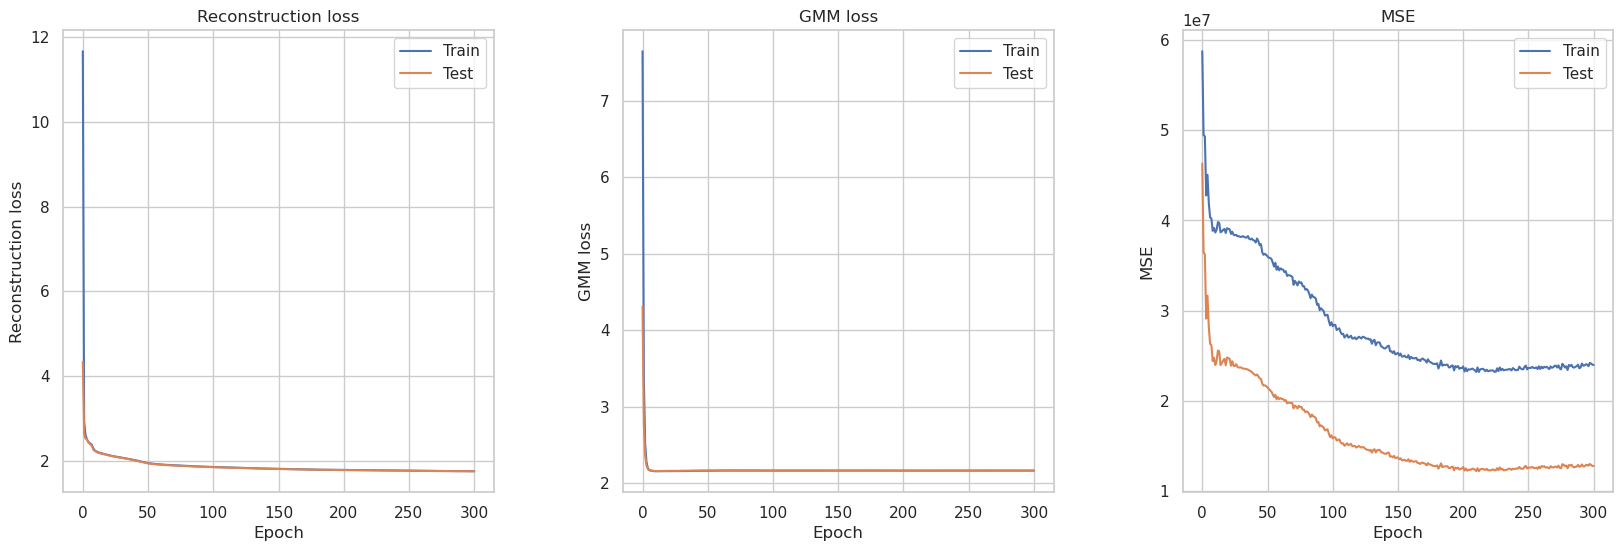

In [19]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

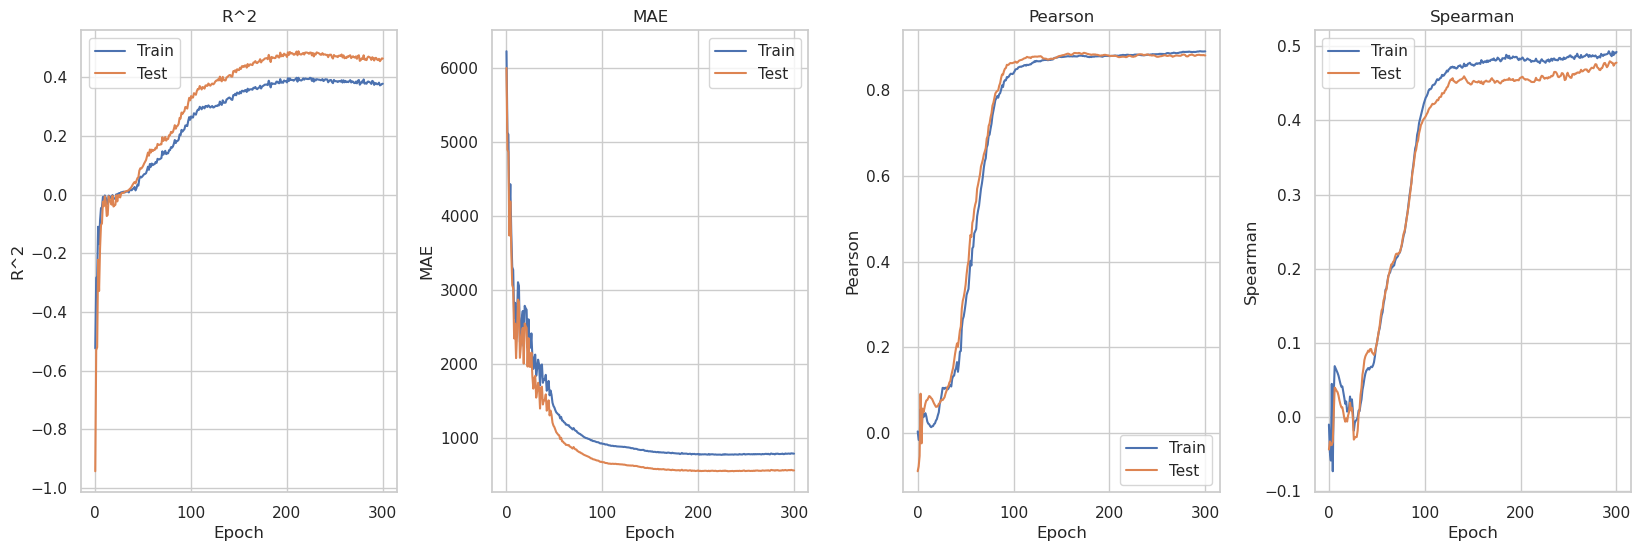

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Third subplot for RMSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for RMSE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Display the plots
plt.show()

# Save Model

In [21]:
save_model = False

# Set results paths
if save_model:
    loss_path = 'results/0511_loss_mirna.pickle'
    dgd_path = 'results/0511_dgd_mirna.pickle'
    
    torch.save(loss_tab, loss_path)
    torch.save(dgd, dgd_path)

# Simple Analysis

## Test Set

In [22]:
from base.dgd.latent import RepresentationLayer
from tqdm import tqdm

test_epochs = 301
gmm_loss = True

Ntest=len(test_loader.dataset)
if dgd.test_rep is None:
    dgd.test_rep = RepresentationLayer(dgd.rep_dim,Ntest).to(device)
test_rep_optimizer = torch.optim.AdamW(dgd.test_rep.parameters(), lr=learning_rates['rep'], weight_decay=weight_decay, betas=betas)

for epoch in tqdm(range(test_epochs)):
    test_rep_optimizer.zero_grad()
    dgd.eval()
    for (mirna_data, lib_mirna, index) in test_loader:
        recon_loss, gmm_loss = dgd.forward_and_loss(
            z=dgd.test_rep(index),
            target=mirna_data.to(device),  # Pass both mRNA and miRNA data
            scale=lib_mirna.unsqueeze(1).to(device),  # Pass both scales
            gmm_loss=gmm_loss,
            reduction=reduction_type,
            type="mirna"
        )
        loss = recon_loss + gmm_loss
        loss.backward()
    test_rep_optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [05:18<00:00,  1.06s/it]


In [26]:
recon = dgd.forward(dgd.test_rep())
data = test_loader.dataset.data
X = recon.detach().cpu()
y = data.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [27]:
from scipy import stats

mirna_features = train_mirna.shape[1]-4
spearman_corr = []
pearson_corr = []
spearman_pval = []
pearson_pval = []

for i in range(y.shape[1]):
    # Calculate Spearman correlation coefficient
    spearman, spearman_p = stats.spearmanr(X[:,i], y[:,i])
    pearson, pearson_p = stats.pearsonr(X[:,i], y[:,i])
    spearman_corr.append(spearman)
    pearson_corr.append(pearson)
    spearman_pval.append(spearman_p)
    pearson_pval.append(spearman_p)
    
corr_data = pd.DataFrame(
    data={
        'spearman': spearman_corr, 
        'pearson': pearson_corr,
        'spearman_p': spearman_pval,
        'pearson_p': pearson_pval,
        'mirna': np.arange(0,mirna_features)
    },
    index=np.arange(0,mirna_features)
)
corr_data

spearman   pearson     spearman_p      pearson_p  mirna
0     0.402016  0.366271   2.806157e-63   2.806157e-63      0
1     0.459844  0.196229   1.249243e-84   1.249243e-84      1
2     0.375135  0.357890   1.069736e-54   1.069736e-54      2
3     0.391027  0.436990   1.130157e-59   1.130157e-59      3
4     0.650424  0.508630  2.489238e-193  2.489238e-193      4
...        ...       ...            ...            ...    ...
2019  0.118289  0.120503   2.059322e-06   2.059322e-06   2019
2020  0.083543  0.081322   8.167612e-04   8.167612e-04   2020
2021  0.082536  0.095176   9.445175e-04   9.445175e-04   2021
2022  0.131850  0.100586   1.181576e-07   1.181576e-07   2022
2023  0.120470  0.104278   1.327083e-06   1.327083e-06   2023

[2024 rows x 5 columns]

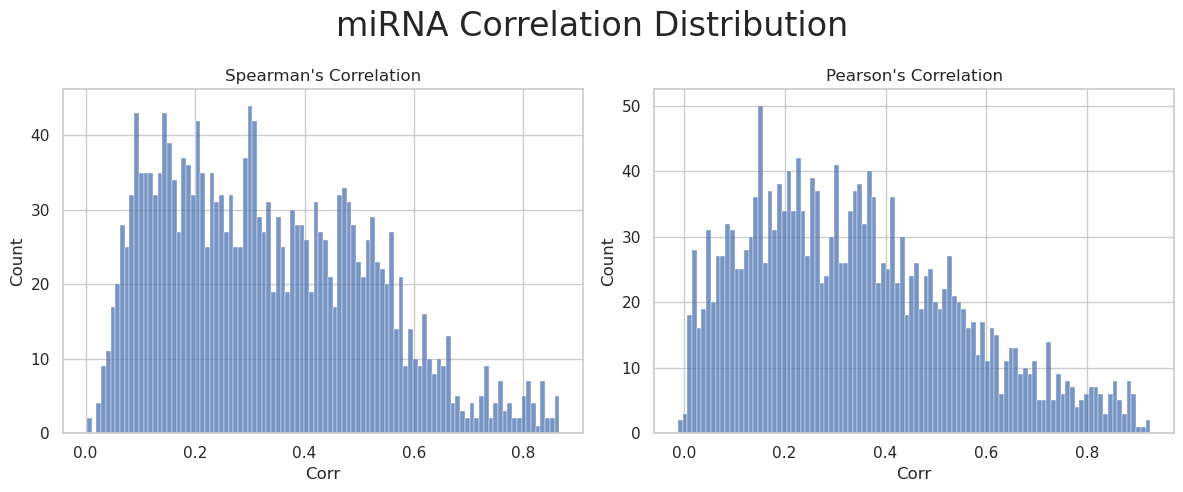

In [28]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
plt.title("Spearman's Correlation")
plt.xlabel("Corr")

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
plt.title("Pearson's Correlation")
plt.xlabel("Corr")

# Add the main title to the figure
fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
plt.tight_layout()
plt.show()

In [29]:
miR_122_5p = pd.DataFrame(
    data={
        'X': X[:,1371], 
        'y': y[:,1371],
        'cancer_type': cancer_type,
        'color': color
    }
)

In [30]:
miR_122_5p[miR_122_5p['cancer_type'] == 'LIHC']

X         y cancer_type    color
9      5.679174  167451.0        LIHC  #CACDDD
44    10.900600   70147.0        LIHC  #CACDDD
58     4.877210  146422.0        LIHC  #CACDDD
72     5.666381  177812.0        LIHC  #CACDDD
95     9.432320  119181.0        LIHC  #CACDDD
...         ...       ...         ...      ...
1474  12.780311   59562.0        LIHC  #CACDDD
1530   4.929712  249838.0        LIHC  #CACDDD
1579   5.388367   29609.0        LIHC  #CACDDD
1580   6.384581   69957.0        LIHC  #CACDDD
1591   4.266888   41753.0        LIHC  #CACDDD

[63 rows x 4 columns]

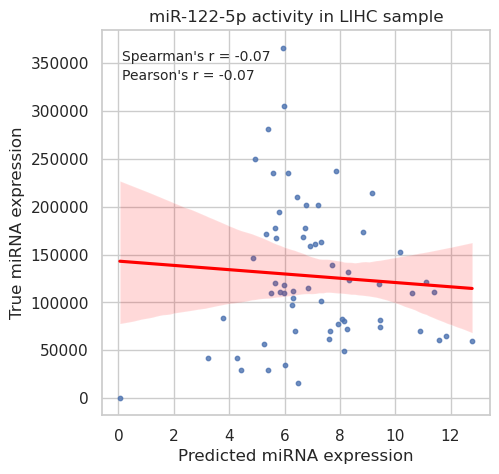

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lihc_data = miR_122_5p[miR_122_5p['cancer_type'] == 'LIHC']

# Create scatterplot
sns.regplot(data=lihc_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lihc_data['X'], lihc_data['y'])
pearson_corr, _ = stats.pearsonr(lihc_data['X'], lihc_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in LIHC sample")
plt.show()

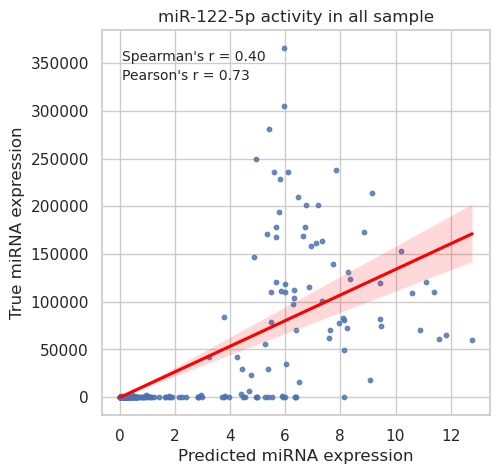

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lihc_data = miR_122_5p

# Create scatterplot
sns.regplot(data=lihc_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lihc_data['X'], lihc_data['y'])
pearson_corr, _ = stats.pearsonr(lihc_data['X'], lihc_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in all sample")
plt.show()

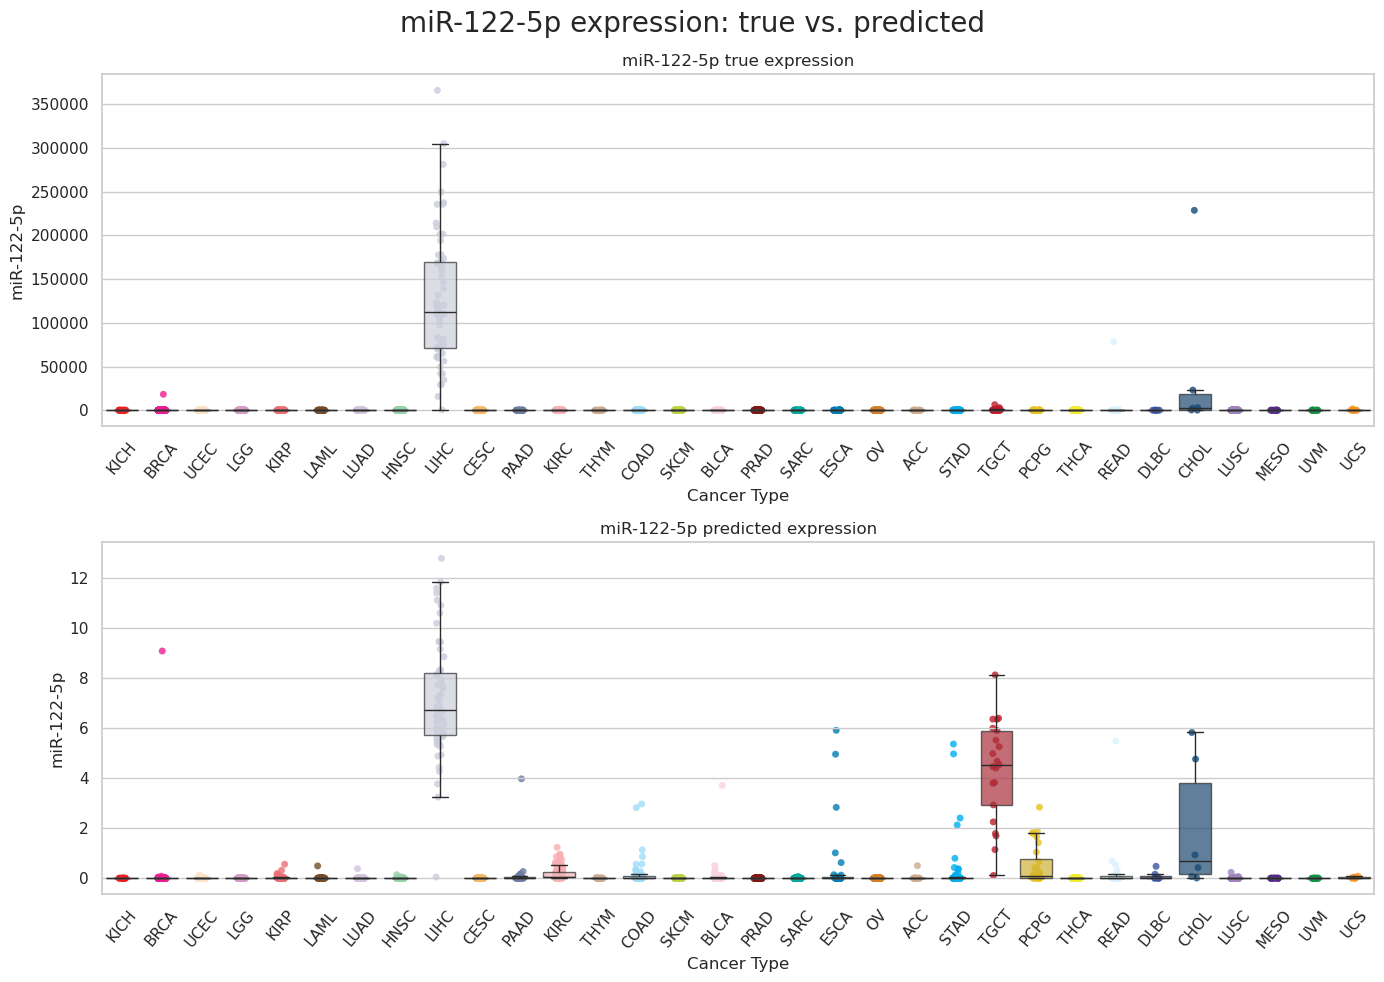

In [33]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_122_5p, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.subplot(2, 1, 2)
sns.boxplot(data=miR_122_5p, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.suptitle("miR-122-5p expression: true vs. predicted", fontsize=20)
plt.tight_layout()
plt.show()

In [34]:
miR_124_3p = pd.DataFrame(
    data={
        'X': X[:,1304], 
        'y': y[:,1304],
        'cancer_type': cancer_type,
        'color': color
    }
)

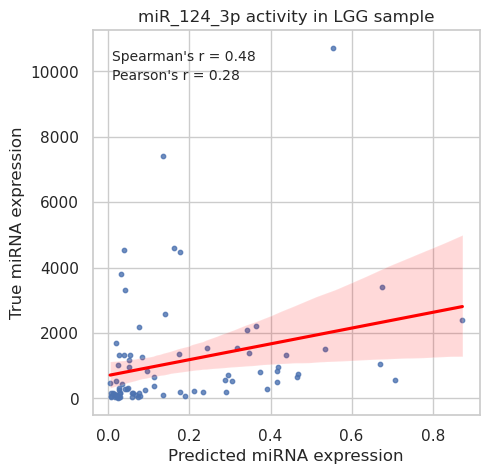

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lgg_data = miR_124_3p[miR_124_3p['cancer_type'] == 'LGG']

# Create scatterplot
sns.regplot(data=lgg_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lgg_data['X'], lgg_data['y'])
pearson_corr, _ = stats.pearsonr(lgg_data['X'], lgg_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR_124_3p activity in LGG sample")
plt.show()

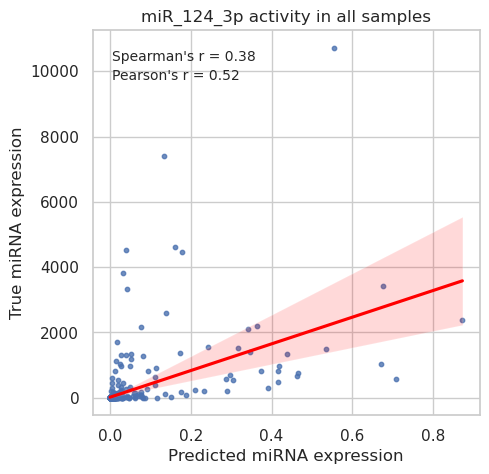

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lgg_data = miR_124_3p

# Create scatterplot
sns.regplot(data=lgg_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lgg_data['X'], lgg_data['y'])
pearson_corr, _ = stats.pearsonr(lgg_data['X'], lgg_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR_124_3p activity in all samples")
plt.show()

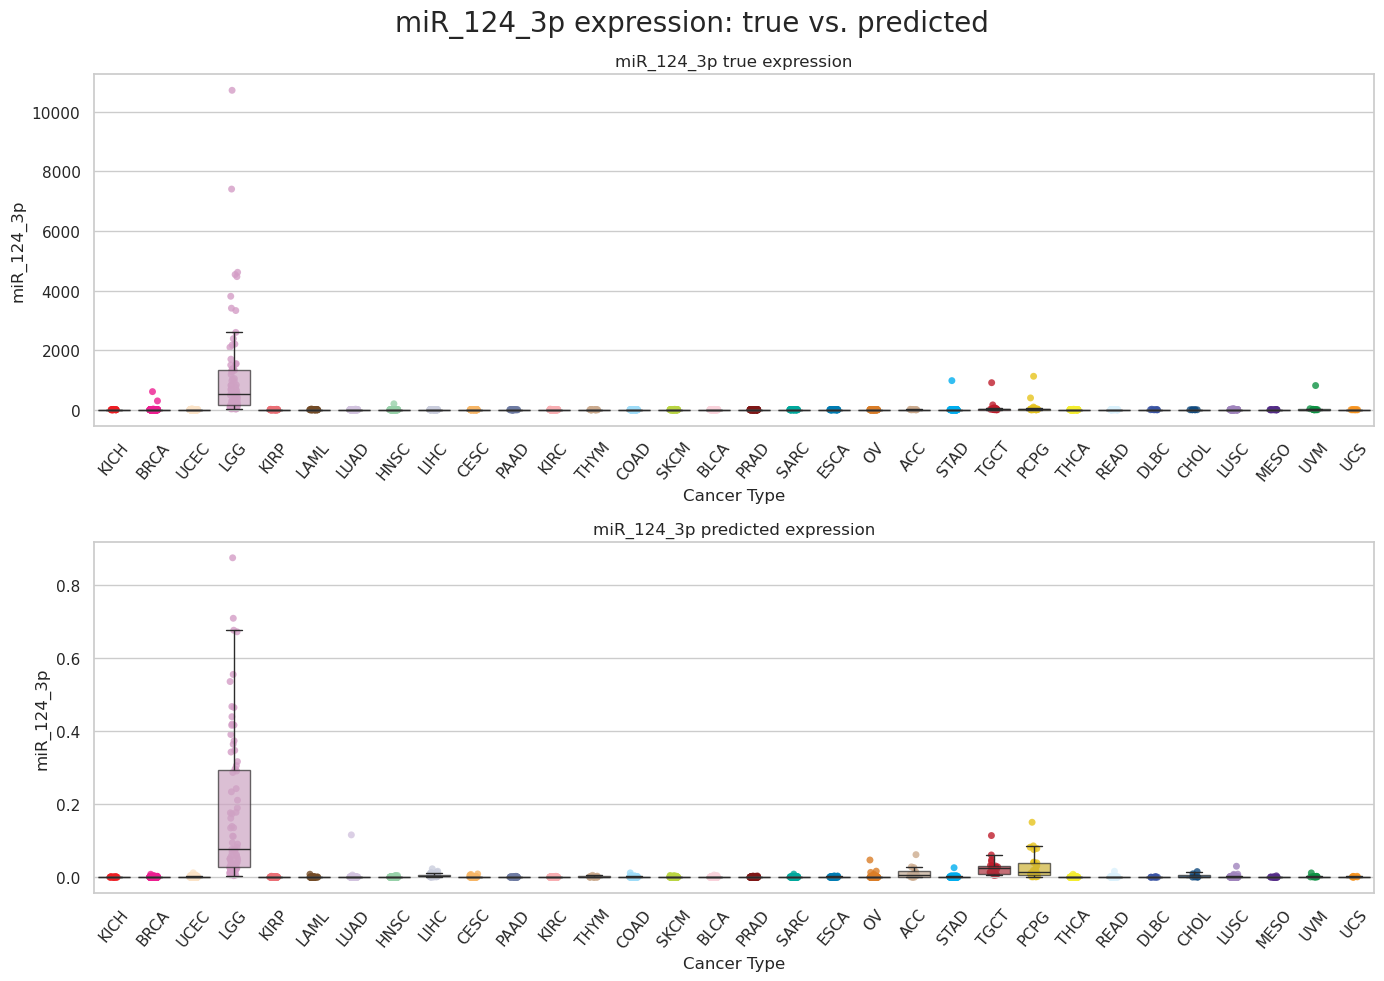

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_124_3p, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_124_3p, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)


plt.subplot(2, 1, 2)
sns.boxplot(data=miR_124_3p, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=0.7), showfliers=False)
sns.stripplot(data=miR_124_3p, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)

plt.suptitle("miR_124_3p expression: true vs. predicted", fontsize=20)
plt.tight_layout()

plt.show()